# Imports

In [110]:
# from google.colab import drive
# drive.mount('/content/drive')

In [111]:
# Linear algebra
import numpy as np
# Random
import random
# Dataframe manipulation
import pandas as pd

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# Scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, _LRScheduler
from transformers import get_cosine_schedule_with_warmup

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc # Import auc function
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score

# statistics
from scipy.stats import pearsonr

# Report training progress
import wandb
wandb.login(key="fb87cc95d8c69efe715ee816e61954c9776c372d")  # TODO: Don't publish the key

# Progress bar
from tqdm import tqdm

# File management
import os
from pathlib import Path
DATA_PATH = '/zdata/user-data/noam/data/p2cs'

# Running best model heap
import heapq

# Plotting
import matplotlib
import mpld3
mpld3.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
# pseudocolor scatter plot
from scipy.stats import gaussian_kde

# Counter
from collections import Counter

# time
import time

# garbage collector
import gc

# build graph structures
import networkx as nx

import builtins

# type hints
from typing import Tuple, Optional, List, Dict, Any

# hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# memory profiler
%load_ext memory_profiler

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zdata/user-data/noam/.netrc


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [112]:
base_dir = Path("/zdata/user-data/noam/data/p2cs/")
full_genomes_dir = base_dir / "full_genomes_new"
organism_merged_genomes_dir = base_dir / "organism_merged_genomes_new"
genome_analysis_dir = base_dir / "genome_analysis_results"
mash_analysis_dir = base_dir / "mash_analysis"
data_dir = mash_analysis_dir / "distance_matrices"  # For genome-level matrices
taxonomy_dir = base_dir / "taxonomy"
k_values = [11, 15, 19, 21]

# Dataset Class

In [113]:
class CognateDataset(Dataset):
    def __init__(self, hk_embeddings, rr_embeddings, organisms=None, indices=None, hk_genes=None, rr_genes=None):
        self.hk = torch.tensor(hk_embeddings, dtype=torch.float32)
        self.rr = torch.tensor(rr_embeddings, dtype=torch.float32)
        self.organisms = np.array(organisms)  # Store organism information
        self.indices = np.array(indices) # Store the original indices
        self.hk_genes = np.array(hk_genes) # Store HK gene information
        self.rr_genes = np.array(rr_genes) # Store RR gene information
        assert len(self.hk) == len(self.rr)
        if organisms is not None:
            assert len(self.hk) == len(self.organisms)
        if indices is not None:
            assert len(self.hk) == len(self.indices)
        if hk_genes is not None:
            assert len(self.hk) == len(self.hk_genes)
        if rr_genes is not None:
            assert len(self.rr) == len(self.rr_genes)

    def __len__(self):
        return len(self.hk)

    def __getitem__(self, idx):
        return (self.hk[idx], self.rr[idx],
                self.organisms[idx] if self.organisms is not None else None,
                self.hk_genes[idx] if self.hk_genes is not None else None,
                self.rr_genes[idx] if self.rr_genes is not None else None), \
               self.indices[idx] if self.indices is not None else None

    def sample(self, n):
        sampled_pairs = np.random.choice(len(self), n)
        sampled_indices = self.indices[sampled_pairs]
        sampled_hk = self.hk[sampled_pairs, :].numpy()
        sampled_rr = self.rr[sampled_pairs, :].numpy()
        sampled_organisms = self.organisms[sampled_pairs].tolist()
        sampled_hk_genes = self.hk_genes[sampled_pairs].tolist()
        sampled_rr_genes = self.rr_genes[sampled_pairs].tolist()
        return CognateDataset(hk_embeddings=sampled_hk, rr_embeddings=sampled_rr, organisms=sampled_organisms, 
        indices=sampled_indices, hk_genes=sampled_hk_genes, rr_genes=sampled_rr_genes)

class OrganismBatchSampler:
    """
    Custom batch sampler that groups complete organisms into batches.
    Each batch contains complete organisms (all proteins from selected organisms).
    Multiple organisms can be in a single batch if they fit within batch_size.
    """
    def __init__(self, organisms, batch_size, shuffle=True):
        self.organisms = organisms
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Group indices by organism
        self.organism_to_indices = {}
        for idx, organism in enumerate(organisms):
            if organism not in self.organism_to_indices:
                self.organism_to_indices[organism] = []
            self.organism_to_indices[organism].append(idx)

        # Get organism sizes
        self.organism_sizes = {org: len(indices) for org, indices in self.organism_to_indices.items()}

        # Create batches by packing complete organisms
        self.batches = self._create_batches()

        # Shuffle the order of batches if requested
        if self.shuffle:
            np.random.shuffle(self.batches)

    def _create_batches(self):
        """Create batches by packing complete organisms together."""
        batches = []
        organism_list = list(self.organism_to_indices.keys())

        if self.shuffle:
            np.random.shuffle(organism_list)

        i = 0
        while i < len(organism_list):
            current_batch = []
            current_batch_size = 0

            # Try to fit organisms into current batch
            while i < len(organism_list):
                organism = organism_list[i]
                organism_size = self.organism_sizes[organism]

                # Check if organism fits in current batch
                if current_batch_size + organism_size <= self.batch_size:
                    # Add all indices from this organism
                    organism_indices = self.organism_to_indices[organism].copy()
                    if self.shuffle:
                        np.random.shuffle(organism_indices)
                    current_batch.extend(organism_indices)
                    current_batch_size += organism_size
                    i += 1
                else:
                    # Organism doesn't fit, start new batch
                    break

            # Add current batch if it's not empty
            if current_batch:
                batches.append(current_batch)

            # If we couldn't fit any organism, it means there's an organism larger than batch_size
            # In this case, we need to split it
            if current_batch_size == 0 and i < len(organism_list):
                organism = organism_list[i]
                organism_indices = self.organism_to_indices[organism].copy()
                if self.shuffle:
                    np.random.shuffle(organism_indices)

                # Split large organism into multiple batches
                for j in range(0, len(organism_indices), self.batch_size):
                    batch_indices = organism_indices[j:j + self.batch_size]
                    if batch_indices:
                        batches.append(batch_indices)
                i += 1


        # Optional: Shuffle the order of indices within each batch AFTER splitting large organisms
        # This might add more randomness but could break organism contiguity within a split batch
        # if self.shuffle:
        #     for batch in batches:
        #         np.random.shuffle(batch)

        return batches


    def __iter__(self):
        # Re-shuffle for each epoch
        if self.shuffle:
            # Recreate batches with new shuffling
            self.batches = self._create_batches()
            np.random.shuffle(self.batches) # Shuffle the order of batches

        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

# Model Class

In [114]:
# HIDDEN1 = 1536
HIDDEN1 = 1536

# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, HIDDEN1)
        self.fc2_mu = nn.Linear(HIDDEN1, latent_dim)
        self.fc2_logvar = nn.Linear(HIDDEN1, latent_dim)
        self.fc3 = nn.Linear(latent_dim, HIDDEN1)
        self.fc4 = nn.Linear(HIDDEN1, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [115]:
class DualHeadAdapter(nn.Module):
    def __init__(self, input_dim=2560, embed_dim=256, temperature=0.05, gamma=0.0, dropout=0.2):
        super().__init__()
        self.hk_head = nn.Sequential(
            nn.Linear(input_dim, embed_dim) # Simplified layer
        )
        self.rr_head = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, embed_dim)
        )

        # Learnable logit scale (temperature)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

        self.temperature = temperature
        self.gamma = gamma
        # Learnable gamma parameter
        # self.gamma = nn.Parameter(torch.ones([]) * gamma)

    def forward(self, hk_input, rr_input):
        hk_emb = F.normalize(self.hk_head(hk_input), dim=-1)
        rr_emb = F.normalize(self.rr_head(rr_input), dim=-1)
        return hk_emb, rr_emb, self.temperature, self.gamma


# class DualHeadAdapter(nn.Module):
#     def __init__(self, input_dim=2560, embed_dim=256, temperature=0.05, gamma=0.0, dropout=0.2):
#         super().__init__()
#         self.hk_head = nn.Sequential(
#             nn.Linear(input_dim, 1024),
#             nn.ReLU(),
#             nn.Dropout(dropout / 2),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(256, embed_dim)
#         )
#         self.rr_head = nn.Sequential(
#             nn.Linear(input_dim, 1024),
#             nn.ReLU(),
#             nn.Dropout(dropout / 2),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(256, embed_dim)
#         )

#         # Learnable logit scale (temperature)
#         self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

#         self.temperature = temperature
#         self.gamma = gamma
#         # Learnable gamma parameter
#         # self.gamma = nn.Parameter(torch.ones([]) * gamma)

#     def forward(self, hk_input, rr_input):
#         hk_emb = F.normalize(self.hk_head(hk_input), dim=-1)
#         rr_emb = F.normalize(self.rr_head(rr_input), dim=-1)
#         return hk_emb, rr_emb, self.temperature, self.gamma


In [116]:
class GradientReversalLayer(torch.autograd.Function):
    """
    Gradient Reversal Layer from "Unsupervised Domain Adaptation by Backpropagation"
    (Ganin & Lempitsky, 2015)
    
    This layer reverses the gradient during backpropagation by multiplying by -lambda.
    During forward pass, it acts as an identity function.
    """
    
    @staticmethod
    def forward(ctx, x, lambda_param):
        ctx.lambda_param = lambda_param
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lambda_param
        return output, None

def gradient_reversal(x, lambda_param=1.0):
    """
    Convenience function to apply gradient reversal.
    
    Args:
        x: Input tensor
        lambda_param: Scaling factor for gradient reversal (default: 1.0)
    
    Returns:
        Tensor with same values as input but reversed gradients
    """
    return GradientReversalLayer.apply(x, lambda_param)


In [117]:
class PhylogeneticAdversary(nn.Module):
    def __init__(self, half_input_dim=256, dropout=0.2, lambda_param=1.0, reverse_gradient=True):
        super().__init__()
        
        self.lambda_param = lambda_param
        self.reverse_gradient = reverse_gradient

        self.ff = nn.Sequential(
            nn.Linear(half_input_dim * 2, half_input_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(half_input_dim * 2, half_input_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(half_input_dim, 1),
            # Output unbounded logits for BCE loss
        )

    def forward(self, hk_head_embedding, rr_head_embedding):
        # Apply gradient reversal to the concatenated embeddings
        concatenated_embeddings = torch.cat([hk_head_embedding, rr_head_embedding], dim=-1)
        if self.reverse_gradient:
            reversed_gradient_embeddings = gradient_reversal(concatenated_embeddings, self.lambda_param)
        else:
            reversed_gradient_embeddings = concatenated_embeddings
        return self.ff(reversed_gradient_embeddings)


# Training Routine

## Loss & Evaluation

In [118]:
def soft_clip_loss(similarity_matrix, target_matrix, temperature=0.07, eps=1e-8):
    """
    Computes symmetric CLIP-style contrastive loss with soft target similarity.

    Args:
        similarity_matrix (Tensor): [N, N] cosine similarities (unnormalized).
        target_matrix (Tensor): [N, N] soft similarity targets (e.g., 1, 0.5, 0).
        temperature (float): Scaling factor applied to similarities.
        eps (float): Small value to prevent division by zero or log(0).

    Returns:
        loss (Tensor): Scalar loss value.
    """
    # Apply temperature scaling
    logits = similarity_matrix / temperature
    tgt_logits = target_matrix / temperature

    # Log-probs along rows and columns (image-to-text and text-to-image)
    log_probs_i2t = F.log_softmax(logits, dim=1)  # row-wise
    log_probs_t2i = F.log_softmax(logits, dim=0)  # column-wise

    # Normalize target matrix row-wise and column-wise to form soft distributions
    log_tgt_probs_i2t = F.log_softmax(tgt_logits, dim=1)
    log_tgt_probs_t2i = F.log_softmax(tgt_logits, dim=0)

    # Compute KL divergence in both directions
    loss_i2t = F.kl_div(log_probs_i2t, log_tgt_probs_i2t,
                        reduction='batchmean', log_target=True)
    loss_t2i = F.kl_div(log_probs_t2i, log_tgt_probs_t2i,
                        reduction='batchmean', log_target=True)

    return 0.5 * (loss_i2t + loss_t2i)


def organism_aware_clip_loss(hk_emb, rr_emb, organism, hk_genes, rr_genes, temperature, gamma, mask_inter_organism_loss=False):
    """Compute organism-aware CLIP loss with optional inter-organism loss masking.

    Args:
        hk_emb: HK embeddings
        rr_emb: RR embeddings  
        organism: List of organism names
        hk_genes: List of HK gene names
        rr_genes: List of RR gene names
        temperature: Temperature scaling factor
        gamma: Gamma parameter for inter-organism similarity
        mask_inter_organism_loss: If True, only intra-organism pairs contribute to loss
    """
    # Normalize embeddings
    hk_emb = F.normalize(hk_emb, dim=-1)
    rr_emb = F.normalize(rr_emb, dim=-1)

    batch_size = hk_emb.shape[0]
    device = hk_emb.device

    # Calculate similarity matrix
    similarity_matrix = hk_emb @ rr_emb.T  # shape (B, B), unnormalized

    # Create organism mask - True where organisms match
    organism_tensor = torch.tensor([hash(org)
                                   for org in organism], device=device)
    same_organism_mask = (
        organism_tensor[:, None] == organism_tensor[None, :])  # (B, B)

    # Create cognate mask (diagonal)
    cognate_mask = torch.eye(batch_size, device=device, dtype=torch.bool)

    # Identify duplicated HK genes and their cognates within the batch
    hk_gene_counts = Counter(hk_genes)
    rr_gene_counts = Counter(rr_genes)
    duplicated_hk_indices = [i for i, gene in enumerate(
        hk_genes) if hk_gene_counts[gene] > 1]
    duplicated_rr_indices = [i for i, gene in enumerate(
        rr_genes) if rr_gene_counts[gene] > 1]

    # Create a mask for duplicated HKs and their cognates
    duplicated_hk_mask = torch.zeros(
        (batch_size, batch_size), device=device, dtype=torch.bool)
    for i in duplicated_hk_indices:
        all_indices_of_this_hk = [j for j, gene in enumerate(
            hk_genes) if gene == hk_genes[i]]
        duplicated_hk_mask[i, all_indices_of_this_hk] = True

    # Create a mask for duplicated RR genes and their cognates
    duplicated_rr_mask = torch.zeros(
        (batch_size, batch_size), device=device, dtype=torch.bool)
    for i in duplicated_rr_indices:
        all_indices_of_this_rr = [j for j, gene in enumerate(
            rr_genes) if gene == rr_genes[i]]
        duplicated_rr_mask[i, all_indices_of_this_rr] = True

    # Construct the target similarity matrix ensuring gamma remains a tensor for gradient flow
    # Create a matrix of ones with the same shape as similarity_matrix
    target_matrix = torch.ones_like(similarity_matrix) * gamma

    # For same organism pairs, set target to 0 (unless they are cognates)
    target_matrix[same_organism_mask] = 0.0

    # For cognate pairs (including duplicated HK cognates), set target to 1
    cognate_pairs = cognate_mask | duplicated_hk_mask | duplicated_rr_mask  # TODO: reinstate
    target_matrix[cognate_pairs] = 1.0

    # Ensure targets are non-negative (should be handled by the logic above, but for safety)
    target_matrix = torch.relu(target_matrix)

    # Apply inter-organism loss masking if requested
    if mask_inter_organism_loss:
        # Create mask for intra-organism pairs only (same organism or cognates)
        intra_organism_mask = same_organism_mask | cognate_mask
        # Set inter-organism similarities to a neutral value to mask their contribution
        similarity_matrix = torch.where(
            intra_organism_mask, similarity_matrix, torch.zeros_like(similarity_matrix))
        target_matrix = torch.where(
            intra_organism_mask, target_matrix, torch.zeros_like(target_matrix))

    # Compute the soft contrastive loss using the helper function
    total_loss = soft_clip_loss(
        similarity_matrix, target_matrix, temperature=temperature)

    return total_loss


def evaluate_model(model, test_dataloader, device='cuda', gamma=0.5, hk_vae=None):
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()
    total_test_loss = 0
    with torch.no_grad():
        for (hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes), indices in tqdm(test_dataloader, desc="Evaluating on Test Set"):  # Unpack the tuple
            hk_batch_data, rr_batch_data = hk_batch_data.to(
                device), rr_batch_data.to(device)  # Move tensors to device
            # organism, hk_genes, and rr_genes are lists of strings/objects, don't move them to device like tensors

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch_data)
                hk_input_for_adapter = mu  # Use the latent mean as input to the adapter
            else:
                hk_input_for_adapter = hk_batch_data  # Use original HK data

            hk_emb, rr_emb, temperature, gamma = model(
                hk_input_for_adapter, rr_batch_data)
            loss = organism_aware_clip_loss(
                hk_emb, rr_emb, organism, hk_genes, rr_genes, temperature, gamma)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    return avg_test_loss


def evaluate_cognate_prediction(model, dataloader, device='cuda', restrict_organism=True, hk_vae=None):
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()
    hk_embeddings = []
    rr_embeddings = []
    organism_list = []

    with torch.no_grad():
        for (hk_batch, rr_batch, organism, hk_genes, rr_genes), _ in tqdm(dataloader, desc="Generating Embeddings"):
            hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)
            # organism, hk_genes, and rr_genes are lists of strings/objects, don't move them to device like tensors

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch)
                hk_input_for_adapter = mu
            else:
                hk_input_for_adapter = hk_batch

            hk_emb, rr_emb, _, _ = model(hk_input_for_adapter, rr_batch)
            hk_embeddings.append(hk_emb)
            rr_embeddings.append(rr_emb)
            organism_list.extend(organism)

    # Stack embeddings on GPU
    hk_embeddings = torch.cat(hk_embeddings, dim=0)  # [N, D]
    rr_embeddings = torch.cat(rr_embeddings, dim=0)  # [N, D]

    # Normalize for cosine similarity
    hk_norm = F.normalize(hk_embeddings, p=2, dim=1)
    rr_norm = F.normalize(rr_embeddings, p=2, dim=1)

    # Compute cosine similarity matrix [N, N]
    similarity_matrix = torch.matmul(hk_norm, rr_norm.T)

    if restrict_organism:
        # Create a mask to restrict similarity comparison to same-organism RR embeddings
        organism_tensor = torch.tensor(
            [hash(o) for o in organism_list], device=device
        )  # hash to numeric for comparison

        # Compare outer product to get a mask [N, N] where True = same organism
        org_equal_mask = (organism_tensor[:, None] == organism_tensor[None, :])

        # Set similarity to -inf where organism does not match
        similarity_matrix[~org_equal_mask] = float('-inf')

    # Find nearest RR for each HK
    nearest_indices = torch.argmax(similarity_matrix, dim=1)

    # Ground truth: cognate should be at the same index
    ground_truth = torch.arange(len(hk_embeddings), device=device)

    accuracy = (nearest_indices == ground_truth).float().mean().item()
    return accuracy


def evaluate_cognate_prediction_topk(model=None, dataloader=None, device='cuda', k=None, threshold=None, restrict_organism=True, hk_embeddings=None, rr_embeddings=None, organism_list=None, hk_vae=None):
    """
    Fast TopK evaluation for the case where all HK-RR pairs are unique.
    Uses fully vectorized operations with no Python loops for maximum efficiency.

    This function assumes each HK protein appears exactly once in the dataset.

    Args:
        model: Trained model. Required if hk_embeddings and rr_embeddings are None.
        dataloader: DataLoader for evaluation. Used to get organism info if embeddings are not provided.
        device: Device to run inference on.
        k: Number of nearest neighbors to consider as cognates.
           If None, only thresholding is used.
        threshold: Similarity threshold. If None, only k-NN is used.
        restrict_organism: Whether to restrict comparisons to same organism.
        hk_embeddings (Tensor, optional): Pre-calculated HK embeddings.
        rr_embeddings (Tensor, optional): Pre-calculated RR embeddings.
        organism_list (list, optional): List of organisms corresponding to the embeddings.
                                       Required if embeddings are provided and dataloader is None.
        hk_vae (nn.Module, optional): The VAE model to encode HK embeddings before passing to the adapter.


    Returns:
        tuple: (TP, TN, FP, FN) confusion matrix values
    """
    if hk_vae is not None:
        hk_vae.eval()

    if hk_embeddings is None or rr_embeddings is None:
        if model is None or dataloader is None:
            raise ValueError("Either provide pre-calculated embeddings and organism_list, or a model and dataloader.")

        model.eval()
        hk_embeddings = []
        rr_embeddings = []
        organism_list = []

        with torch.no_grad():
            for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in tqdm(dataloader, desc="Generating Embeddings for Evaluation"):
                hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)

                # Pass HK data through VAE encoder if VAE is provided
                if hk_vae is not None:
                    mu, logvar = hk_vae.encode(hk_batch)
                    hk_input_for_adapter = mu
                else:
                    hk_input_for_adapter = hk_batch


                hk_emb, rr_emb, _, _ = model(hk_input_for_adapter, rr_batch)
                hk_embeddings.append(hk_emb)
                rr_embeddings.append(rr_emb)
                organism_list.extend(organism)

        # Stack embeddings on GPU
        hk_embeddings = torch.cat(hk_embeddings, dim=0)  # [N, D]
        rr_embeddings = torch.cat(rr_embeddings, dim=0)  # [N, D]
    else:
         # Ensure provided embeddings are on the correct device
        hk_embeddings = hk_embeddings.to(device)
        rr_embeddings = rr_embeddings.to(device)
        # If embeddings are provided, we need the organism list.
        # If dataloader is provided, we get it from there.
        # If dataloader is NOT provided, organism_list must be provided explicitly.
        if dataloader is not None:
             organism_list = []
             for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in dataloader:
                 organism_list.extend(organism)
        elif organism_list is None:
             raise ValueError("organism_list must be provided when using pre-calculated embeddings and dataloader is None.")


    N = len(hk_embeddings)

    # Normalize for cosine similarity
    hk_norm = F.normalize(hk_embeddings, p=2, dim=1)
    rr_norm = F.normalize(rr_embeddings, p=2, dim=1)

    # Compute similarity matrix [N, N]
    similarity_matrix = torch.matmul(hk_norm, rr_norm.T)

    if restrict_organism:
        # Create organism mask - True where organisms match
        organism_tensor = torch.tensor([hash(o) for o in organism_list], device=device, dtype=torch.long)
        same_organism_mask = (organism_tensor[:, None] == organism_tensor[None, :])  # [N, N]

        # Set similarity to -inf where organism does not match
        similarity_matrix[~same_organism_mask] = float('-inf')
    else:
        # If not restricting by organism, all pairs are considered
        same_organism_mask = torch.ones(N, N, dtype=torch.bool, device=device) # Used for evaluation mask

    # Create prediction matrix: [N, N] where entry [i,j] is True if HK i predicts RR j as cognate
    prediction_matrix = torch.zeros(N, N, dtype=torch.bool, device=device)

    # Determine prediction indices based on threshold and k
    if threshold is not None:
        # Apply threshold first
        threshold_mask = (similarity_matrix >= threshold)

        if k is not None:
            # Combine thresholding with k-NN
            # Get top k indices for each HK
            _, top_k_indices = torch.topk(similarity_matrix, k=min(k, N), dim=1)  # [N, k]

            # Create a mask for the top k indices
            top_k_mask = torch.zeros(N, N, dtype=torch.bool, device=device)
            hk_indices_expand = torch.arange(N, device=device)[:, None].expand(-1, k)
            top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True

            # Final prediction mask: all above threshold OR among top k
            prediction_matrix = threshold_mask | top_k_mask
        else:
            # Only thresholding is used
            prediction_matrix = threshold_mask
    elif k is not None:
        # Only k-NN is used
        _, top_k_indices = torch.topk(similarity_matrix, k=min(k, N), dim=1)  # [N, k]
        hk_indices_expand = torch.arange(N, device=device)[:, None].expand(-1, k)
        prediction_matrix[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
    else:
        # No k or threshold specified, default to k=1 (nearest neighbor)
        print("Warning: Neither k nor threshold specified. Defaulting to k=1.")
        _, top_k_indices = torch.topk(similarity_matrix, k=1, dim=1)  # [N, 1]
        hk_indices_expand = torch.arange(N, device=device)[:, None].expand(-1, 1)
        prediction_matrix[hk_indices_expand.flatten(), top_k_indices.flatten()] = True


    # Ground truth matrix: [N, N] where entry [i,j] is True if HK i and RR j are true cognates
    # In this case, true cognates are on the diagonal (same index)
    ground_truth_matrix = torch.eye(N, dtype=torch.bool, device=device)

    if restrict_organism:
        # Only consider same-organism pairs for evaluation
        evaluation_mask = same_organism_mask
    else:
        # Consider all pairs
        evaluation_mask = torch.ones(N, N, dtype=torch.bool, device=device)

    # Apply evaluation mask
    pred_masked = prediction_matrix[evaluation_mask]
    truth_masked = ground_truth_matrix[evaluation_mask]

    # Calculate confusion matrix - FULLY VECTORIZED
    TP = torch.sum(truth_masked & pred_masked).item()
    FN = torch.sum(truth_masked & ~pred_masked).item()
    FP = torch.sum(~truth_masked & pred_masked).item()
    TN = torch.sum(~truth_masked & ~pred_masked).item()

    return TP, TN, FP, FN


def adversary_loss_excluding_diagonal(predicted_distances, ground_truth_distances):
    """Calculate BCE loss with logits excluding diagonal elements, with flipped binary labels and predictions."""
    # Create mask to exclude diagonal elements
    n = predicted_distances.shape[0]
    mask = torch.ones_like(predicted_distances, dtype=torch.bool)
    mask.fill_diagonal_(False)  # Set diagonal to False

    # Apply mask (not flattened)
    pred_masked = predicted_distances[mask]
    gt_masked = ground_truth_distances[mask]
    
    # If ground truth is not float (boolean or int), ensure it's float for BCE loss
    gt_masked = gt_masked.float()

    # Calculate BCE loss with logits on non-diagonal elements with class balancing
    pos_weight = (gt_masked == 0).sum() / (gt_masked == 1).sum()
    return F.binary_cross_entropy_with_logits(pred_masked, gt_masked, pos_weight=pos_weight)


def evaluate_adversary_on_same_organism_prediction(predicted_organism_distances, ground_truth_organism_distances):
    """
    Evaluates the AUC of predicting 'same organism' vs 'different organism'
    using a provided organism distance matrix.

    Args:
        predicted_organism_distances (torch.Tensor): [N, N] matrix of predicted distances between organisms.
        ground_truth_organism_distances (torch.Tensor): [N, N] binary matrix where True (or 1) indicates same organism, False (or 0) different organism.

    Returns:
        tuple: (auc (float), negative_pair_ratio (float)) where:
            - auc: ROC-AUC score for 'same organism' vs 'different organism' prediction, treating lower distance as higher probability of "same organism".
            - negative_pair_ratio: Ratio of negative example pairs (different organisms) to total pairs in the sub-batch.
    """
    # If ground_truth_organism_distances is float, treat >0.5 as different, <=0.5 as same
    if ground_truth_organism_distances.dtype != torch.bool:
        y_true = (ground_truth_organism_distances <= 0.5)
    else:
        y_true = ground_truth_organism_distances

    # Flatten both arrays
    y_true_np = y_true.cpu().numpy().astype(np.uint8).flatten()
    # To assign higher scores to "same organism", we use negative distances (lower distance = higher score)
    y_score = (-predicted_organism_distances).detach().cpu().numpy().flatten()

    # Remove NaNs or Infs if present
    valid = np.isfinite(y_score)
    y_score = y_score[valid]
    y_true_np = y_true_np[valid]

    # Edge case: if there's only one class present, roc_auc_score will error
    if len(np.unique(y_true_np)) < 2:
        auc = float('nan')
    else:
        auc = roc_auc_score(y_true_np, y_score)

    # Calculate negative pair ratio (different organisms / total pairs)
    total_pairs = y_true_np.shape[0]
    negative_pairs = np.sum(y_true_np == 0)
    negative_pair_ratio = negative_pairs / total_pairs if total_pairs > 0 else 0.0

    return auc, negative_pair_ratio


def build_distance_matrix(organisms, distance_mat_df):
    """
    Construct a distance matrix for a batch of organisms.

    Args:
        organisms (list of str): List of organism names (batch).
        distance_mat_df (pd.DataFrame): Square DataFrame representing pairwise distances
            between organism names (must have organism names as both index and columns).
            If None, builds a binary same/different-organism matrix.

    Returns:
        torch.Tensor: 2D tensor of shape [batch_size, batch_size] where
            entry (i, j) is the phylogenetic distance between organisms[i] and organisms[j],
            or 0.0 if the same organism, or 1.0 for missing/different values.
    """
    if distance_mat_df is not None:
        # Subselect rows and columns corresponding to the input organisms with underscores
        sub_df = distance_mat_df.reindex(index=organisms, columns=organisms)

        # Set distance for same organism pairs to 0.0
        np.fill_diagonal(sub_df.values, 0.0)

        # Replace missing or NaN values with 1.0 (default max distance)
        distance_np = sub_df.fillna(1.0).to_numpy(dtype=np.float32)

        return torch.from_numpy(distance_np)
    else:
        # Create binary same-organism mask: 0 if same organism, 1 if different
        return build_same_organism_mask(organisms)


def build_same_organism_mask(organism_list):
    """Build binary mask where 0 indicates same organism, 1 indicates different organism."""
    n = len(organism_list)

    # Create mask using numpy for string comparison, then convert to tensor
    import numpy as np

    # Convert to numpy array for vectorized string comparison
    organisms = np.array(organism_list)

    # Create broadcasting comparison: organisms[i] != organisms[j] for all i,j
    # Shape: (n, 1) != (1, n) -> (n, n)
    mask_np = (organisms[:, np.newaxis] !=
               organisms[np.newaxis, :]).astype(np.float32)

    # Convert back to torch tensor with correct dtype
    return torch.from_numpy(mask_np).float()


def evaluate_adversary_accuracy(adversary, main_model, dataloader, device='cuda', hk_vae=None, distance_mat_df=None):
    """
    Evaluate adversary accuracy on same organism prediction across the entire dataset.

    Args:
        adversary: The phylogenetic adversary model
        main_model: The main DualHeadAdapter model to generate embeddings
        dataloader: DataLoader containing batches of (hk_batch, rr_batch, organism, hk_genes, rr_genes)
        device: Device to run evaluation on
        hk_vae: Optional VAE model for HK preprocessing
        distance_mat_df: Optional distance matrix DataFrame for ground truth distances

    Returns:
        tuple: (accuracy (float), negative_pair_ratio (float)) where:
            - accuracy: Overall accuracy of same organism prediction
            - negative_pair_ratio: Average ratio of negative example pairs across all batches
    """
    adversary.eval()
    main_model.eval()
    if hk_vae is not None:
        hk_vae.eval()

    total_accuracy = 0.0
    total_negative_ratio = 0.0
    batch_count = 0

    with torch.no_grad():
        for (hk_batch, rr_batch, organism, hk_genes, rr_genes), _ in tqdm(dataloader, desc="Evaluating Adversary Accuracy"):
            hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch)
                hk_input_for_adapter = mu
            else:
                hk_input_for_adapter = hk_batch

            # Get embeddings from the main model
            hk_emb, rr_emb, _, _ = main_model(hk_input_for_adapter, rr_batch)

            batch_size = hk_batch.shape[0]

            # Get ground truth organism distances
            ground_truth_distances = build_distance_matrix(
                organism, distance_mat_df).to(device)

            # Predict pairwise distances using adversary
            pred_hk = hk_emb.unsqueeze(1).expand(-1, batch_size, -1)
            pred_rr = rr_emb.unsqueeze(0).expand(batch_size, -1, -1)
            predicted_distances = adversary(pred_hk, pred_rr).squeeze(-1)

            if predicted_distances.dim() == 3:
                predicted_distances = predicted_distances.squeeze(-1)

            # Evaluate accuracy for this batch
            batch_accuracy, batch_negative_ratio = evaluate_adversary_on_same_organism_prediction(
                predicted_distances, ground_truth_distances
            )

            total_accuracy += batch_accuracy
            total_negative_ratio += batch_negative_ratio
            batch_count += 1

    # Return average accuracy and negative pair ratio across all batches
    avg_accuracy = total_accuracy / batch_count if batch_count > 0 else 0.0
    avg_negative_ratio = total_negative_ratio / \
        batch_count if batch_count > 0 else 0.0
    return avg_accuracy, avg_negative_ratio


## Scheduler

In [119]:
class WarmupThenCosineRestarts:
    def __init__(self, optimizer, warmup_steps, T_0, T_mult=1, eta_min=0):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.current_step = 0
        self.base_lr = [group['lr'] for group in optimizer.param_groups]
        self.cosine_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min)

    def step(self):
        self.current_step += 1
        if self.current_step <= self.warmup_steps:
            warmup_factor = self.current_step / self.warmup_steps
            for i, group in enumerate(self.optimizer.param_groups):
                group['lr'] = self.base_lr[i] * warmup_factor
        else:
            self.cosine_scheduler.step(self.current_step - self.warmup_steps)

    def get_last_lr(self):
        return [group['lr'] for group in self.optimizer.param_groups]


class WarmupThenLinearDecay(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, decay_steps, eta_min=0, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.eta_min = eta_min
        self.total_steps = warmup_steps + decay_steps
        # Initialize _get_lr_called_once before calling super().__init__
        # which internally calls self.step() and thus self.get_lr()
        self._get_lr_called_once = False # Add this line
        super().__init__(optimizer, last_epoch) # Removed verbose=False


    def get_lr(self):
        # The super().step() method in newer PyTorch versions calls get_lr()
        # before _get_lr_called_once is explicitly set to True within this method.
        # We need to ensure it's initialized or handle the first call correctly.
        # The check `if not self._get_lr_called_once:` is part of the _LRScheduler contract.
        # Initializing it in __init__ seems to be the standard way to handle this.

        if self.last_epoch < self.warmup_steps:
            # Linear warmup
            warmup_factor = (self.last_epoch + 1) / (self.warmup_steps + 1) # Adjusting for 0-based vs 1-based indexing if needed, depends on how last_epoch is incremented
            return [base_lr * warmup_factor for base_lr in self.base_lrs]
        elif self.last_epoch < self.total_steps:
            # Linear decay
            decay_factor = 1.0 - (self.last_epoch - self.warmup_steps) / (self.decay_steps -1) # Adjusting for 0-based vs 1-based indexing if needed
            return [self.eta_min + (base_lr - self.eta_min) * decay_factor for base_lr in self.base_lrs]
        else:
            # After decay, learning rate is eta_min
            return [self.eta_min for _ in self.base_lrs]

    def _get_closed_form_lr(self):
        # This is used internally by _LRScheduler, often mirroring get_lr logic
        if self.last_epoch < self.warmup_steps:
            warmup_factor = (self.last_epoch + 1) / (self.warmup_steps + 1)
            return [base_lr * warmup_factor for base_lr in self.base_lrs]
        elif self.last_epoch < self.total_steps:
            decay_factor = 1.0 - (self.last_epoch - self.warmup_steps) / (self.decay_steps - 1)
            return [self.eta_min + (base_lr - self.eta_min) * decay_factor for base_lr in self.base_lrs]
        else:
            return [self.eta_min for _ in self.base_lrs]

## Training

### Utility Functions

In [ ]:

def sample_sub_batch(hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes, adversary_batch_size):
    """Sample a sub-batch for adversary training by randomly sampling indices.
    
    Samples `adversary_batch_size` elements (or as many as available if fewer)
    from the batch, and returns their corresponding data.
    
    Args:
        hk_batch_data: HK batch tensor
        rr_batch_data: RR batch tensor
        organism: List of organism names for each sample
        hk_genes: List of HK gene names
        rr_genes: List of RR gene names
        adversary_batch_size: Number of elements to subsample from the batch.
    
    Returns:
        Tuple of sampled sub-batch data (hk_sub_batch, rr_sub_batch, organism_sub_batch, 
        hk_genes_sub_batch, rr_genes_sub_batch)
    """
    batch_size = hk_batch_data.shape[0]
    if batch_size == 0 or (
        adversary_batch_size is not None and adversary_batch_size >= batch_size
    ):
        # Nothing to sample or asking for more/equal, return whole batch
        return hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes

    if adversary_batch_size is None:
        sample_size = batch_size
    else:
        sample_size = min(adversary_batch_size, batch_size)

    sub_batch_indices = random.sample(range(batch_size), sample_size)
    sub_batch_indices_tensor = torch.tensor(sub_batch_indices, device=hk_batch_data.device)

    return (
        hk_batch_data[sub_batch_indices_tensor],
        rr_batch_data[sub_batch_indices_tensor],
        [organism[i] for i in sub_batch_indices],
        [hk_genes[i] for i in sub_batch_indices],
        [rr_genes[i] for i in sub_batch_indices],
    )


def get_model_embeddings(model: torch.nn.Module, hk_batch_data: torch.Tensor,
                         rr_batch_data: torch.Tensor, hk_vae: Optional[torch.nn.Module] = None,
                         freeze_model: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Get embeddings from the model with optional VAE preprocessing."""
    def _forward():
        if hk_vae is not None:
            mu, logvar = hk_vae.encode(hk_batch_data)
            hk_input_for_adapter = mu
        else:
            hk_input_for_adapter = hk_batch_data
        return model(hk_input_for_adapter, rr_batch_data)

    if freeze_model:
        with torch.no_grad():
            return _forward()
    else:
        return _forward()


def train_adversary_step(adversary: torch.nn.Module, adversary_optimizer: torch.optim.Optimizer,
                         hk_emb: torch.Tensor, rr_emb: torch.Tensor,
                         ground_truth_distances: torch.Tensor, sub_batch_size: int,
                         freeze_model: bool = False) -> float:
    """Perform one step of adversary training with NORMAL gradients (not reversed)."""
    adversary_optimizer.zero_grad()

    if freeze_model:
        hk_emb.requires_grad_(True)
        rr_emb.requires_grad_(True)

    # Predict pairwise distances
    pred_hk = hk_emb.unsqueeze(1).expand(-1, sub_batch_size, -1)
    pred_rr = rr_emb.unsqueeze(0).expand(sub_batch_size, -1, -1)
    predicted_distances = adversary(pred_hk, pred_rr).squeeze(-1)

    if predicted_distances.dim() == 3:
        predicted_distances = predicted_distances.squeeze(-1)

    # Adversary wants to minimize this loss (normal gradient direction)
    adversary_loss = F.mse_loss(predicted_distances, ground_truth_distances)
    adversary_loss.backward()
    adversary_optimizer.step()

    return adversary_loss.item()


def run_validation(model: torch.nn.Module, val_dataloader: torch.utils.data.DataLoader,
                   device: torch.device, hk_vae: Optional[torch.nn.Module] = None,
                   adversary: Optional[torch.nn.Module] = None, adversary_batch_size: int = 32,
                   distance_mat_df=None, mask_inter_organism_loss=False) -> Tuple[float, float, float, float]:
    """Run validation loop and return average validation loss, adversary validation loss, adversary accuracy, and negative pair ratio."""
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()
    if adversary is not None:
        adversary.eval()

    total_val_loss = 0
    total_adversary_val_loss = 0
    total_adversary_accuracy = 0
    total_negative_ratio = 0
    val_batch_count = 0
    adversary_val_batch_count = 0
    adversary_accuracy_batch_count = 0

    with torch.no_grad():
        for (hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes), indices in tqdm(val_dataloader, desc="Validation"):
            hk_batch_data, rr_batch_data = hk_batch_data.to(
                device), rr_batch_data.to(device)

            hk_emb, rr_emb, temperature, current_gamma = get_model_embeddings(
                model, hk_batch_data, rr_batch_data, hk_vae, freeze_model=True
            )
            val_loss = organism_aware_clip_loss(
                hk_emb, rr_emb, organism, hk_genes, rr_genes, temperature, current_gamma, mask_inter_organism_loss)
            total_val_loss += val_loss.item()
            val_batch_count += 1

            # Adversary validation
            if adversary is not None:
                hk_sub_batch, rr_sub_batch, organism_sub_batch, hk_genes_sub_batch, rr_genes_sub_batch = sample_sub_batch(
                    hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes, adversary_batch_size
                )
                hk_emb_sub, rr_emb_sub, _, _ = get_model_embeddings(
                    model, hk_sub_batch, rr_sub_batch, hk_vae, freeze_model=True
                )
                ground_truth_distances = build_distance_matrix(
                    organism_sub_batch, distance_mat_df).to(device)

                sub_batch_size = hk_sub_batch.shape[0]
                pred_hk = hk_emb_sub.unsqueeze(
                    1).expand(-1, sub_batch_size, -1)
                pred_rr = rr_emb_sub.unsqueeze(
                    0).expand(sub_batch_size, -1, -1)
                predicted_distances = adversary(pred_hk, pred_rr).squeeze(-1)

                if predicted_distances.dim() == 3:
                    predicted_distances = predicted_distances.squeeze(-1)

                adversary_val_loss = adversary_loss_excluding_diagonal(
                    predicted_distances, ground_truth_distances)
                total_adversary_val_loss += adversary_val_loss.item()
                adversary_val_batch_count += 1

                # Calculate accuracy
                adversary_accuracy, adversary_negative_ratio = evaluate_adversary_on_same_organism_prediction(
                    predicted_distances, ground_truth_distances)
                total_adversary_accuracy += adversary_accuracy
                total_negative_ratio += adversary_negative_ratio
                adversary_accuracy_batch_count += 1

    avg_val_loss = total_val_loss / val_batch_count if val_batch_count > 0 else 0
    avg_adversary_val_loss = total_adversary_val_loss / \
        adversary_val_batch_count if adversary_val_batch_count > 0 else 0
    avg_adversary_accuracy = total_adversary_accuracy / \
        adversary_accuracy_batch_count if adversary_accuracy_batch_count > 0 else 0
    avg_negative_ratio = total_negative_ratio / \
        adversary_accuracy_batch_count if adversary_accuracy_batch_count > 0 else 0

    return avg_val_loss, avg_adversary_val_loss, avg_adversary_accuracy, avg_negative_ratio


def save_model_checkpoint(model: torch.nn.Module, path: str, model_name: str) -> bool:
    """Save model checkpoint with error handling."""
    try:
        torch.save(model.state_dict(), path)
        print(f"Saved {model_name} to {path}")
        return True
    except Exception as e:
        print(f"Warning: Failed to save {model_name}: {e}")
        return False


def update_top3_models(top3_heap: List[Tuple[float, int, Dict[str, torch.Tensor]]],
                       loss: float, epoch: int, state_dict: Dict[str, torch.Tensor]) -> None:
    """Update the top-3 models heap."""
    if loss is None or loss < 0:
        return

    neg_loss = -loss
    if len(top3_heap) < 3:
        heapq.heappush(top3_heap, (neg_loss, epoch, state_dict))
    elif neg_loss > top3_heap[0][0]:
        heapq.heapreplace(top3_heap, (neg_loss, epoch, state_dict))


def save_top3_models(top3_heap: List[Tuple[float, int, Dict[str, torch.Tensor]]],
                     save_dir: str, model_type: str = "model") -> None:
    """Save the top-3 models from the heap."""
    if not top3_heap:
        return

    for i, (neg_loss, epoch_save, state_dict) in enumerate(sorted(top3_heap, reverse=True)):
        if model_type == "adversary":
            topk_path = os.path.join(
                save_dir, f"top_{i+1}_adversary_epoch_{epoch_save}.pth")
            loss_name = "Adversary Loss"
        else:
            topk_path = os.path.join(
                save_dir, f"top_{i+1}_epoch_{epoch_save}.pth")
            loss_name = "Val Loss"

        save_model_checkpoint(type('obj', (object,), {'state_dict': lambda: state_dict})(
        ), topk_path, f"top {i+1} {model_type}")


def log_training_metrics(epoch: int, epochs: int, avg_train_loss: float, avg_val_loss: float,
                         avg_gamma: float, avg_adversary_loss: float, avg_combined_loss: float,
                         val_accuracy: Optional[float], optimizer: torch.optim.Optimizer,
                         freeze_dualheadadapter: bool, adversary: Optional[torch.nn.Module] = None,
                         evaluate_accuracy: bool = True, avg_adversary_val_loss: float = 0.0,
                         avg_adversary_accuracy: float = 0.0, avg_negative_ratio: float = 0.0, is_in_warmup: bool = False) -> None:
    """Log training metrics to wandb and print progress."""
    log_dict = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "gamma": avg_gamma,
        "learning_rate": optimizer.param_groups[0]['lr'] if not freeze_dualheadadapter else 0,
        "is_in_warmup": 1.0 if is_in_warmup else 0.0
    }

    if adversary is not None:
        log_dict["adversary_loss"] = avg_adversary_loss
        log_dict["adversary_val_loss"] = avg_adversary_val_loss
        log_dict["adversary_val_auc"] = avg_adversary_accuracy
        log_dict["adversary_negative_ratio"] = avg_negative_ratio
        log_dict["combined_loss"] = avg_combined_loss  # train + adversary loss

    if evaluate_accuracy and val_accuracy is not None:
        log_dict["val_accuracy"] = val_accuracy

    wandb.log(log_dict)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs}")
    if not freeze_dualheadadapter:
        print(f"  Train Loss: {avg_train_loss:.6f}", end='; ')
        print(f"  Val Loss: {avg_val_loss:.6f}", end='; ')
        print(f"  Gamma: {avg_gamma:.6f}")
    if adversary is not None:
        print(f"  Adversary Loss: {avg_adversary_loss:.6f}", end='; ')
        print(f"  Adversary Val Loss: {avg_adversary_val_loss:.6f}", end='; ')
        print(
            f"  Adversary Val Accuracy: {avg_adversary_accuracy:.4f}", end='; ')
        print(
            f"  Adversary Negative Ratio: {avg_negative_ratio:.4f}", end='; ')
        print(f"  Combined Loss: {avg_combined_loss:.6f}")
    if evaluate_accuracy and val_accuracy is not None:
        print(f"  Val Accuracy: {val_accuracy:.4f}")


def load_best_models(model: torch.nn.Module, adversary: Optional[torch.nn.Module],
                     best_model_path: str, best_adversary_path: Optional[str],
                     device: torch.device, freeze_dualheadadapter: bool) -> None:
    """Load the best models from saved checkpoints."""
    # Load the best main model
    if not freeze_dualheadadapter and os.path.exists(best_model_path):
        try:
            model.load_state_dict(torch.load(
                best_model_path, map_location=device))
            print(f"Loaded best model from {best_model_path}")
        except Exception as e:
            print(f"Warning: Failed to load best model: {e}")

    # Load the best adversary
    if adversary is not None and best_adversary_path and os.path.exists(best_adversary_path):
        try:
            adversary.load_state_dict(torch.load(
                best_adversary_path, map_location=device))
            print(f"Loaded best adversary from {best_adversary_path}")
        except Exception as e:
            print(f"Warning: Failed to load best adversary: {e}")


def check_early_stopping(epochs_without_improvement: int, early_stopping_patience: int,
                         best_epoch: int, current_epoch: int) -> Tuple[bool, str]:
    """Check if early stopping should be triggered."""
    if epochs_without_improvement >= early_stopping_patience:
        message = f"Early stopping triggered after {current_epoch+1} epochs (no improvement for {early_stopping_patience} epochs). Best epoch was {best_epoch+1}"
        return True, message
    return False, ""


### Train Loop

In [121]:
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10, device='cuda',
          save_dir="model_weights", gamma=0.5, hk_vae=None, adversary=None, adversary_optimizer=None,
          adversary_batch_size=32, adversary_lambda=1.0, distance_mat_df=None, evaluate_accuracy=True,
          freeze_dualheadadapter=False, early_stopping_patience=5, min_delta=1e-6, warmup_epochs=0,
          separate_adversary_in_warmup=False, separate_adversary_always=False, mask_inter_organism_loss=False):
    """Training function with optional adversarial training and cognate prediction accuracy reporting.

    Args:
        distance_mat_df: Optional distance matrix DataFrame. If None, creates binary same-organism mask
                        (0 for same organism, 1 for different organisms) for adversary training.
        separate_adversary_in_warmup: If True, during warmup epochs, adversary and main model
                                     learn separately by detaching gradients.
        warmup_epochs: Number of epochs to use for warmup phase (default: 0).
        mask_inter_organism_loss: If True, only intra-organism pairs contribute to the loss,
                                 effectively masking inter-organism loss contributions.
    """
    # Validate inputs
    if freeze_dualheadadapter and adversary is None:
        raise ValueError(
            "adversary must be provided when freeze_dualheadadapter=True")

    if adversary is not None and adversary_optimizer is None:
        raise ValueError(
            "adversary_optimizer must be provided when adversary is provided")

    wandb.init(project="clip-hk-rr", group='all_runs',
               config={
                   "epochs": epochs,
                   "gamma_initial": gamma.item() if isinstance(gamma, torch.Tensor) else gamma,
                   "organism_complete_batching": True,
                   "use_vae_mu": hk_vae is not None,
                   "adversarial_training": adversary is not None,
                   "adversary_batch_size": adversary_batch_size if adversary is not None else None,
                   "adversary_lambda": adversary_lambda if adversary is not None else None,
                   "use_distance_matrix": distance_mat_df is not None,
                   "separate_adversary_in_warmup": separate_adversary_in_warmup,
                   "separate_adversary_always": separate_adversary_always,
                   "warmup_epochs": warmup_epochs,
                   "evaluate_accuracy": evaluate_accuracy,
                   "freeze_dualheadadapter": freeze_dualheadadapter,
                   "early_stopping_patience": early_stopping_patience,
                   "mask_inter_organism_loss": mask_inter_organism_loss,
               })

    try:
        # Move models to device
        model.to(device)
        if hk_vae is not None:
            hk_vae.to(device)
        if adversary is not None:
            adversary.to(device)

        # Handle model freezing/unfreezing based on freeze_dualheadadapter parameter
        if freeze_dualheadadapter and adversary is not None:
            for param in model.parameters():
                param.requires_grad = False
            print("DualHeadAdapter model frozen - only training adversary")
        else:
            # Ensure model is unfrozen when freeze_dualheadadapter=False
            for param in model.parameters():
                param.requires_grad = True
        if not freeze_dualheadadapter:
            print("DualHeadAdapter model unfrozen - training main model")

        # Inform about distance matrix usage
        if adversary is not None:
            if distance_mat_df is not None:
                print("Using provided distance matrix for adversary training")
            else:
                print("Using binary same-organism mask for adversary training (0=same organism, 1=different)")

            if separate_adversary_in_warmup:
                print(f"Adversary will train separately during first {warmup_epochs} epochs (detached gradients)")
            if separate_adversary_always:
                print("Adversary will train separately always (detached gradients)")

        # Initialize paths and tracking variables
        os.makedirs(save_dir, exist_ok=True)
        best_model_path = os.path.join(save_dir, f"best_{wandb.run.name}.pth")
        best_adversary_path = os.path.join(
            save_dir, f"best_adversary_{wandb.run.name}.pth") if adversary is not None else None
        top3_models_heap = []
        top3_adversaries_heap = []

        # Loss tracking
        best_val_loss = float('inf')
        best_adversary_loss = float('inf')
        best_val_accuracy = 0.0
        epochs_without_improvement = 0
        best_epoch = 0

        for epoch in range(epochs):
            # Check if we're in warmup phase
            is_in_warmup = (separate_adversary_in_warmup) and (
                epoch < warmup_epochs)

            # Set models to training mode
            model.train()
            if hk_vae is not None:
                hk_vae.train()
            if adversary is not None:
                adversary.train()

            # Initialize epoch tracking variables
            total_train_loss = 0
            total_adversary_loss = 0
            batch_count = 0
            adversary_batch_count = 0
            total_gamma_value = 0

            # Training loop
            for (hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes), indices in tqdm(train_dataloader, desc=f"Epoch {epoch+1} [Train]"):
                hk_batch_data, rr_batch_data = hk_batch_data.to(
                    device), rr_batch_data.to(device)

                if not freeze_dualheadadapter:
                    # === MAIN MODEL TRAINING ===
                    optimizer.zero_grad()

                    hk_emb, rr_emb, temperature, current_gamma = get_model_embeddings(
                        model, hk_batch_data, rr_batch_data, hk_vae, freeze_model=False
                    )
                    main_loss = organism_aware_clip_loss(
                        hk_emb, rr_emb, organism, hk_genes, rr_genes, temperature, current_gamma, mask_inter_organism_loss)
                    main_loss_value = main_loss.item()

                    # === ADVERSARIAL TRAINING ===
                    # The key insight: We want the main model to learn phylogeny-agnostic embeddings
                    # while the adversary tries to predict phylogenetic distances from these embeddings.
                    # This creates a minimax game:
                    # - Main model: minimize CLIP loss BUT maximize adversary loss (fool the adversary)
                    # - Adversary: minimize its own loss (predict phylogenetic distances correctly)
                    # The GradientReversalLayer in PhylogeneticAdversary automatically handles gradient reversal
                    adversary_loss = None
                    if adversary is not None:
                        adversary_optimizer.zero_grad()

                        hk_sub_batch, rr_sub_batch, organism_sub_batch, hk_genes_sub_batch, rr_genes_sub_batch = sample_sub_batch(
                            hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes, adversary_batch_size
                        )
                        hk_emb_sub, rr_emb_sub, _, _ = get_model_embeddings(
                            model, hk_sub_batch, rr_sub_batch, hk_vae, freeze_model=False
                        )
                        ground_truth_distances = build_distance_matrix(
                            organism_sub_batch, distance_mat_df).to(device)

                        sub_batch_size = hk_sub_batch.shape[0]
                        pred_hk = hk_emb_sub.unsqueeze(
                            1).expand(-1, sub_batch_size, -1)
                        pred_rr = rr_emb_sub.unsqueeze(
                            0).expand(sub_batch_size, -1, -1)
                        predicted_distances = adversary(
                            pred_hk, pred_rr).squeeze(-1)

                        if predicted_distances.dim() == 3:
                            predicted_distances = predicted_distances.squeeze(
                                -1)

                        adversary_loss = adversary_loss_excluding_diagonal(
                            predicted_distances, ground_truth_distances)

                        if is_in_warmup or separate_adversary_always:
                            # During warmup or if separate_adversary_always is True: 
                            # Train adversary separately with detached gradients
                            hk_emb_sub_detached = hk_emb_sub.detach()
                            rr_emb_sub_detached = rr_emb_sub.detach()
                            hk_emb_sub_detached.requires_grad_(True)
                            rr_emb_sub_detached.requires_grad_(True)

                            # Train adversary with detached embeddings
                            pred_hk_detached = hk_emb_sub_detached.unsqueeze(
                                1).expand(-1, sub_batch_size, -1)
                            pred_rr_detached = rr_emb_sub_detached.unsqueeze(
                                0).expand(sub_batch_size, -1, -1)
                            predicted_distances_detached = adversary(
                                pred_hk_detached, pred_rr_detached).squeeze(-1)

                            if predicted_distances_detached.dim() == 3:
                                predicted_distances_detached = predicted_distances_detached.squeeze(
                                    -1)

                            adversary_loss_detached = adversary_loss_excluding_diagonal(
                                predicted_distances_detached, ground_truth_distances)

                            # Train adversary separately
                            adversary_loss_detached.backward()
                            adversary_optimizer.step()
                        else:
                            # Normal adversarial training: Add adversary loss to main loss (lambda is handled by GRL)
                            main_loss = main_loss + adversary_loss  # TODO: reinstate
                            # main_loss = adversary_loss  # TODO: for debugging

                    # Backward pass for combined loss
                    main_loss.backward()

                    # Step both optimizers separately for independent learning rates
                    optimizer.step()  # Main model optimizer
                    if (adversary is not None) and ((not is_in_warmup) or separate_adversary_always):
                        adversary_optimizer.step()  # Adversary optimizer  # TODO: reinstate

                    scheduler.step()
                    total_train_loss += main_loss_value
                    batch_count += 1
                    total_gamma_value += current_gamma

                    # Track adversary loss for logging
                    if adversary is not None:
                        total_adversary_loss += adversary_loss.item()
                        adversary_batch_count += 1

                else:
                    # === ADVERSARY-ONLY TRAINING ===
                    if adversary is not None:
                        hk_sub_batch, rr_sub_batch, organism_sub_batch, hk_genes_sub_batch, rr_genes_sub_batch = sample_sub_batch(
                            hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes, adversary_batch_size
                        )
                        hk_emb_sub, rr_emb_sub, _, _ = get_model_embeddings(
                            model, hk_sub_batch, rr_sub_batch, hk_vae, freeze_model=True
                        )
                        ground_truth_distances = build_distance_matrix(
                            organism_sub_batch, distance_mat_df).to(device)

                        sub_batch_size = hk_sub_batch.shape[0]
                        adversary_loss = train_adversary_step(
                            adversary, adversary_optimizer, hk_emb_sub, rr_emb_sub,
                            ground_truth_distances, sub_batch_size, freeze_model=True
                        )
                        total_adversary_loss += adversary_loss
                        adversary_batch_count += 1
                        batch_count += 1

            # Calculate average losses
            avg_train_loss = total_train_loss / batch_count if batch_count > 0 else 0
            avg_adversary_loss = total_adversary_loss / \
                adversary_batch_count if adversary_batch_count > 0 else 0
            avg_combined_loss = avg_train_loss + avg_adversary_loss
            avg_gamma = total_gamma_value / batch_count if batch_count > 0 else 0

            # === VALIDATION ===
            avg_val_loss, avg_adversary_val_loss, adversary_accuracy, avg_negative_ratio = run_validation(
                model, val_dataloader, device, hk_vae, adversary, adversary_batch_size, distance_mat_df, mask_inter_organism_loss)

            # === ACCURACY EVALUATION ===
            val_accuracy = None
            if evaluate_accuracy:
                print(f"Evaluating accuracy on validation set...")
                val_accuracy = evaluate_cognate_prediction(
                    model=model, dataloader=val_dataloader, device=device,
                    restrict_organism=True, hk_vae=hk_vae
                )

            # Log metrics and print progress
            log_training_metrics(
                epoch, epochs, avg_train_loss, avg_val_loss, avg_gamma, avg_adversary_loss, avg_combined_loss,
                val_accuracy, optimizer, freeze_dualheadadapter, adversary, evaluate_accuracy, avg_adversary_val_loss, adversary_accuracy, avg_negative_ratio, is_in_warmup
            )

            # Save best models and check for improvement
            model_improved = False
            adversary_improved = False

            # Save best main model (based on validation loss)
            if (not freeze_dualheadadapter) and (avg_val_loss < (best_val_loss - min_delta)):
                best_val_loss = avg_val_loss
                model_improved = True
                save_model_checkpoint(
                    model, best_model_path, "best model (loss)")

            # Save best adversary (based on adversary loss)
            if (adversary is not None) and (avg_adversary_loss < (best_adversary_loss - min_delta)):
                best_adversary_loss = avg_adversary_loss
                adversary_improved = True
                save_model_checkpoint(
                    adversary, best_adversary_path, "best adversary")

            # Save best model based on accuracy
            if (not freeze_dualheadadapter) and (evaluate_accuracy) and (val_accuracy is not None) and (val_accuracy > best_val_accuracy):
                best_val_accuracy = val_accuracy
                best_accuracy_model_path = os.path.join(
                    save_dir, f"best_accuracy_{wandb.run.name}.pth")
                save_model_checkpoint(
                    model, best_accuracy_model_path, "best model (accuracy)")

            # Update top-3 models (only if improved to save memory)
            if (not freeze_dualheadadapter) and (model_improved):
                update_top3_models(top3_models_heap, avg_val_loss,
                                   epoch, model.state_dict().copy())

            # Update top-3 adversaries (only if improved to save memory)
            if (adversary is not None) and (adversary_improved):
                update_top3_models(
                    top3_adversaries_heap, avg_adversary_loss, epoch, adversary.state_dict().copy())

            # Early stopping check (only when main model is not frozen)
            if not freeze_dualheadadapter:
                if model_improved or (adversary_improved and freeze_dualheadadapter):
                    epochs_without_improvement = 0
                    best_epoch = epoch
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= early_stopping_patience:
                    print(
                        f"Early stopping triggered after {epoch+1} epochs (no improvement for {early_stopping_patience} epochs)")
                    print(f"Best epoch was {best_epoch+1}")
                    break
            else:
                # When main model is frozen, reset early stopping counter since we're only training adversary
                epochs_without_improvement = 0

        # Save the top-3 models
        if (not freeze_dualheadadapter) and (top3_models_heap):
            save_top3_models(top3_models_heap, save_dir, "model")

        # Save the top-3 adversaries
        if (adversary is not None) and (top3_adversaries_heap):
            save_top3_models(top3_adversaries_heap, save_dir, "adversary")

        # Load the best models
        load_best_models(model, adversary, best_model_path,
                         best_adversary_path, device, freeze_dualheadadapter)

    except Exception as e:
        print(f"Training failed with error: {e}")
        raise
    finally:
        wandb.finish()

    # Return both model and adversary if adversary is provided
    if adversary is not None:
        return model, adversary
    else:
        return model


# Plotting

## Confusion Matrix

In [122]:
def plot_confusion_matrix(cm, metrics, labels=['Pos', 'Neg']):
    """
    Plots the confusion matrix with positive class first and correct marginal metrics.

    Args:
        cm (np.ndarray): The reordered confusion matrix: [[TP, FN], [FP, TN]].
        metrics (dict): Dictionary with keys: accuracy, precision, recall, specificity, npv.
        labels (list): Class labels, with 'Positive' first.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # ax.set_title('Confusion Matrix with Marginal Metrics')

    # Add colorbar at the bottom
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal',
                        fraction=0.046, pad=0.03, format='%.0d')

    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels, rotation=90)

    # Annotate matrix cells
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Move x-axis label and ticks to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Position metric annotations
    ax.text(1.03, 0.02, f'Precision:\n{metrics["precision"]:.4f}',
            horizontalalignment="left", verticalalignment="bottom",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(-0.03, 0.98, f'Recall:\n{metrics["recall"]:.4f}',
            horizontalalignment="right", verticalalignment="top",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(-0.03, 0.02, f'Specificity:\n{metrics["specificity"]:.4f}',
            horizontalalignment="right", verticalalignment="bottom",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(1.03, 0.98, f'NPV:\n{metrics["npv"]:.4f}',
            horizontalalignment="left", verticalalignment="top",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.5))

    ax.text(0.5, -0.18, f'Accuracy: {metrics["accuracy"]:.4f}',
            horizontalalignment="center", verticalalignment="top",
            transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7))

    plt.tight_layout()
    plt.show()

def analyze_cognate_prediction_confusion_matrix(model=None, dataloader=None, device='cuda', k=1, threshold=None, restrict_organism=True, hk_embeddings=None, rr_embeddings=None, hk_vae=None):
    """
    Gets values for confusion matrix, calculates metrics, and plots it.

    Args:
        model: The trained model. Required if embeddings are not provided.
        dataloader: DataLoader for the evaluation set. Required if embeddings are not provided.
        device: Device to use for computation ('cuda' or 'cpu').
        k: The number of nearest neighbors to consider as cognates.
        threshold: The similarity threshold.
        restrict_organism: If True, restrict RR search to the same organism as the HK.
        hk_embeddings (Tensor, optional): Pre-calculated HK embeddings.
        rr_embeddings (Tensor, optional): Pre-calculated RR embeddings.
        hk_vae (nn.Module, optional): The VAE model to encode HK embeddings before passing to the adapter.


    Returns:
        A dictionary containing the confusion matrix values (TP, TN, FP, FN)
        and calculated metrics (accuracy, precision, recall, specificity, npv).
    """
    # Get confusion matrix values using the existing function
    TP, TN, FP, FN = evaluate_cognate_prediction_topk(
        model=model, dataloader=dataloader, device=DEVICE, k=k, threshold=threshold,
        restrict_organism=restrict_organism, hk_embeddings=hk_embeddings, rr_embeddings=rr_embeddings, hk_vae=hk_vae
    )

    # Calculate metrics
    # Handle division by zero if needed
    total_positive_actual = TP + FN
    total_negative_actual = TN + FP
    total_predicted_positive = TP + FP
    total_predicted_negative = TN + FN
    total_samples = TP + TN + FP + FN

    accuracy = (TP + TN) / total_samples if total_samples > 0 else 0
    precision = TP / total_predicted_positive if total_predicted_positive > 0 else 0
    recall = TP / total_positive_actual if total_positive_actual > 0 else 0 # Also known as Sensitivity
    specificity = TN / total_negative_actual if total_negative_actual > 0 else 0
    npv = TN / total_predicted_negative if total_predicted_negative > 0 else 0 # Negative Predictive Value

    # Create confusion matrix plot format (True Negative, False Positive), (False Negative, True Positive)
    cm = np.array([[TP, FN],
                  [FP, TN]])

    metrics = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'npv': npv
    }

    # Plot the confusion matrix
    plot_confusion_matrix(cm, metrics)

    return metrics

## Accuracy by number of cognates

In [123]:
def calculate_cognate_accuracy_per_group(
    hk_embeddings, rr_embeddings, organisms, indices, hk_genes, rr_genes, df_original, group_by='proximity_group_size', device="cuda", k=1
):
    """
    Vectorized calculation of cognate top-k accuracy per group.

    Args:
        hk_embeddings (Tensor): [N, D] HK embeddings.
        rr_embeddings (Tensor): [N, D] RR embeddings.
        organisms (list): Organism names per embedding.
        indices (list): Original dataframe indices for each embedding.
        hk_genes (list): HK gene names (unused here but kept for parity).
        rr_genes (list): RR gene names (unused here but kept for parity).
        df_original (pd.DataFrame): Original dataframe with group_by column.
        device (str): 'cuda' or 'cpu'.
        k (int): Top-k for accuracy (k=1 reproduces the original argmax behavior).
    """
    accuracy_by_group = {}

    # Deterministic organism IDs (and remove FutureWarning)
    org_ids = pd.Series(organisms).factorize()[0]

    # Metadata frame: keep both row position (into tensors) and original index (into df)
    temp_df = pd.DataFrame({
        "row_pos": range(len(indices)),
        "orig_index": indices,
        "organism_id": org_ids,
        "hk_gene": hk_genes,
        "rr_gene": rr_genes
    }).set_index("orig_index")

    # Bring group_by from the original df
    temp_df[group_by] = df_original.loc[temp_df.index, group_by]

    for group_size, group_df in temp_df.groupby(group_by):
        idxs = group_df["row_pos"].to_numpy()
        total_predictions = len(idxs)
        if total_predictions == 0:
            accuracy_by_group[group_size] = 0.0
            continue

        # Slice embeddings for this group
        hk_subset = hk_embeddings[idxs].to(device)
        rr_subset = rr_embeddings[idxs].to(device)
        organism_subset = [organisms[i] for i in idxs]

        # Use existing evaluate_cognate_prediction_topk function
        TP, TN, FP, FN = evaluate_cognate_prediction_topk(
            hk_embeddings=hk_subset,
            rr_embeddings=rr_subset,
            organism_list=organism_subset,
            device=device,
            k=k,
            restrict_organism=True
        )

        # Calculate recall (which is what the original code computed as "accuracy")
        # Recall = TP / (TP + FN) = correctly predicted cognates / total cognates
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        accuracy_by_group[group_size] = recall

    return accuracy_by_group

In [124]:
def calculate_cognate_topk_accuracy_per_proximity_group_k(
    hk_embeddings, rr_embeddings, organisms, indices, hk_genes, rr_genes, df_original, device="cuda"
):
    """
    Computes the recall (top-k accuracy) of cognate prediction for each proximity group size.

    For each group of cognates with the same num_rr_cognates, this function evaluates the recall of identifying
    the correct cognate among the top-k matches, where k is the size of the group. Only cognates within the same organism
    are considered (restrict_organism=True).

    Args:
        hk_embeddings (Tensor): [N, D] array of histidine kinase (HK) embeddings.
        rr_embeddings (Tensor): [N, D] array of response regulator (RR) embeddings.
        organisms (list): Organism names corresponding to each embedding.
        indices (list): Original dataframe indices for each embedding.
        hk_genes (list): HK gene names corresponding to each embedding (used for metadata only).
        rr_genes (list): RR gene names corresponding to each embedding (used for metadata only).
        df_original (pd.DataFrame): DataFrame containing at least the 'num_rr_cognates' column, indexed by original indices.
        device (str): Device to run evaluation on ('cuda' or 'cpu').

    Returns:
        dict: Mapping from num_rr_cognates (int) to recall (float) for that group size.
    """
    accuracy_by_group = {}

    # Deterministic organism IDs (and remove FutureWarning)
    org_ids = pd.Series(organisms).factorize()[0]

    # Metadata frame: keep both row position (into tensors) and original index (into df)
    temp_df = pd.DataFrame({
        "row_pos": range(len(indices)),
        "orig_index": indices,
        "organism_id": org_ids,
        "hk_gene": hk_genes,
        "rr_gene": rr_genes
    }).set_index("orig_index")

    # Bring num_rr_cognates from the original df
    temp_df["num_rr_cognates"] = df_original.loc[temp_df.index, "num_rr_cognates"]

    for group_size, group_df in temp_df.groupby("num_rr_cognates"):
        idxs = group_df["row_pos"].to_numpy()
        total_predictions = len(idxs)
        if total_predictions == 0:
            accuracy_by_group[group_size] = 0.0
            continue

        # Slice embeddings for this group
        hk_subset = hk_embeddings[idxs].to(device)
        rr_subset = rr_embeddings[idxs].to(device)
        organism_subset = [organisms[i] for i in idxs]

        # Use existing evaluate_cognate_prediction_topk function
        TP, TN, FP, FN = evaluate_cognate_prediction_topk(
            hk_embeddings=hk_subset,
            rr_embeddings=rr_subset,
            organism_list=organism_subset,
            device=device,
            k=int(group_size),
            restrict_organism=True
        )

        # Calculate recall (which is what the original code computed as "accuracy")
        # Recall = TP / (TP + FN) = correctly predicted cognates / total cognates
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        accuracy_by_group[group_size] = recall

    return accuracy_by_group

## Evaluate per organism

In [125]:
# Evaluate accuracy per organism and plot best/worst performers
def calculate_cognate_accuracy_per_organism(df, hk_col='hk_predicted_embedding', rr_col='rr_predicted_embedding', organism_col='organism', device='cuda'):
    """
    Calculate cognate prediction accuracy for each organism using GPU vectorized operations.
    """
    accuracy_by_organism = {}

    # Group by organism
    grouped = df.groupby(organism_col)

    for organism, group_df in grouped:
        total_predictions = len(group_df)

        if total_predictions == 0:
            accuracy_by_organism[organism] = 0
            continue

        # Extract embeddings and convert to GPU tensors
        hk_embeddings = torch.tensor(
            np.array(group_df[hk_col].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        rr_embeddings = torch.tensor(
            np.array(group_df[rr_col].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        # For each unique number of RR cognates in this organism's data,
        # compute the cognate prediction accuracy (recall) using top-k
        accuracy_by_group = {}
        if "num_rr_cognates" in group_df.columns:
            unique_group_sizes = sorted(group_df['num_rr_cognates'].unique())
            for group_size in unique_group_sizes:
                subset_df = group_df[group_df['num_rr_cognates'] == group_size]
                if len(subset_df) == 0:
                    accuracy_by_group[group_size] = 0.0
                    continue
                hk_embeddings_subset = torch.tensor(
                    np.array(subset_df[hk_col].tolist()),
                    dtype=torch.float32,
                    device=device
                )
                rr_embeddings_subset = torch.tensor(
                    np.array(subset_df[rr_col].tolist()),
                    dtype=torch.float32,
                    device=device
                )

                # calculate top-k accuracy for this group size
                acc_by_k = calculate_cognate_topk_accuracy_per_proximity_group_k(
                    hk_embeddings=hk_embeddings_subset,
                    rr_embeddings=rr_embeddings_subset,
                    organisms=[organism] * len(subset_df),
                    indices=subset_df.index.tolist(),
                    hk_genes=subset_df['hk_gene'].tolist(),
                    rr_genes=subset_df['rr_gene'].tolist(),
                    df_original=subset_df,
                    device=device
                )
                # Accumulate mean recall for this group size (could also use acc_by_k[group_size])
                # In some usages acc_by_k could return a dict or a float, so handle both:
                if isinstance(acc_by_k, dict):
                    accuracy_by_group[group_size] = np.mean(list(acc_by_k.values()))
                else:
                    accuracy_by_group[group_size] = acc_by_k
        else:
            # fallback: compute one accuracy value for the whole organism
            acc_by_k = calculate_cognate_topk_accuracy_per_proximity_group_k(
                hk_embeddings=hk_embeddings,
                rr_embeddings=rr_embeddings,
                organisms=[organism] * len(group_df),
                indices=group_df.index.tolist(),
                hk_genes=group_df['hk_gene'].tolist(),
                rr_genes=group_df['rr_gene'].tolist(),
                df_original=group_df,
                device=device
            )
            if isinstance(acc_by_k, dict):
                # If returns a dict, average over group sizes
                accuracy_by_group = dict((k, float(v)) for k, v in acc_by_k.items())
            else:
                accuracy_by_group = {"all": float(acc_by_k)}
        # Calculate mean accuracy for this organism
        mean_accuracy = sum(accuracy_by_group.values()) / len(accuracy_by_group)
        accuracy_by_organism[organism] = mean_accuracy

    return accuracy_by_organism

## Compare inter/intra organism mean similatiries

In [126]:
def calculate_mean_similarities(model, dataloader, device='cuda', hk_vae=None):
    """
    Calculate mean inter- and intra-organism distances for non-cognate HK-RR pairs,
    and mean similarity for cognate and promiscuous HK-RR pairs.
    Generates embeddings internally by processing batches from the dataloader.
    Uses cosine similarity.

    Args:
        model: The trained model.
        dataloader: DataLoader for the evaluation set.
        device: Device to use for computation ('cuda' or 'cpu').
        hk_vae (nn.Module, optional): The VAE model to encode HK embeddings before passing to the adapter.

    Returns:
        tuple: (mean_cognate_similarity, mean_promiscuous_similarity,
                mean_intra_organism_similarity, mean_inter_organism_similarity)
    """
    model.eval()
    if hk_vae is not None:
        hk_vae.eval()

    hk_emb_list, rr_emb_list, organism_list, hk_gene_list = [], [], [], []

    with torch.no_grad():
        for (hk_batch_data, rr_batch_data, organism_batch, hk_gene_batch, rr_gene_batch), _ in tqdm(dataloader, desc="Collecting Embeddings for Similarity Calculation"):
            hk_batch_data, rr_batch_data = hk_batch_data.to(device), rr_batch_data.to(device)

            # Pass HK data through VAE encoder if VAE is provided
            if hk_vae is not None:
                mu, logvar = hk_vae.encode(hk_batch_data)
                hk_input_for_adapter = mu
            else:
                hk_input_for_adapter = hk_batch_data

            hk_emb, rr_emb, temp, gamma = model(hk_input_for_adapter, rr_batch_data)

            hk_emb_list.append(hk_emb)
            rr_emb_list.append(rr_emb)
            organism_list.extend(organism_batch)
            hk_gene_list.extend(hk_gene_batch)

    # Concatenate embeddings into single tensors
    hk_norm = F.normalize(torch.cat(hk_emb_list, dim=0), p=2, dim=1)
    rr_norm = F.normalize(torch.cat(rr_emb_list, dim=0), p=2, dim=1)

    N = hk_norm.shape[0]
    device = hk_norm.device

    # Calculate similarity matrix [N, N]
    similarity_matrix = torch.matmul(hk_norm, rr_norm.T)

    # Create organism mask - True where organisms match
    unique_organisms = list(set(organism_list))
    organism_to_id = {org: i for i, org in enumerate(unique_organisms)}
    organism_ids = torch.tensor([organism_to_id[org] for org in organism_list], device=device)
    org_equal_mask = (organism_ids[:, None] == organism_ids[None, :])

    # Create cognate mask (diagonal)
    cognate_mask = torch.eye(N, device=device, dtype=torch.bool)

    # Create promiscuity mask (repeated hks with different cognate rrs)
    hk_gene_counts = Counter(hk_gene_list)
    promiscuity_mask = torch.zeros((N, N), device=device, dtype=torch.bool)
    for i in range(N):
        if hk_gene_counts[hk_gene_list[i]] > 1:
            # Find all indices in the full list that share this HK gene
            all_indices_of_this_hk = [j for j, gene in enumerate(hk_gene_list) if gene == hk_gene_list[i]]
            for k in all_indices_of_this_hk:
                 # Mark all pairs where HK i is matched with RR k (a cognate of one of the duplicated HKs)
                 promiscuity_mask[i, k] = True

    # Mask for non-cognate pairs within the same organism, excluding promiscuous pairs
    intra_organism_non_cognate_mask = org_equal_mask & ~cognate_mask & ~promiscuity_mask

    # Mask for non-cognate pairs across different organisms
    inter_organism_non_cognate_mask = ~org_equal_mask

    # Extract similarities for the masked pairs
    cognate_similarities = similarity_matrix[cognate_mask]
    promiscuous_similarities = similarity_matrix[promiscuity_mask]
    intra_organism_similarities = similarity_matrix[intra_organism_non_cognate_mask]
    inter_organism_similarities = similarity_matrix[inter_organism_non_cognate_mask]

    # Calculate mean similarities
    mean_cognate_similarity = torch.mean(cognate_similarities).item() if cognate_similarities.numel() > 0 else 0
    mean_promiscuous_similarity = torch.mean(promiscuous_similarities).item() if promiscuous_similarities.numel() > 0 else 0
    mean_intra_organism_similarity = torch.mean(intra_organism_similarities).item() if intra_organism_similarities.numel() > 0 else 0
    mean_inter_organism_similarity = torch.mean(inter_organism_similarities).item() if inter_organism_similarities.numel() > 0 else 0

    return mean_cognate_similarity, mean_promiscuous_similarity, mean_intra_organism_similarity, mean_inter_organism_similarity

## Precision Recall

In [127]:
def generate_pr_data(model=None, dataloader=None, device='cuda', k_values=None, t_values=None, hk_embeddings=None, rr_embeddings=None, list_restrict_organism=[True], hk_vae=None):
    """
    Generates TPR, FPR, TP, FP, FN data points for PR curve
    using k-NN and threshold methods for a list of restrict_organism settings.

    Args:
        model: The trained model. Required if embeddings are not provided.
        dataloader: DataLoader for the evaluation set. Required if embeddings are not provided.
        device: Device to use for computation ('cuda' or 'cpu').
        k_values: List of k values for k-NN evaluation.
        t_values: List of threshold values for threshold evaluation.
        hk_embeddings (Tensor, optional): Pre-calculated HK embeddings.
        rr_embeddings (Tensor, optional): Pre-calculated RR embeddings.
        list_restrict_organism (list of bool): List of boolean values for restrict_organism.
        hk_vae (nn.Module, optional): The VAE model to encode HK embeddings before passing to the adapter.

    Returns:
        A dictionary where keys are the boolean values from list_restrict_organism
        and values are tuples of lists:
        (tp_topk, fp_topk, fn_topk, tp_threshold, fp_threshold, fn_threshold)
    """
    if hk_vae is not None:
        hk_vae.eval()

    # If embeddings are not provided, generate them once
    if hk_embeddings is None or rr_embeddings is None:
        if model is None or dataloader is None:
            raise ValueError("Either provide pre-calculated embeddings, or a model and dataloader.")

        model.eval()
        hk_embeddings_list = []
        rr_embeddings_list = []
        organism_list = []

        with torch.no_grad():
            for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in tqdm(dataloader, desc="Generating Embeddings for PR data"):
                hk_batch, rr_batch = hk_batch.to(device), rr_batch.to(device)

                # Pass HK data through VAE encoder if VAE is provided
                if hk_vae is not None:
                    mu, logvar = hk_vae.encode(hk_batch)
                    hk_input_for_adapter = mu
                else:
                    hk_input_for_adapter = hk_batch

                hk_emb, rr_emb, _, _ = model(hk_input_for_adapter, rr_batch)
                hk_embeddings_list.append(hk_emb)
                rr_embeddings_list.append(rr_emb)
                organism_list.extend(organism)

        # Stack embeddings on GPU
        hk_embeddings = torch.cat(hk_embeddings_list, dim=0)  # [N, D]
        rr_embeddings = torch.cat(rr_embeddings_list, dim=0)  # [N, D]
    else:
         # Ensure provided embeddings are on the correct device
        hk_embeddings = hk_embeddings.to(device)
        rr_embeddings = rr_embeddings.to(device)
        # If embeddings are provided, we need the organism list from the dataloader
        if dataloader is None:
             raise ValueError("dataloader must be provided when using pre-calculated embeddings to get organism information.")
        organism_list = []
        for (hk_batch, rr_batch, organism, hk_gene, rr_gene), _ in dataloader:
             organism_list.extend(organism)

    pr_data_dict = {}

    for restrict_organism in list_restrict_organism:
        tp_topk, fp_topk, fn_topk = [], [], []
        tp_threshold, fp_threshold, fn_threshold = [], [], []

        # Evaluate using k-NN
        for k in tqdm(k_values, desc=f"Generating TopK PR data (Restricted: {restrict_organism})"):
            tp, tn, fp, fn = evaluate_cognate_prediction_topk(
                model=None, dataloader=dataloader, device=device, k=k, threshold=None,
                restrict_organism=restrict_organism, hk_embeddings=hk_embeddings, rr_embeddings=rr_embeddings, organism_list=organism_list, hk_vae=hk_vae
            )
            tp_topk.append(tp)
            fp_topk.append(fp)
            fn_topk.append(fn)

        # Evaluate using threshold
        for t in tqdm(t_values, desc=f"Generating Threshold PR data (Restricted: {restrict_organism})"):
            tp, tn, fp, fn = evaluate_cognate_prediction_topk(
                model=None, dataloader=dataloader, device=device, k=1, threshold=t,
                restrict_organism=restrict_organism, hk_embeddings=hk_embeddings, rr_embeddings=rr_embeddings, organism_list=organism_list, hk_vae=hk_vae
            )
            tp_threshold.append(tp)
            fp_threshold.append(fp)
            fn_threshold.append(fn)

        pr_data_dict[restrict_organism] = (tp_topk, fp_topk, fn_topk, tp_threshold, fp_threshold, fn_threshold)

    return pr_data_dict

In [128]:
def plot_pr_curves(pr_data_dict):
    """
    Plots Precision-Recall curves for different evaluation methods and restriction settings.

    Args:
        pr_data_dict (dict): Dictionary from generate_pr_data. Keys are restrict_organism
                             values, values are tuples (tp_topk, fp_topk, fn_topk,
                             tp_threshold, fp_threshold, fn_threshold).
    """
    plt.figure(figsize=(10, 8))

    # Calculate Precision and Recall for each point
    def calculate_pr(tp_list, fp_list, fn_list):
        precision = [tp / (tp + fp) if (tp + fp) > 0 else 1 for tp, fp in zip(tp_list, fp_list)] # Precision is 1 if no positive predictions
        recall = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(tp_list, fn_list)]
        return precision, recall

    for restrict_organism, (tp_topk, fp_topk, fn_topk, tp_threshold, fp_threshold, fn_threshold) in pr_data_dict.items():
        label_suffix = "(Restricted)" if restrict_organism else "(Unrestricted)"

        precision_topk, recall_topk = calculate_pr(tp_topk, fp_topk, fn_topk)
        precision_threshold, recall_threshold = calculate_pr(tp_threshold, fp_threshold, fn_threshold)

        # Plot TopK curve
        # Sort by Recall for correct AUC calculation and plotting
        sorted_indices_topk = np.argsort(recall_topk)
        recall_topk = np.array(recall_topk)[sorted_indices_topk]
        precision_topk = np.array(precision_topk)[sorted_indices_topk]
        # Add a point at (0, 1) for the start of the curve
        recall_topk = np.insert(recall_topk, 0, 0)
        precision_topk = np.insert(precision_topk, 0, 1)
        auc_pr_topk = auc(recall_topk, precision_topk)
        plt.plot(recall_topk, precision_topk, marker='o', linestyle='-',
                 label=f'TopK {label_suffix} - AP = {auc_pr_topk:.4f}')

        # Plot Threshold curve
        # Sort by Recall for correct AUC calculation and plotting
        sorted_indices_threshold = np.argsort(recall_threshold)
        recall_threshold = np.array(recall_threshold)[sorted_indices_threshold]
        precision_threshold = np.array(precision_threshold)[sorted_indices_threshold]
        # Add a point at (0, 1) for the start of the curve
        recall_threshold = np.insert(recall_threshold, 0, 0)
        precision_threshold = np.insert(precision_threshold, 0, 1)
        auc_pr_threshold = auc(recall_threshold, precision_threshold)
        plt.plot(recall_threshold, precision_threshold, marker='x', linestyle='--',
                 label=f'Threshold {label_suffix} - AP = {auc_pr_threshold:.4f}')


    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main

## Choose Hyperparameters

In [129]:
BASE_MODEL = 'esm3-medium'

PARAMS_DICT = {'esm3-medium': {'input_dim': 2560,
                               'temp': 0.05,
                               'gamma': 0.0,  # 0.5
                               'scale_input': True,
                               'embed_dim': 128,
                               'train_file': 'train_df_esm3-medium-2024-08.pkl',
                               'val_file': 'val_df_esm3-medium-2024-08.pkl',
                               'test_file': 'test_df_esm3-medium-2024-08.pkl',
                               'trained_weights_filename': 'best_accuracy_woven-dew-92.pth',
                               'trained_adversary_weights_filename': 'best_adversary_youthful-mountain-93.pth'},
               'esm3-open': {'input_dim': 1536,
                             'temp': 0.07,
                             'gamma': 0.5,
                             'scale_input': False,
                             'embed_dim': 128,
                             'train_file': 'train_df.pkl',
                             'val_file': 'val_df.pkl',
                             'test_file': 'test_df.pkl',
                             'trained_weights_filename': '128_scl_g0.5_best_solar-bee-43.pth'}}

TRAIN_FRAC = 0.85
VAL_FRAC = 0.05
TEST_FRAC = 0.1
BATCH_SIZE = 1024  # 512
LR = 2e-4
EPOCHS = 100 # 150  # TODO: reinstate
WEIGHT_DECAY = 0.01
WARMUP_FRAC = 0.1  # 10% warmup
WARMUP_EPOCHS = WARMUP_FRAC * EPOCHS
EARLY_STOPPING_PATIENCE = EPOCHS
MIN_DELTA = 1e-6
EVALUATE_ACCURACY = True
MASK_INTER_ORGANISM_LOSS = True

INPUT_DIM = PARAMS_DICT[BASE_MODEL]['input_dim']
EMBED_DIM = PARAMS_DICT[BASE_MODEL]['embed_dim']
GAMMA = PARAMS_DICT[BASE_MODEL]['gamma']  # Target similarity for different-organism pairs (0 < gamma < 1)
TEMP = PARAMS_DICT[BASE_MODEL]['temp']
SCALE_INPUT = PARAMS_DICT[BASE_MODEL]['scale_input']

TRAIN_FILE_PATH = os.path.join(DATA_PATH, "embeddings", BASE_MODEL, "train_validation_test_split", PARAMS_DICT[BASE_MODEL]['train_file'])
VAL_FILE_PATH = os.path.join(DATA_PATH, "embeddings", BASE_MODEL, "train_validation_test_split", PARAMS_DICT[BASE_MODEL]['val_file'])
TEST_FILE_PATH = os.path.join(DATA_PATH, "embeddings", BASE_MODEL, "train_validation_test_split", PARAMS_DICT[BASE_MODEL]['test_file'])

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [130]:
# Adversary Hyperparameters

# Adversary-specific batch size (small for efficient N×N pairwise distance prediction)
ADVERSARY_BATCH_SIZE = 100
# subsample the train_dataset to MAX_PAIRS pairs
MAX_PAIRS = 100
# Adversary training hyperparameters
ADVERSARY_LEARNING_RATE = 2e-4
ADVERSARY_WEIGHT_DECAY = 0.0 # 1e-4  # TODO: reinstate
ADVERSARY_DROPOUT_FRAC = 0.0 # 0.2  # TODO: reinstate
SCHEDULER_ON_BATCH = True
ADVERSARY_LAMBDA = 0.0 # 30.0  # TODO: reinstate
FREEZE_MAIN_MODEL = True  # TODO: reinstate
SEPARATE_ADVERSARY_IN_WARMUP = False

SEPARATE_ADVERSARY_ALWAYS = True  # TODO: reinstate
ENABLE_GRADIENT_REVERSAL = False  # TODO: reinstate


## Load Data (Old)

In [ ]:
# p2cs_pairs_df = pd.read_pickle('/content/drive/MyDrive/Kishony Lab/Contrastive Projects/p2cs_hk_rr_pairs_esm3-medium-2024-08.pkl')
# p2cs_pairs_df['proximity_group_size'] = p2cs_pairs_df.groupby('proximity_group')['proximity_group'].transform('count')

# hk_array = np.array(p2cs_pairs_df['hk_embedding'].tolist())
# rr_array = np.array(p2cs_pairs_df['rr_embedding'].tolist())

## Load organism distances and plot

In [131]:
organism_distance_matrix_path = os.path.join(DATA_PATH, "mash_analysis", "distance_matrices", "distance_matrix_k19.csv")
organism_taxonomy_path = os.path.join(DATA_PATH, "taxonomy", "organism_taxonomy.csv")

distance_mat_df = pd.read_csv(organism_distance_matrix_path, index_col='Unnamed: 0')
print(f"Organism distance matrix loaded successfully from {organism_distance_matrix_path}")

organism_taxonomy_df = pd.read_csv(organism_taxonomy_path)
print(f"Organism taxonomy loaded successfully from {organism_taxonomy_path}")

Organism distance matrix loaded successfully from /zdata/user-data/noam/data/p2cs/mash_analysis/distance_matrices/distance_matrix_k19.csv
Organism taxonomy loaded successfully from /zdata/user-data/noam/data/p2cs/taxonomy/organism_taxonomy.csv


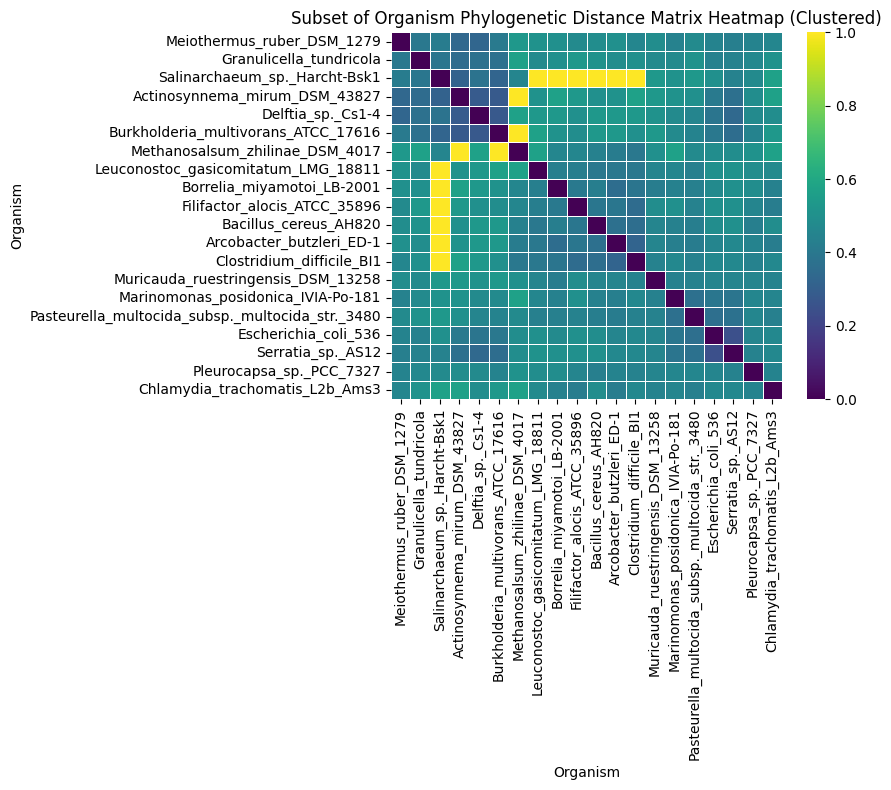

In [132]:
subset_organisms = distance_mat_df.index[:20]
subset_distance_matrix = distance_mat_df.loc[subset_organisms, subset_organisms].copy() # Use .copy() to avoid SettingWithCopyWarning

# Perform hierarchical clustering
condensed_distance = squareform(subset_distance_matrix, checks=False) # checks=False to handle potential NaNs/Infs if not already masked
linked = linkage(condensed_distance, 'weighted') # Use 'weighted' linkage

order = dendrogram(linked, no_plot=True)['leaves']
reordered_distance_matrix = subset_distance_matrix.iloc[order, order]

# Plot the heatmap
plt.figure(figsize=(9, 8))
sns.heatmap(reordered_distance_matrix, cmap="viridis", annot=False, fmt=".2f", linewidths=.5, annot_kws={"size": 8}) # Add mask and adjust annot_kws for readability
plt.title('Subset of Organism Phylogenetic Distance Matrix Heatmap (Clustered)')
plt.xlabel('Organism')
plt.ylabel('Organism')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

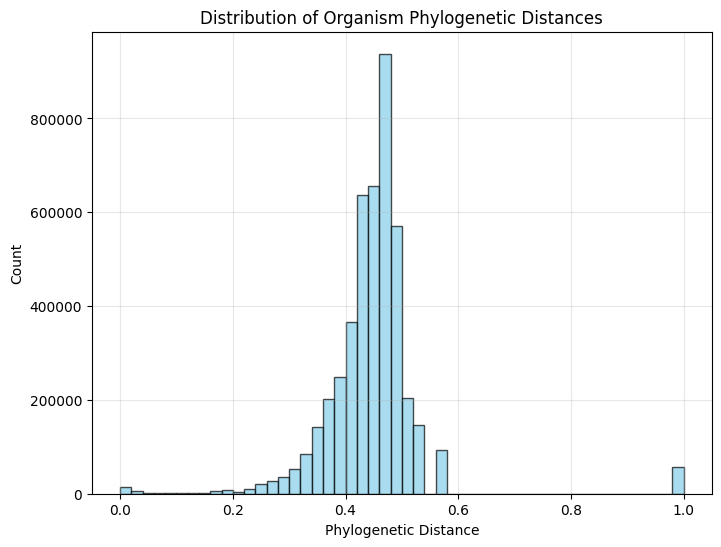

In [133]:
# Plot a histogram of organism distances

# Extract unique distances from the phylogenetic distance matrix (excluding lower triangle)
upper_triangle = distance_mat_df.where(np.triu(np.ones(distance_mat_df.shape), k=0).astype(bool))

# Flatten the upper triangle and drop NaN values (which correspond to the lower triangle and diagonal)
distances = distance_mat_df.stack().values

# Filter out -1 values which indicate missing data or errors
distances = distances[distances != -1]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, density=False, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Phylogenetic Distance')
plt.ylabel('Count')
plt.title('Distribution of Organism Phylogenetic Distances')
plt.grid(True, alpha=0.3)
plt.show()

## Train/Val/Test Split (Old)

### Identify Organism Clusters based on Phylogenetic Distance

In [ ]:
# # --- Load data ---
# p2cs_pairs_df_path = '/zdata/user-data/noam/data/p2cs/embeddings/esm3-medium/all_embeddings/p2cs_hk_rr_pairs_esm3-medium-2024-08.pkl'
# p2cs_pairs_df = pd.read_pickle(p2cs_pairs_df_path)
# p2cs_pairs_df['proximity_group_size'] = (
#     p2cs_pairs_df.groupby('proximity_group')['proximity_group'].transform('count')
# )

# unique_organisms = [org.replace(' ', '_') for org in p2cs_pairs_df['organism'].unique()]
# organisms_in_common = list(set(unique_organisms) & set(distance_mat_df.index))
# phylogenetic_distance_subset = distance_mat_df.loc[organisms_in_common, organisms_in_common]

# print(f"Created phylogenetic distance subset with {len(organisms_in_common)} organisms.")

# # --- Graph clustering ---
# distance_threshold = 0.1
# G = nx.Graph()
# G.add_nodes_from(phylogenetic_distance_subset.index)

# print(f"Creating graph with {len(G.nodes)} nodes.")
# for i, org1 in enumerate(phylogenetic_distance_subset.index):
#     for j, org2 in enumerate(phylogenetic_distance_subset.columns[i+1:], start=i+1):
#         d = phylogenetic_distance_subset.iat[i, j]
#         if d != -1 and np.isfinite(d) and d <= distance_threshold:
#             G.add_edge(org1, org2)

# organism_clusters = list(nx.connected_components(G))
# print(f"\nIdentified {len(organism_clusters)} organism clusters (threshold={distance_threshold}).")

# cluster_sizes = [len(c) for c in organism_clusters]
# print(f"Cluster sizes (first 10): {cluster_sizes[:10]}")
# print(f"Min: {np.min(cluster_sizes)}, Max: {np.max(cluster_sizes)}, Mean: {np.mean(cluster_sizes):.2f}")

# # --- Cluster mapping ---
# organism_to_cluster_id = {
#     org: cid for cid, cluster in enumerate(organism_clusters) for org in cluster
# }
# p2cs_pairs_df['cluster_id'] = p2cs_pairs_df['organism'].map(organism_to_cluster_id)

# # --- Handle unassigned organisms ---
# missing_orgs = p2cs_pairs_df[p2cs_pairs_df['cluster_id'].isna()]['organism'].unique()
# if len(missing_orgs):
#     print(f"\n{len(missing_orgs)} organisms not in distance subset. Examples: {missing_orgs[:5]}")
#     next_id = len(organism_clusters)
#     for org in missing_orgs:
#         p2cs_pairs_df.loc[p2cs_pairs_df['organism'] == org, 'cluster_id'] = next_id
#         next_id += 1
#     print(f"Assigned unique cluster IDs. Total clusters: {next_id}")

# display(p2cs_pairs_df.head())

Created phylogenetic distance subset with 2036 organisms.
Creating graph with 2036 nodes.

Identified 1087 organism clusters (threshold=0.1).
Cluster sizes (first 10): [15, 13, 1, 1, 1, 3, 1, 22, 47, 2]
Min: 1, Max: 59, Mean: 1.87

2647 organisms not in distance subset. Examples: ['Actinobacillus succinogenes 130Z' 'Burkholderia ambifaria MC40-6'
 'Streptococcus lutetiensis 033' 'Burkholderia pseudomallei 1710b'
 'Ammonifex degensii KC4']
Assigned unique cluster IDs. Total clusters: 3734


proximity_group                          organism        hk_gene  \
0                2  Actinobacillus succinogenes 130Z      Asuc_0782   
1                5  Actinobacillus succinogenes 130Z      Asuc_1364   
2                6  Actinobacillus succinogenes 130Z      Asuc_1720   
3                7     Burkholderia ambifaria MC40-6  BamMC406_0032   
4               10     Burkholderia ambifaria MC40-6  BamMC406_0182   

         rr_gene                                       hk_embedding  \
0      Asuc_0781  [0.0011588528286665678, 0.01809774339199066, -...   
1      Asuc_1363  [0.021759066730737686, 0.012713533826172352, -...   
2      Asuc_1721  [-0.001734129968099296, -0.011823820881545544,...   
3  BamMC406_0031  [0.06412381678819656, 0.0014582494040951133, -...   
4  BamMC406_0181  [0.08152365684509277, -0.013532615266740322, -...   

                                        rr_embedding  proximity_group_size  \
0  [0.007380485534667969, 0.094380684196949, -0.1...                     1   
1  [0.020951153710484505, 0.0931614488363266, -0....                     1   
2  [-0.008336775936186314, 0.03139081597328186, -...                     1   
3  [-0.0009646646794863045, 0.10316631942987442, ...                     1   
4  [0.027939323335886, 0.09411260485649109, -0.08...                     1   

   cluster_id  
0      1087.0  
1      1087.0  
2      1087.0  
3      1088.0  
4      1088.0

### Assign Clusters to Splits

In [ ]:
# # Step 3: Assign Clusters to Splits

# # Get unique cluster IDs and their total number of proteins
# cluster_sizes_df = p2cs_pairs_df.groupby('cluster_id').size().reset_index(name='cluster_protein_count')

# # Calculate the total number of proteins in the dataset
# total_proteins = cluster_sizes_df['cluster_protein_count'].sum()

# # Calculate the target number of proteins for each split
# target_train_proteins = int(TRAIN_FRAC * total_proteins)
# target_val_proteins = int(VAL_FRAC * total_proteins)
# target_test_proteins = total_proteins - target_train_proteins - target_val_proteins  # Ensure total adds up

# # ---- Shuffle clusters and partition ----
# # Set a random seed if reproducibility is required
# shuffle_seed = 42
# rng = random.Random(shuffle_seed)

# cluster_ids = cluster_sizes_df['cluster_id'].tolist()
# cluster_protein_counts = cluster_sizes_df['cluster_protein_count'].tolist()
# cluster_items = list(zip(cluster_ids, cluster_protein_counts))
# rng.shuffle(cluster_items)

# # Find the two indices at which to split for approximation to target ratios
# best_diff = float('inf')
# best_split = (None, None)

# cumulative = [0]
# for cid, cnt in cluster_items:
#     cumulative.append(cumulative[-1] + cnt)

# n_clusters = len(cluster_items)
# # Find i such that cumulative[i] is closest to target_train_proteins
# i = min(range(1, n_clusters-1), key=lambda idx: abs(cumulative[idx] - target_train_proteins))

# # Given i, find j such that cumulative[j] - cumulative[i] is closest to target_val_proteins
# j = min(range(i+1, n_clusters), key=lambda idx: abs((cumulative[idx] - cumulative[i]) - target_val_proteins))

# # Now i and j are the split indices

# train_cluster_ids = [cluster_items[k][0] for k in range(0, i)]
# val_cluster_ids   = [cluster_items[k][0] for k in range(i, j)]
# test_cluster_ids  = [cluster_items[k][0] for k in range(j, n_clusters)]

# # Get protein counts for each split
# split_current_counts = {
#     "train": sum(cluster_items[k][1] for k in range(0, i)),
#     "val":   sum(cluster_items[k][1] for k in range(i, j)),
#     "test":  sum(cluster_items[k][1] for k in range(j, n_clusters))
# }
# split_targets = {'train': target_train_proteins, 'val': target_val_proteins, 'test': target_test_proteins}
# split_cluster_lists = {'train': train_cluster_ids, 'val': val_cluster_ids, 'test': test_cluster_ids}

# # Print summary of assignment
# print("\nCluster Assignment Summary:")
# for split in ['train', 'val', 'test']:
#     print(f"{split.capitalize()} set:")
#     print(f"  Number of clusters: {len(split_cluster_lists[split])}")
#     print(f"  Number of proteins: {split_current_counts[split]} (Target: {split_targets[split]})")

# # Verify that no cluster is split across sets
# assigned_clusters = set(train_cluster_ids + val_cluster_ids + test_cluster_ids)
# all_original_clusters = set(cluster_sizes_df['cluster_id'].unique())

# if assigned_clusters == all_original_clusters:
#     print("\nVerification successful: All clusters assigned to exactly one split.")
# else:
#     print("\nVerification failed: Some clusters were not assigned correctly.")
#     print(f"Clusters not assigned: {all_original_clusters - assigned_clusters}")


Cluster Assignment Summary:
Train set:
  Number of clusters: 2267
  Number of proteins: 35837 (Target: 35841)
Val set:
  Number of clusters: 126
  Number of proteins: 2108 (Target: 2108)
Test set:
  Number of clusters: 254
  Number of proteins: 4222 (Target: 4218)

Verification successful: All clusters assigned to exactly one split.


In [ ]:
# # Step 4: Filter DataFrames based on assigned clusters

# print("Filtering dataframe based on cluster assignments...")

# # Create boolean masks for each split
# train_mask = p2cs_pairs_df['cluster_id'].isin(train_cluster_ids)
# val_mask = p2cs_pairs_df['cluster_id'].isin(val_cluster_ids)
# test_mask = p2cs_pairs_df['cluster_id'].isin(test_cluster_ids)

# # Filter the dataframe to create the split dataframes
# train_df = p2cs_pairs_df[train_mask].copy()
# val_df = p2cs_pairs_df[val_mask].copy()
# test_df = p2cs_pairs_df[test_mask].copy()

# print(f"Created train_df with {len(train_df)} rows.")
# print(f"Created val_df with {len(val_df)} rows.")
# print(f"Created test_df with {len(test_df)} rows.")

# # Verify that the splits are mutually exclusive and cover all data points
# total_rows_in_splits = len(train_df) + len(val_df) + len(test_df)
# if total_rows_in_splits == len(p2cs_pairs_df):
#     print("\nVerification successful: Split dataframes contain all original data points and are mutually exclusive.")
# else:
#     print(f"\nVerification failed: Total rows in splits ({total_rows_in_splits}) does not match original dataframe rows ({len(p2cs_pairs_df)}).")
#     # Identify missing or overlapping rows if needed for debugging
#     all_split_indices = set(train_df.index) | set(val_df.index) | set(test_df.index)
#     original_indices = set(p2cs_pairs_df.index)
#     missing_indices = original_indices - all_split_indices
#     print(f"Number of missing indices: {len(missing_indices)}")

# # Save to pickle file
# print("Saving to pickle file...")
# train_df.to_pickle('/zdata/user-data/noam/data/p2cs/embeddings/esm3-medium/train_validation_test_split/train_df_esm3-medium-2024-08.pkl')
# val_df.to_pickle('/zdata/user-data/noam/data/p2cs/embeddings/esm3-medium/train_validation_test_split/val_df_esm3-medium-2024-08.pkl')
# test_df.to_pickle('/zdata/user-data/noam/data/p2cs/embeddings/esm3-medium/train_validation_test_split/test_df_esm3-medium-2024-08.pkl')

Filtering dataframe based on cluster assignments...
Created train_df with 35837 rows.
Created val_df with 2108 rows.
Created test_df with 4222 rows.

Verification successful: Split dataframes contain all original data points and are mutually exclusive.
Saving to pickle file...


## Load & Create datasets

In [134]:
def prepare_dataset(file_path, hk_mean=None, hk_std=None, scale_input=True):
    """
    Loads a dataframe from a file path, extracts embeddings, organisms,
    indices, hk_genes, and rr_genes, scales the HK embeddings (optionally),
    and creates a CognateDataset.
    Deletes the loaded dataframe to free up memory.

    Args:
        file_path (str): The path to the dataframe file (e.g., pickle).
        hk_mean (np.ndarray, optional): Mean of training HK embeddings for scaling.
                                       If None, calculated from the input df if scaling is enabled.
        hk_std (np.ndarray, optional): Standard deviation of training HK embeddings for scaling.
                                      If None, calculated from the input df if scaling is enabled.
        scale_embeddings (bool): If True, scale the HK embeddings using mean and standard deviation.

    Returns:
        tuple: (dataset, organisms, indices, hk_genes, rr_genes, hk_mean, hk_std)
               where hk_mean and hk_std are returned if calculated from this df.
    """
    df = pd.read_pickle(file_path)

    hk_array = np.array(df['hk_embedding'].tolist())
    rr_array = np.array(df['rr_embedding'].tolist())
    organisms = [org.replace(' ', '_') for org in df['organism'].tolist()]
    # Keep the original index as a list
    indices = df.index.tolist()
    hk_genes = df['hk_gene'].tolist()
    rr_genes = df['rr_gene'].tolist()
    # Scale the embeddings if the flag is True
    if scale_input:
        if hk_mean is None or hk_std is None:
            # Calculate mean and standard deviation from this dataframe (presumably training)
            hk_mean = hk_array.mean(axis=0)
            hk_std = hk_array.std(axis=0)

        # Apply scaling
        # Add epsilon for numerical stability in case of zero std
        hk_scaled = (hk_array - hk_mean) / (hk_std + 1e-8)
    else:
        # If not scaling, use the original embeddings
        hk_scaled = hk_array
        hk_mean = None # Ensure mean and std are None if not scaled
        hk_std = None


    # Create Dataset instance with indices, organisms, hk_genes, and rr_genes
    dataset = CognateDataset(
        hk_embeddings=hk_scaled,
        rr_embeddings=rr_array,
        organisms=organisms,
        indices=indices, # Pass the collected indices
        hk_genes=hk_genes,
        rr_genes=rr_genes
    )

    # Delete the input dataframe to free up memory
    del df
    gc.collect()

    return dataset, organisms, indices, hk_genes, rr_genes, hk_mean, hk_std

In [135]:
%%memit
# Prepare datasets and get scaling parameters from the training set
train_dataset, organisms_train, indices_train, hk_genes_train, rr_genes_train, hk_train_mean, hk_train_std = prepare_dataset(TRAIN_FILE_PATH, scale_input=SCALE_INPUT)

# Use the mean and std from the training set to scale validation and test sets
val_dataset, organisms_val, indices_val, hk_genes_val, rr_genes_val, _, _ = prepare_dataset(VAL_FILE_PATH, hk_mean=hk_train_mean, hk_std=hk_train_std, scale_input=SCALE_INPUT)
test_dataset, organisms_test, indices_test, hk_genes_test, rr_genes_test, _, _ = prepare_dataset(TEST_FILE_PATH, hk_mean=hk_train_mean, hk_std=hk_train_std, scale_input=SCALE_INPUT)

# Create DataLoaders
# Use custom batch sampler for training
train_sampler = OrganismBatchSampler(organisms_train, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2)

# Use regular DataLoader for validation and test (no need for organism-complete batches for evaluation)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Datasets and DataLoaders created.")

test_df = pd.read_pickle(TEST_FILE_PATH)

print("Test Dataframe loaded.")

Datasets and DataLoaders created.
Test Dataframe loaded.
peak memory: 23412.20 MiB, increment: 8761.93 MiB


In [136]:
# Test the new organism-complete batching
print("Testing organism-complete batching...")
test_batches = 0
batch_stats = []
all_complete_list = [] # Renamed from 'all' to avoid conflict

for batch_data in train_dataloader:
    (hk_batch, rr_batch, organisms_batch, hk_genes_batch, rr_genes_batch), indices_batch = batch_data

    # Analyze this batch
    unique_organisms = list(set(organisms_batch))
    organism_counts = {org: organisms_batch.count(org) for org in unique_organisms}

    # Check if each organism is complete (all proteins present)
    all_organisms_complete = True
    for org in unique_organisms:
        total_proteins_in_org = organisms_train.count(org)
        proteins_in_batch = organism_counts[org]
        if proteins_in_batch != total_proteins_in_org:
            all_organisms_complete = False
            break
    all_complete_list.append(all_organisms_complete) # Append to the list

    batch_stats.append({
        'batch_size': len(organisms_batch),
        'num_organisms': len(unique_organisms),
        'organism_counts': organism_counts,
        'all_complete': all_organisms_complete
    })

    test_batches += 1
    if test_batches >= 5:  # Test first 5 batches
        break

    print(f"Batch {test_batches}:")
    print(f"  Size: {len(organisms_batch)}")
    print(f"  Organisms: {len(unique_organisms)}")
    print(f"  Organism counts: {organism_counts}")
    print(f"  All organisms complete: {all_organisms_complete}")
    print()

# Overall statistics
print(f"Summary of first {test_batches} batches:")
print(f"  Average batch size: {np.mean([stats['batch_size'] for stats in batch_stats]):.2f}")
print(f"  Average organisms per batch: {np.mean([stats['num_organisms'] for stats in batch_stats]):.2f}")
print(f"  All batches have complete organisms: {builtins.all(all_complete_list)}") # Use builtins.all()
print()

Testing organism-complete batching...
Batch 1:
  Size: 1005
  Organisms: 76
  Organism counts: {np.str_('Clostridium_novyi_NT'): 15, np.str_('Pantoea_vagans_C9-1_plasmid_pPag1'): 1, np.str_('Streptococcus_pneumoniae_CGSP14'): 12, np.str_('Methylobacterium_nodulans_ORS_2060'): 23, np.str_('Streptococcus_suis_98HAH33'): 7, np.str_('Burkholderia_sp._YI23_plasmid_byi_1p'): 5, np.str_('Sinorhizobium_meliloti_Rm41'): 6, np.str_('Propionibacterium_acnes_TypeIA2_P.acn17'): 10, np.str_('Staphylococcus_aureus_subsp._aureus_55/2053'): 15, np.str_('Mycobacterium_kansasii_ATCC_12478'): 12, np.str_('Erwinia_amylovora_ATCC_49946_plasmid_1'): 7, np.str_('Pediococcus_pentosaceus_ATCC_25745'): 8, np.str_('Enterococcus_faecalis_OG1RF'): 13, np.str_('Desulfovibrio_desulfuricans_subsp._desulfuricans_str._ATCC_27774'): 11, np.str_('Lactobacillus_paracasei_subsp._paracasei_8700:2'): 10, np.str_('Enterococcus_faecium_DO'): 15, np.str_('Burkholderia_phymatum_STM815_plasmid_pBPHY01'): 9, np.str_('Chlamydia_trac

In [137]:
# Analyze organism size distribution
print("Analyzing organism size distribution...")

# Training set analysis
train_org_sizes = Counter(organisms_train)
org_sizes = list(train_org_sizes.values())

print(f"Training set organism statistics:")
print(f"  Total organisms: {len(train_org_sizes)}")
print(f"  Mean proteins per organism: {np.mean(org_sizes):.2f}")
print(f"  Median proteins per organism: {np.median(org_sizes):.2f}")
print(f"  Min proteins per organism: {np.min(org_sizes)}")
print(f"  Max proteins per organism: {np.max(org_sizes)}")
print(f"  Organisms with ≤ batch_size ({BATCH_SIZE}) proteins: {sum(1 for size in org_sizes if size <= BATCH_SIZE)}")
print(f"  Organisms with > batch_size proteins: {sum(1 for size in org_sizes if size > BATCH_SIZE)}")

# Calculate expected number of batches
total_batches = sum((size + BATCH_SIZE - 1) // BATCH_SIZE for size in org_sizes)
print(f"  Expected total batches: {total_batches}")

# Small organism analysis
small_orgs = [org for org, size in train_org_sizes.items() if size <= 10]
print(f"  Very small organisms (≤10 proteins): {len(small_orgs)}")
if len(small_orgs) > 0:
    print(f"    Examples: {small_orgs[:5]}")

Analyzing organism size distribution...
Training set organism statistics:
  Total organisms: 2267
  Mean proteins per organism: 15.81
  Median proteins per organism: 12.00
  Min proteins per organism: 1
  Max proteins per organism: 158
  Organisms with ≤ batch_size (1024) proteins: 2267
  Organisms with > batch_size proteins: 0
  Expected total batches: 2267
  Very small organisms (≤10 proteins): 1025
    Examples: ['Actinobacillus_succinogenes_130Z', 'Ammonifex_degensii_KC4', 'Campylobacter_jejuni_subsp._jejuni_81-176', 'Bifidobacterium_bifidum_S17', 'Synechocystis_sp._PCC_6803_plasmid_pSYSM_M']


## Instantiate Models

In [138]:
hk_vae = None
# hk_vae = VAE(input_dim=INPUT_DIM, latent_dim=INPUT_DIM).to(DEVICE)
# hk_vae.load_state_dict(torch.load(os.path.join(DATA_PATH, "model weights", "1536_model_weights_expert-river-36.pth"), map_location=torch.device(DEVICE)))
model = DualHeadAdapter(input_dim=INPUT_DIM, embed_dim=EMBED_DIM,
                        temperature=TEMP, gamma=GAMMA).to(DEVICE)
adversary = PhylogeneticAdversary(half_input_dim=EMBED_DIM,
                                  dropout=ADVERSARY_DROPOUT_FRAC, 
                                  lambda_param=ADVERSARY_LAMBDA,
                                  reverse_gradient=ENABLE_GRADIENT_REVERSAL)

# print model number of parameters
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
print(f"Adversary has {sum(p.numel() for p in adversary.parameters())} parameters")
print(f"Adversary lambda: {adversary.lambda_param}")

Model has 3639297 parameters
Adversary has 98817 parameters
Adversary lambda: 0.0


In [139]:
# # -----------------------------------
# # Test functions for gradient reversal

# def test_gradient_reversal(lambda_param=0.5):
#     """
#     Test function to verify that the gradient reversal layer correctly multiplies 
#     gradients by -lambda during backward pass.

#     Args:
#         lambda_param: The lambda parameter for gradient reversal

#     Returns:
#         bool: True if test passes, False otherwise
#     """
#     print(f"\nTesting gradient reversal with lambda={lambda_param}")

#     # Create a simple model with one parameter
#     class SimpleModel(nn.Module):
#         def __init__(self):
#             super().__init__()
#             self.weight = nn.Parameter(torch.tensor([2.0]))

#         def forward(self, x):
#             return self.weight * x

#     # Create input
#     x = torch.tensor([1.0], requires_grad=True)
#     model = SimpleModel()

#     # Get initial gradient (should be 1.0 since weight=2.0, x=1.0, output=2.0)
#     output_normal = model(x)
#     loss_normal = output_normal ** 2  # loss = 4.0
#     loss_normal.backward()
#     # Should be 4.0 (d/dw (w*x)^2 = 2*w*x*x = 2*2*1*1 = 4)
#     gradient_normal = model.weight.grad.clone()

#     # Reset gradients
#     model.weight.grad.zero_()
#     x.grad.zero_()

#     # Now test with gradient reversal
#     x2 = torch.tensor([1.0], requires_grad=True)
#     model2 = SimpleModel()

#     # Forward through gradient reversal
#     reversed_output = gradient_reversal(model2(x2), lambda_param)
#     loss_reversed = reversed_output ** 2  # loss = 4.0 (same forward value)
#     loss_reversed.backward()
#     gradient_reversed = model2.weight.grad.clone()

#     # With gradient reversal, we should get: gradient_reversed = -lambda * gradient_normal
#     expected_gradient = -lambda_param * gradient_normal
#     actual_gradient = gradient_reversed

#     print(f"Forward pass (no reversal): output={output_normal.item():.4f}")
#     print(f"Forward pass (with reversal): output={reversed_output.item():.4f}")
#     print(f"Normal gradient: {gradient_normal.item():.4f}")
#     print(f"Reversed gradient: {gradient_reversed.item():.4f}")
#     print(f"Expected reversed gradient: {expected_gradient.item():.4f}")
#     print(
#         f"Difference: {abs(actual_gradient.item() - expected_gradient.item()):.6f}")

#     # Check if they match (with small tolerance)
#     tolerance = 1e-6
#     test_passed = abs(actual_gradient.item() -
#                       expected_gradient.item()) < tolerance

#     if test_passed:
#         print("✓ Test PASSED: Gradient reversal works correctly!")
#     else:
#         print("✗ Test FAILED: Gradient reversal not working as expected.")

#     return test_passed


# def test_gradient_reversal_with_adversary(lambda_param=10, test_df=None, device='cpu'):
#     """
#     Test gradient reversal using actual DualHeadAdapter and PhylogeneticAdversary models.
#     Verifies that gradients are correctly scaled by -lambda.
#     Also checks that the outputs are identical for forward pass between reversed and unreversed models.

#     Args:
#         lambda_param: The lambda parameter for gradient reversal
#         test_df: DataFrame with test data containing 'hk_data', 'rr_data', 'organism' columns
#         device: Device to run the test on

#     Returns:
#         bool: True if test passes, False otherwise
#     """
#     print(
#         f"\nTesting gradient reversal with actual models (lambda={lambda_param})")

#     if test_df is None:
#         print("No test_df provided, creating dummy data...")
#         # Create dummy data if no test_df provided
#         batch_size = 2
#         hk_data = torch.randn(batch_size, 2560)  # Typical HK input dimension
#         rr_data = torch.randn(batch_size, 2560)  # Typical RR input dimension
#         organism = ['E.coli', 'B.subtilis']
#     else:
#         # Extract data from test_df
#         if len(test_df) < 2:
#             raise ValueError(
#                 "test_df must have at least 2 rows for comparison")

#         # Take first 2 samples for comparison - use the SAME data for both models
#         hk_data = torch.tensor(
#             test_df['hk_embedding'].iloc[:2].tolist(), dtype=torch.float32)
#         rr_data = torch.tensor(
#             test_df['rr_embedding'].iloc[:2].tolist(), dtype=torch.float32)
#         organism = test_df['organism'].iloc[:2].tolist()
#         batch_size = len(organism)

#     # Move data to device
#     hk_data = hk_data.to(device)
#     rr_data = rr_data.to(device)

#     # Create actual models with dropout=0 for deterministic behavior
#     main_model_with_reversal = DualHeadAdapter(
#         input_dim=2560, embed_dim=256, dropout=0.0)
#     main_model_without_reversal = DualHeadAdapter(
#         input_dim=2560, embed_dim=256, dropout=0.0)

#     # Copy weights to make them identical
#     main_model_without_reversal.load_state_dict(
#         main_model_with_reversal.state_dict())

#     # Set both models to eval mode to ensure deterministic behavior
#     main_model_with_reversal.eval()
#     main_model_without_reversal.eval()

#     # Create adversaries with dropout=0 for deterministic behavior
#     adversary_with_reversal = PhylogeneticAdversary(
#         half_input_dim=256, lambda_param=lambda_param, reverse_gradient=True, dropout=0.0)
#     adversary_without_reversal = PhylogeneticAdversary(
#         half_input_dim=256, lambda_param=1.0, reverse_gradient=False, dropout=0.0)  # No reversal effect

#     # Copy weights to make adversaries identical
#     adversary_without_reversal.load_state_dict(
#         adversary_with_reversal.state_dict())
#     adversary_without_reversal.lambda_param = 1.0  # Ensure no reversal effect
#     adversary_without_reversal.reverse_gradient = False

#     # Set both adversaries to eval mode to ensure deterministic behavior
#     adversary_with_reversal.eval()
#     adversary_without_reversal.eval()

#     # Move models to device
#     main_model_with_reversal = main_model_with_reversal.to(device)
#     main_model_without_reversal = main_model_without_reversal.to(device)
#     adversary_with_reversal = adversary_with_reversal.to(device)
#     adversary_without_reversal = adversary_without_reversal.to(device)

#     # Set models to training mode for gradient computation
#     main_model_with_reversal.train()
#     main_model_without_reversal.train()
#     adversary_with_reversal.train()
#     adversary_without_reversal.train()

#     # Create dummy organism and gene data for the loss functions
#     organism_list = ['E.coli', 'B.subtilis'] if batch_size == 2 else [
#         'E.coli', 'B.subtilis', 'S.cerevisiae']
#     hk_genes = ['hk1', 'hk2'] if batch_size == 2 else ['hk1', 'hk2', 'hk3']
#     rr_genes = ['rr1', 'rr2'] if batch_size == 2 else ['rr1', 'rr2', 'rr3']

#     # Create ground truth distance matrix for adversary loss
#     ground_truth_distances = build_same_organism_mask(organism_list).to(device)

#     # === WITH GRADIENT REVERSAL ===
#     hk_emb1, rr_emb1, temperature1, gamma1 = main_model_with_reversal(
#         hk_data, rr_data)

#     # Use actual adversary loss function
#     pred_hk1 = hk_emb1.unsqueeze(1).expand(-1, batch_size, -1)
#     pred_rr1 = rr_emb1.unsqueeze(0).expand(batch_size, -1, -1)
#     predicted_distances1 = adversary_with_reversal(
#         pred_hk1, pred_rr1).squeeze(-1)
#     if predicted_distances1.dim() == 3:
#         predicted_distances1 = predicted_distances1.squeeze(-1)

#     adversary_loss1 = adversary_loss_excluding_diagonal(
#         predicted_distances1, ground_truth_distances)
#     # Save for comparison before backward
#     adv_out1_detach = predicted_distances1.detach().cpu().clone()
#     adversary_loss1.backward()

#     # Get gradients from the main model
#     gradient_with_reversal = main_model_with_reversal.hk_head[0].weight.grad.clone(
#     )

#     # === WITHOUT GRADIENT REVERSAL ===
#     # Use the second main model (identical weights)
#     hk_emb2, rr_emb2, temperature2, gamma2 = main_model_without_reversal(
#         hk_data, rr_data)

#     # Use actual adversary loss function
#     pred_hk2 = hk_emb2.unsqueeze(1).expand(-1, batch_size, -1)
#     pred_rr2 = rr_emb2.unsqueeze(0).expand(batch_size, -1, -1)
#     predicted_distances2 = adversary_without_reversal(
#         pred_hk2, pred_rr2).squeeze(-1)
#     if predicted_distances2.dim() == 3:
#         predicted_distances2 = predicted_distances2.squeeze(-1)

#     adversary_loss2 = adversary_loss_excluding_diagonal(
#         predicted_distances2, ground_truth_distances)
#     # Save for comparison before backward
#     adv_out2_detach = predicted_distances2.detach().cpu().clone()
#     adversary_loss2.backward()

#     # Get gradients from the main model
#     gradient_without_reversal = main_model_without_reversal.hk_head[0].weight.grad.clone(
#     )

#     # Check: Are the main model outputs (embeddings) equal? (They should be identical)
#     hk_emb_diff = torch.max(
#         torch.abs(hk_emb1.detach().cpu() - hk_emb2.detach().cpu())).item()
#     rr_emb_diff = torch.max(
#         torch.abs(rr_emb1.detach().cpu() - rr_emb2.detach().cpu())).item()

#     # Check: Are the adversary outputs equal? (They should be identical since same input)
#     adv_out_diff = torch.max(
#         torch.abs(adv_out1_detach - adv_out2_detach)).item()

#     emb_tolerance = 1e-6
#     outputs_equal = (hk_emb_diff < emb_tolerance) and (
#         rr_emb_diff < emb_tolerance) and (adv_out_diff < emb_tolerance)

#     print(f"Max abs difference in HK embeddings: {hk_emb_diff:.6g}")
#     print(f"Max abs difference in RR embeddings: {rr_emb_diff:.6g}")
#     print(f"Max abs difference in adversary outputs: {adv_out_diff:.6g}")

#     if outputs_equal:
#         print("✓ Forward output test PASSED: all outputs are identical between reversal and non-reversal!")
#     else:
#         print("✗ Forward output test FAILED: outputs are not identical!")

#     # Now check gradients

#     # Expected: gradient_with_reversal = -lambda * gradient_without_reversal
#     expected_gradient = -lambda_param * gradient_without_reversal
#     actual_gradient = gradient_with_reversal

#     print(f"Adversary loss (with reversal): {adversary_loss1.item():.6f}")
#     print(f"Adversary loss (without reversal): {adversary_loss2.item():.6f}")
#     print(f"Gradient shape: {actual_gradient.shape}")
#     print(
#         f"First gradient value (with reversal): {actual_gradient[0, 0].item():.6f}")
#     print(
#         f"First gradient value (without reversal): {gradient_without_reversal[0, 0].item():.6f}")
#     print(
#         f"Expected gradient (with reversal): {expected_gradient[0, 0].item():.6f}")
#     print(
#         f"Difference: {abs(actual_gradient[0, 0].item() - expected_gradient[0, 0].item()):.6f}")

#     # Check gradient correctness
#     tolerance = 1e-5
#     max_diff = torch.max(torch.abs(actual_gradient - expected_gradient)).item()
#     grad_test_passed = max_diff < tolerance

#     if grad_test_passed:
#         print(f"✓ Test PASSED: Gradient reversal correctly scales by -lambda!")
#         print(f"  Max difference: {max_diff:.8f} < tolerance: {tolerance}")
#     else:
#         print(f"✗ Test FAILED: Gradient reversal not working correctly.")
#         print(f"  Max difference: {max_diff:.8f} >= tolerance: {tolerance}")

#     all_passed = grad_test_passed and outputs_equal

#     return all_passed


# if __name__ == "__main__":
#     # Run tests
#     test1_passed = test_gradient_reversal(lambda_param=0.5)
#     test2_passed = test_gradient_reversal_with_adversary(
#         lambda_param=10, test_df=None)

#     print(f"\n{'='*60}")
#     print(f"Test Results:")
#     print(
#         f"  Basic gradient reversal test: {'PASSED' if test1_passed else 'FAILED'}")
#     print(
#         f"  Adversary gradient reversal test: {'PASSED' if test2_passed else 'FAILED'}")
#     print(f"{'='*60}")


Evaluating on Test Set: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


Test set loss: 7.2797



Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


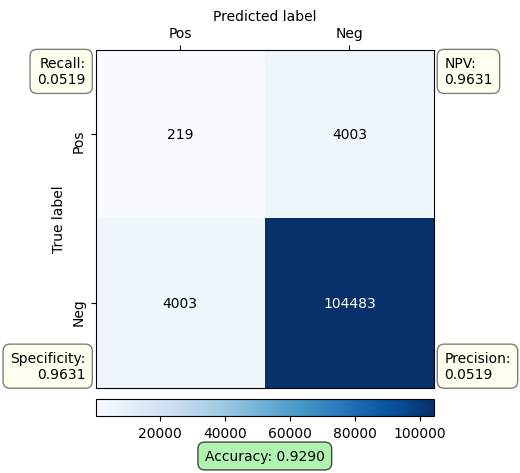


Confusion Matrix and Metrics:
TP: 219, TN: 104483, FP: 4003, FN: 4003
Accuracy: 0.9290
Precision: 0.0519
Recall (Sensitivity): 0.0519
Specificity: 0.9631
NPV: 0.9631


Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


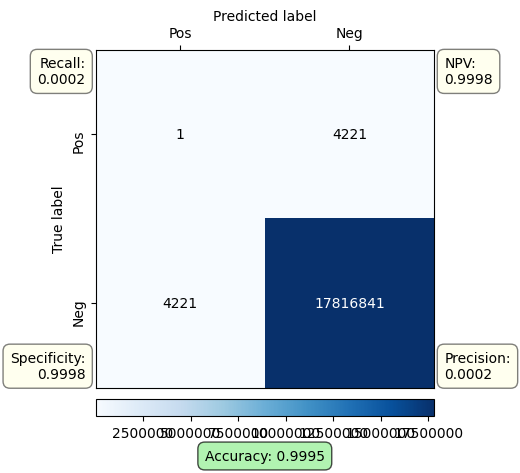


Confusion Matrix and Metrics (Unrestricted):
TP: 1, TN: 17816841, FP: 4221, FN: 4221
Accuracy: 0.9995
Precision: 0.0002
Recall (Sensitivity): 0.0002
Specificity: 0.9998
NPV: 0.9998


In [140]:
# Evaluate the untrained model on the test set
test_loss = evaluate_model(model, test_dataloader, device=DEVICE, gamma=GAMMA, hk_vae=None)
print(f"Test set loss: {test_loss:.4f}\n")

K = 1
T = None

# Evaluate TopK per organism
results_restricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=True, hk_vae=None)
print("\nConfusion Matrix and Metrics:")
print(f"TP: {results_restricted['TP']}, TN: {results_restricted['TN']}, FP: {results_restricted['FP']}, FN: {results_restricted['FN']}")
print(f"Accuracy: {results_restricted['accuracy']:.4f}")
print(f"Precision: {results_restricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_restricted['recall']:.4f}")
print(f"Specificity: {results_restricted['specificity']:.4f}")
print(f"NPV: {results_restricted['npv']:.4f}")

# Evaluate TopK unrestricted
results_unrestricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=False, hk_vae=None)
print("\nConfusion Matrix and Metrics (Unrestricted):")
print(f"TP: {results_unrestricted['TP']}, TN: {results_unrestricted['TN']}, FP: {results_unrestricted['FP']}, FN: {results_unrestricted['FN']}")
print(f"Accuracy: {results_unrestricted['accuracy']:.4f}")
print(f"Precision: {results_unrestricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_unrestricted['recall']:.4f}")
print(f"Specificity: {results_unrestricted['specificity']:.4f}")
print(f"NPV: {results_unrestricted['npv']:.4f}")

In [141]:
adversary_accuracy = evaluate_adversary_accuracy(adversary=adversary, main_model=model, dataloader=test_dataloader, device=DEVICE)
print(f"Adversary accuracy: {adversary_accuracy}")

Evaluating Adversary Accuracy: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]

Adversary accuracy: (0.48162914892099334, np.float64(0.9371940438829702))


## Create Optimizers & Schedulers

In [142]:
# Setup optimizer

# Separate parameters for weight decay (exclude bias and normalization parameters)
def get_parameter_groups(model, weight_decay):
    """
    Separate model parameters into two groups:
    1. Parameters that should have weight decay (weights)
    2. Parameters that should not have weight decay (bias, normalization parameters)
    """
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
            
        # Exclude bias and normalization parameters from weight decay
        if any(nd in name.lower() for nd in ['bias', 'norm', 'bn', 'ln']):
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    return [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]

# Setup optimizer with proper parameter grouping
optimizer = torch.optim.AdamW(
    get_parameter_groups(model, WEIGHT_DECAY), 
    lr=LR
)

# Optimizer for adversary (only train adversary, not the main model)
adversary_optimizer = torch.optim.AdamW(
    get_parameter_groups(adversary, ADVERSARY_WEIGHT_DECAY), 
    lr=ADVERSARY_LEARNING_RATE
)

# Scheduler with warmup + cosine annealing
num_training_steps = len(train_dataloader) * EPOCHS
num_warmup_steps = int(WARMUP_FRAC * num_training_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# # Scheduler with warmup + linear decay
# warmup_steps = int(WARMUP_FRAC * len(train_dataloader) * EPOCHS)
# decay_steps = len(train_dataloader) * EPOCHS - warmup_steps
# scheduler = WarmupThenLinearDecay(
#     optimizer,
#     warmup_steps=warmup_steps,
#     decay_steps=decay_steps,
#     eta_min=1e-7 # Small minimum learning rate
# )

# # Scheduler with warmup + cosine annealing + warm restarts
# warmup_steps = int(0.1 * len(train_dataloader) * EPOCHS)  # 10% warmup
# scheduler = WarmupThenCosineRestarts(
#     optimizer,
#     warmup_steps=warmup_steps,
#     T_0=len(train_dataloader) * T0,  # First restart after 30 epochs
#     T_mult=T_MULT,
#     eta_min=ETA_MIN
# )
# print(f"Total training steps: {warmup_steps + decay_steps}")
# print(f"Warmup steps: {warmup_steps}")
# print(f"Decay steps: {decay_steps}")

## Train Contrastive Heads

In [105]:
subsampled_train_dataset = train_dataset.sample(MAX_PAIRS)
subsampled_train_dataloader = DataLoader(subsampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model_params = PARAMS_DICT[BASE_MODEL]

# Check if 'trained_weights_filename' exists for the chosen BASE_MODEL
if 'trained_weights_filename' not in model_params:
    print(f"Error: 'trained_weights_filename' not found for BASE_MODEL '{BASE_MODEL}' in PARAMS_DICT.")
else:
    model_filename = model_params['trained_weights_filename']
    model_path = os.path.join('.', 'model_weights', 'best_sunny-resonance-118.pth')

    state_dict = torch.load(model_path, map_location=torch.device(DEVICE))
    model.load_state_dict(state_dict)
    print(f"Model weights loaded successfully from {model_path}")


Model weights loaded successfully from ./model_weights/best_sunny-resonance-118.pth


In [106]:
 # Clear cache again before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Force garbage collection again
gc.collect()

# # Delete train, test, val dfs
# if 'train_df' in locals(): del train_df
# if 'val_df' in locals(): del val_df
# if 'test_df' in locals(): del test_df

23336

In [107]:
# Train with adversarial training
trained_model = train(
    model=model,
    train_dataloader=subsampled_train_dataloader, # train_dataloader,  # TODO: reinstate
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    device=DEVICE,
    save_dir="model_weights",
    gamma=GAMMA,
    hk_vae=None,
    adversary=adversary,
    adversary_optimizer=adversary_optimizer,
    separate_adversary_in_warmup=SEPARATE_ADVERSARY_IN_WARMUP,
    separate_adversary_always=SEPARATE_ADVERSARY_ALWAYS,
    warmup_epochs=WARMUP_EPOCHS,
    adversary_batch_size=ADVERSARY_BATCH_SIZE,
    adversary_lambda=ADVERSARY_LAMBDA,
    # distance_mat_df=distance_mat_df,
    evaluate_accuracy=EVALUATE_ACCURACY,
    freeze_dualheadadapter=FREEZE_MAIN_MODEL,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    min_delta=MIN_DELTA,
    mask_inter_organism_loss=MASK_INTER_ORGANISM_LOSS
)

DualHeadAdapter model frozen - only training adversary
Using binary same-organism mask for adversary training (0=same organism, 1=different)
Adversary will train separately always (detached gradients)


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


Epoch 1/100
  Adversary Loss: 1.032753;   Adversary Val Loss: 0.151705;   Adversary Val Accuracy: 0.5136;   Adversary Negative Ratio: 0.8801;   Combined Loss: 1.032753
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch 2/100
  Adversary Loss: 1.018943;   Adversary Val Loss: 0.151239;   Adversary Val Accuracy: 0.4916;   Adversary Negative Ratio: 0.8804;   Combined Loss: 1.018943
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch 3/100
  Adversary Loss: 1.005987;   Adversary Val Loss: 0.151798;   Adversary Val Accuracy: 0.5034;   Adversary Negative Ratio: 0.8800;   Combined Loss: 1.005987
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch 4/100
  Adversary Loss: 0.991599;   Adversary Val Loss: 0.150681;   Adversary Val Accuracy: 0.4916;   Adversary Negative Ratio: 0.8808;   Combined Loss: 0.991599
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


Epoch 5/100
  Adversary Loss: 0.978557;   Adversary Val Loss: 0.151806;   Adversary Val Accuracy: 0.4908;   Adversary Negative Ratio: 0.8800;   Combined Loss: 0.978557
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch 6/100
  Adversary Loss: 0.966628;   Adversary Val Loss: 0.149660;   Adversary Val Accuracy: 0.5059;   Adversary Negative Ratio: 0.8815;   Combined Loss: 0.966628
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]


Epoch 7/100
  Adversary Loss: 0.954135;   Adversary Val Loss: 0.150044;   Adversary Val Accuracy: 0.4926;   Adversary Negative Ratio: 0.8813;   Combined Loss: 0.954135
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


Epoch 8/100
  Adversary Loss: 0.941391;   Adversary Val Loss: 0.149961;   Adversary Val Accuracy: 0.4950;   Adversary Negative Ratio: 0.8813;   Combined Loss: 0.941391
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


Epoch 9/100
  Adversary Loss: 0.929172;   Adversary Val Loss: 0.153149;   Adversary Val Accuracy: 0.4879;   Adversary Negative Ratio: 0.8791;   Combined Loss: 0.929172
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s]


Epoch 10/100
  Adversary Loss: 0.917479;   Adversary Val Loss: 0.152605;   Adversary Val Accuracy: 0.4896;   Adversary Negative Ratio: 0.8795;   Combined Loss: 0.917479
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 11/100
  Adversary Loss: 0.906056;   Adversary Val Loss: 0.154858;   Adversary Val Accuracy: 0.4975;   Adversary Negative Ratio: 0.8779;   Combined Loss: 0.906056
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch 12/100
  Adversary Loss: 0.892671;   Adversary Val Loss: 0.151233;   Adversary Val Accuracy: 0.4965;   Adversary Negative Ratio: 0.8805;   Combined Loss: 0.892671
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch 13/100
  Adversary Loss: 0.881615;   Adversary Val Loss: 0.149377;   Adversary Val Accuracy: 0.5184;   Adversary Negative Ratio: 0.8818;   Combined Loss: 0.881615
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 14/100
  Adversary Loss: 0.869143;   Adversary Val Loss: 0.152955;   Adversary Val Accuracy: 0.5009;   Adversary Negative Ratio: 0.8793;   Combined Loss: 0.869143
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch 15/100
  Adversary Loss: 0.857722;   Adversary Val Loss: 0.148122;   Adversary Val Accuracy: 0.4980;   Adversary Negative Ratio: 0.8827;   Combined Loss: 0.857722
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch 16/100
  Adversary Loss: 0.846280;   Adversary Val Loss: 0.153760;   Adversary Val Accuracy: 0.4844;   Adversary Negative Ratio: 0.8787;   Combined Loss: 0.846280
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch 17/100
  Adversary Loss: 0.834309;   Adversary Val Loss: 0.153407;   Adversary Val Accuracy: 0.5032;   Adversary Negative Ratio: 0.8790;   Combined Loss: 0.834309
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


Epoch 18/100
  Adversary Loss: 0.823261;   Adversary Val Loss: 0.150635;   Adversary Val Accuracy: 0.4957;   Adversary Negative Ratio: 0.8810;   Combined Loss: 0.823261
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 19/100
  Adversary Loss: 0.810877;   Adversary Val Loss: 0.147971;   Adversary Val Accuracy: 0.4716;   Adversary Negative Ratio: 0.8829;   Combined Loss: 0.810877
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch 20/100
  Adversary Loss: 0.798947;   Adversary Val Loss: 0.150137;   Adversary Val Accuracy: 0.5124;   Adversary Negative Ratio: 0.8814;   Combined Loss: 0.798947
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


Epoch 21/100
  Adversary Loss: 0.786365;   Adversary Val Loss: 0.151125;   Adversary Val Accuracy: 0.4907;   Adversary Negative Ratio: 0.8807;   Combined Loss: 0.786365
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch 22/100
  Adversary Loss: 0.773991;   Adversary Val Loss: 0.148350;   Adversary Val Accuracy: 0.5071;   Adversary Negative Ratio: 0.8827;   Combined Loss: 0.773991
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch 23/100
  Adversary Loss: 0.762687;   Adversary Val Loss: 0.151608;   Adversary Val Accuracy: 0.4752;   Adversary Negative Ratio: 0.8805;   Combined Loss: 0.762687
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Epoch 24/100
  Adversary Loss: 0.749309;   Adversary Val Loss: 0.151637;   Adversary Val Accuracy: 0.4985;   Adversary Negative Ratio: 0.8805;   Combined Loss: 0.749309
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


Epoch 25/100
  Adversary Loss: 0.735742;   Adversary Val Loss: 0.151805;   Adversary Val Accuracy: 0.4879;   Adversary Negative Ratio: 0.8804;   Combined Loss: 0.735742
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch 26/100
  Adversary Loss: 0.721707;   Adversary Val Loss: 0.152583;   Adversary Val Accuracy: 0.5155;   Adversary Negative Ratio: 0.8799;   Combined Loss: 0.721707
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


Epoch 27/100
  Adversary Loss: 0.710150;   Adversary Val Loss: 0.151611;   Adversary Val Accuracy: 0.5169;   Adversary Negative Ratio: 0.8806;   Combined Loss: 0.710150
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


Epoch 28/100
  Adversary Loss: 0.693981;   Adversary Val Loss: 0.150781;   Adversary Val Accuracy: 0.4917;   Adversary Negative Ratio: 0.8813;   Combined Loss: 0.693981
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]


Epoch 29/100
  Adversary Loss: 0.679022;   Adversary Val Loss: 0.151394;   Adversary Val Accuracy: 0.5051;   Adversary Negative Ratio: 0.8809;   Combined Loss: 0.679022
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Epoch 30/100
  Adversary Loss: 0.667295;   Adversary Val Loss: 0.152316;   Adversary Val Accuracy: 0.5155;   Adversary Negative Ratio: 0.8803;   Combined Loss: 0.667295
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch 31/100
  Adversary Loss: 0.649929;   Adversary Val Loss: 0.151089;   Adversary Val Accuracy: 0.5165;   Adversary Negative Ratio: 0.8812;   Combined Loss: 0.649929
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch 32/100
  Adversary Loss: 0.636619;   Adversary Val Loss: 0.151704;   Adversary Val Accuracy: 0.4839;   Adversary Negative Ratio: 0.8809;   Combined Loss: 0.636619
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch 33/100
  Adversary Loss: 0.619487;   Adversary Val Loss: 0.153685;   Adversary Val Accuracy: 0.4950;   Adversary Negative Ratio: 0.8795;   Combined Loss: 0.619487
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch 34/100
  Adversary Loss: 0.604036;   Adversary Val Loss: 0.152217;   Adversary Val Accuracy: 0.4903;   Adversary Negative Ratio: 0.8807;   Combined Loss: 0.604036
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


Epoch 35/100
  Adversary Loss: 0.584632;   Adversary Val Loss: 0.152254;   Adversary Val Accuracy: 0.4997;   Adversary Negative Ratio: 0.8807;   Combined Loss: 0.584632
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch 36/100
  Adversary Loss: 0.571442;   Adversary Val Loss: 0.152136;   Adversary Val Accuracy: 0.5227;   Adversary Negative Ratio: 0.8809;   Combined Loss: 0.571442
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch 37/100
  Adversary Loss: 0.551456;   Adversary Val Loss: 0.152635;   Adversary Val Accuracy: 0.4965;   Adversary Negative Ratio: 0.8807;   Combined Loss: 0.551456
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch 38/100
  Adversary Loss: 0.534408;   Adversary Val Loss: 0.155375;   Adversary Val Accuracy: 0.4903;   Adversary Negative Ratio: 0.8789;   Combined Loss: 0.534408
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch 39/100
  Adversary Loss: 0.517246;   Adversary Val Loss: 0.154022;   Adversary Val Accuracy: 0.4921;   Adversary Negative Ratio: 0.8799;   Combined Loss: 0.517246
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch 40/100
  Adversary Loss: 0.496139;   Adversary Val Loss: 0.149552;   Adversary Val Accuracy: 0.5062;   Adversary Negative Ratio: 0.8832;   Combined Loss: 0.496139
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


Epoch 41/100
  Adversary Loss: 0.481047;   Adversary Val Loss: 0.154088;   Adversary Val Accuracy: 0.4913;   Adversary Negative Ratio: 0.8802;   Combined Loss: 0.481047
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


Epoch 42/100
  Adversary Loss: 0.459202;   Adversary Val Loss: 0.153454;   Adversary Val Accuracy: 0.4898;   Adversary Negative Ratio: 0.8808;   Combined Loss: 0.459202
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


Epoch 43/100
  Adversary Loss: 0.442026;   Adversary Val Loss: 0.152965;   Adversary Val Accuracy: 0.4792;   Adversary Negative Ratio: 0.8813;   Combined Loss: 0.442026
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch 44/100
  Adversary Loss: 0.422734;   Adversary Val Loss: 0.154032;   Adversary Val Accuracy: 0.4709;   Adversary Negative Ratio: 0.8808;   Combined Loss: 0.422734
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch 45/100
  Adversary Loss: 0.403153;   Adversary Val Loss: 0.152528;   Adversary Val Accuracy: 0.4937;   Adversary Negative Ratio: 0.8820;   Combined Loss: 0.403153
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch 46/100
  Adversary Loss: 0.384960;   Adversary Val Loss: 0.154740;   Adversary Val Accuracy: 0.4883;   Adversary Negative Ratio: 0.8807;   Combined Loss: 0.384960
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


Epoch 47/100
  Adversary Loss: 0.364308;   Adversary Val Loss: 0.154227;   Adversary Val Accuracy: 0.4983;   Adversary Negative Ratio: 0.8813;   Combined Loss: 0.364308
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch 48/100
  Adversary Loss: 0.341479;   Adversary Val Loss: 0.160760;   Adversary Val Accuracy: 0.4785;   Adversary Negative Ratio: 0.8771;   Combined Loss: 0.341479
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


Epoch 49/100
  Adversary Loss: 0.324424;   Adversary Val Loss: 0.156117;   Adversary Val Accuracy: 0.5173;   Adversary Negative Ratio: 0.8803;   Combined Loss: 0.324424
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch 50/100
  Adversary Loss: 0.307439;   Adversary Val Loss: 0.155822;   Adversary Val Accuracy: 0.4939;   Adversary Negative Ratio: 0.8809;   Combined Loss: 0.307439
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]


Epoch 51/100
  Adversary Loss: 0.292174;   Adversary Val Loss: 0.156468;   Adversary Val Accuracy: 0.4998;   Adversary Negative Ratio: 0.8807;   Combined Loss: 0.292174
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch 52/100
  Adversary Loss: 0.273869;   Adversary Val Loss: 0.156025;   Adversary Val Accuracy: 0.4797;   Adversary Negative Ratio: 0.8815;   Combined Loss: 0.273869
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch 53/100
  Adversary Loss: 0.247261;   Adversary Val Loss: 0.160236;   Adversary Val Accuracy: 0.5084;   Adversary Negative Ratio: 0.8788;   Combined Loss: 0.247261
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch 54/100
  Adversary Loss: 0.234339;   Adversary Val Loss: 0.157336;   Adversary Val Accuracy: 0.5087;   Adversary Negative Ratio: 0.8811;   Combined Loss: 0.234339
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch 55/100
  Adversary Loss: 0.218555;   Adversary Val Loss: 0.155928;   Adversary Val Accuracy: 0.4879;   Adversary Negative Ratio: 0.8825;   Combined Loss: 0.218555
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch 56/100
  Adversary Loss: 0.200504;   Adversary Val Loss: 0.156485;   Adversary Val Accuracy: 0.4948;   Adversary Negative Ratio: 0.8825;   Combined Loss: 0.200504
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


Epoch 57/100
  Adversary Loss: 0.184025;   Adversary Val Loss: 0.164020;   Adversary Val Accuracy: 0.5113;   Adversary Negative Ratio: 0.8778;   Combined Loss: 0.184025
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


Epoch 58/100
  Adversary Loss: 0.169276;   Adversary Val Loss: 0.158538;   Adversary Val Accuracy: 0.4812;   Adversary Negative Ratio: 0.8820;   Combined Loss: 0.169276
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch 59/100
  Adversary Loss: 0.149309;   Adversary Val Loss: 0.160458;   Adversary Val Accuracy: 0.4807;   Adversary Negative Ratio: 0.8811;   Combined Loss: 0.149309
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch 60/100
  Adversary Loss: 0.137078;   Adversary Val Loss: 0.164962;   Adversary Val Accuracy: 0.4942;   Adversary Negative Ratio: 0.8785;   Combined Loss: 0.137078
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch 61/100
  Adversary Loss: 0.124661;   Adversary Val Loss: 0.159813;   Adversary Val Accuracy: 0.4961;   Adversary Negative Ratio: 0.8824;   Combined Loss: 0.124661
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch 62/100
  Adversary Loss: 0.112068;   Adversary Val Loss: 0.162556;   Adversary Val Accuracy: 0.4818;   Adversary Negative Ratio: 0.8812;   Combined Loss: 0.112068
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch 63/100
  Adversary Loss: 0.099288;   Adversary Val Loss: 0.169075;   Adversary Val Accuracy: 0.5170;   Adversary Negative Ratio: 0.8771;   Combined Loss: 0.099288
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch 64/100
  Adversary Loss: 0.090816;   Adversary Val Loss: 0.163160;   Adversary Val Accuracy: 0.5006;   Adversary Negative Ratio: 0.8815;   Combined Loss: 0.090816
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch 65/100
  Adversary Loss: 0.082079;   Adversary Val Loss: 0.169887;   Adversary Val Accuracy: 0.4726;   Adversary Negative Ratio: 0.8781;   Combined Loss: 0.082079
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]


Epoch 66/100
  Adversary Loss: 0.072418;   Adversary Val Loss: 0.170244;   Adversary Val Accuracy: 0.5020;   Adversary Negative Ratio: 0.8781;   Combined Loss: 0.072418
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch 67/100
  Adversary Loss: 0.064814;   Adversary Val Loss: 0.172026;   Adversary Val Accuracy: 0.4751;   Adversary Negative Ratio: 0.8777;   Combined Loss: 0.064814
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch 68/100
  Adversary Loss: 0.062229;   Adversary Val Loss: 0.167752;   Adversary Val Accuracy: 0.5300;   Adversary Negative Ratio: 0.8803;   Combined Loss: 0.062229
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


Epoch 69/100
  Adversary Loss: 0.058024;   Adversary Val Loss: 0.166951;   Adversary Val Accuracy: 0.4998;   Adversary Negative Ratio: 0.8816;   Combined Loss: 0.058024
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]


Epoch 70/100
  Adversary Loss: 0.050450;   Adversary Val Loss: 0.169040;   Adversary Val Accuracy: 0.4964;   Adversary Negative Ratio: 0.8808;   Combined Loss: 0.050450
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch 71/100
  Adversary Loss: 0.048809;   Adversary Val Loss: 0.167831;   Adversary Val Accuracy: 0.5044;   Adversary Negative Ratio: 0.8821;   Combined Loss: 0.048809
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]


Epoch 72/100
  Adversary Loss: 0.046720;   Adversary Val Loss: 0.174156;   Adversary Val Accuracy: 0.5179;   Adversary Negative Ratio: 0.8782;   Combined Loss: 0.046720
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


Epoch 73/100
  Adversary Loss: 0.042422;   Adversary Val Loss: 0.172905;   Adversary Val Accuracy: 0.4822;   Adversary Negative Ratio: 0.8799;   Combined Loss: 0.042422
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch 74/100
  Adversary Loss: 0.038773;   Adversary Val Loss: 0.174849;   Adversary Val Accuracy: 0.4933;   Adversary Negative Ratio: 0.8790;   Combined Loss: 0.038773
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch 75/100
  Adversary Loss: 0.037815;   Adversary Val Loss: 0.173746;   Adversary Val Accuracy: 0.4990;   Adversary Negative Ratio: 0.8801;   Combined Loss: 0.037815
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


Epoch 76/100
  Adversary Loss: 0.037654;   Adversary Val Loss: 0.177289;   Adversary Val Accuracy: 0.4908;   Adversary Negative Ratio: 0.8782;   Combined Loss: 0.037654
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch 77/100
  Adversary Loss: 0.036723;   Adversary Val Loss: 0.174715;   Adversary Val Accuracy: 0.4782;   Adversary Negative Ratio: 0.8802;   Combined Loss: 0.036723
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch 78/100
  Adversary Loss: 0.033529;   Adversary Val Loss: 0.173477;   Adversary Val Accuracy: 0.5111;   Adversary Negative Ratio: 0.8809;   Combined Loss: 0.033529
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


Epoch 79/100
  Adversary Loss: 0.034214;   Adversary Val Loss: 0.175933;   Adversary Val Accuracy: 0.4921;   Adversary Negative Ratio: 0.8799;   Combined Loss: 0.034214
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch 80/100
  Adversary Loss: 0.033603;   Adversary Val Loss: 0.174226;   Adversary Val Accuracy: 0.5058;   Adversary Negative Ratio: 0.8810;   Combined Loss: 0.033603
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


Epoch 81/100
  Adversary Loss: 0.030507;   Adversary Val Loss: 0.176953;   Adversary Val Accuracy: 0.4993;   Adversary Negative Ratio: 0.8796;   Combined Loss: 0.030507
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch 82/100
  Adversary Loss: 0.030169;   Adversary Val Loss: 0.176826;   Adversary Val Accuracy: 0.5094;   Adversary Negative Ratio: 0.8796;   Combined Loss: 0.030169
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch 83/100
  Adversary Loss: 0.030527;   Adversary Val Loss: 0.175097;   Adversary Val Accuracy: 0.5176;   Adversary Negative Ratio: 0.8808;   Combined Loss: 0.030527
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


Epoch 84/100
  Adversary Loss: 0.029424;   Adversary Val Loss: 0.174146;   Adversary Val Accuracy: 0.5134;   Adversary Negative Ratio: 0.8815;   Combined Loss: 0.029424
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch 85/100
  Adversary Loss: 0.029814;   Adversary Val Loss: 0.173897;   Adversary Val Accuracy: 0.4859;   Adversary Negative Ratio: 0.8819;   Combined Loss: 0.029814
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch 86/100
  Adversary Loss: 0.028544;   Adversary Val Loss: 0.177682;   Adversary Val Accuracy: 0.4956;   Adversary Negative Ratio: 0.8797;   Combined Loss: 0.028544
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


Epoch 87/100
  Adversary Loss: 0.027391;   Adversary Val Loss: 0.174827;   Adversary Val Accuracy: 0.5002;   Adversary Negative Ratio: 0.8811;   Combined Loss: 0.027391
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Epoch 88/100
  Adversary Loss: 0.024449;   Adversary Val Loss: 0.178843;   Adversary Val Accuracy: 0.4792;   Adversary Negative Ratio: 0.8790;   Combined Loss: 0.024449
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s]


Epoch 89/100
  Adversary Loss: 0.025324;   Adversary Val Loss: 0.175551;   Adversary Val Accuracy: 0.4970;   Adversary Negative Ratio: 0.8808;   Combined Loss: 0.025324
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s]


Epoch 90/100
  Adversary Loss: 0.023594;   Adversary Val Loss: 0.173432;   Adversary Val Accuracy: 0.4999;   Adversary Negative Ratio: 0.8820;   Combined Loss: 0.023594
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch 91/100
  Adversary Loss: 0.022894;   Adversary Val Loss: 0.173630;   Adversary Val Accuracy: 0.4979;   Adversary Negative Ratio: 0.8819;   Combined Loss: 0.022894
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


Epoch 92/100
  Adversary Loss: 0.022352;   Adversary Val Loss: 0.179882;   Adversary Val Accuracy: 0.4942;   Adversary Negative Ratio: 0.8781;   Combined Loss: 0.022352
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]


Epoch 93/100
  Adversary Loss: 0.021859;   Adversary Val Loss: 0.175099;   Adversary Val Accuracy: 0.5061;   Adversary Negative Ratio: 0.8809;   Combined Loss: 0.021859
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch 94/100
  Adversary Loss: 0.019973;   Adversary Val Loss: 0.175555;   Adversary Val Accuracy: 0.5305;   Adversary Negative Ratio: 0.8803;   Combined Loss: 0.019973
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch 95/100
  Adversary Loss: 0.019580;   Adversary Val Loss: 0.177815;   Adversary Val Accuracy: 0.5143;   Adversary Negative Ratio: 0.8789;   Combined Loss: 0.019580
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch 96/100
  Adversary Loss: 0.019636;   Adversary Val Loss: 0.173929;   Adversary Val Accuracy: 0.5147;   Adversary Negative Ratio: 0.8813;   Combined Loss: 0.019636
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch 97/100
  Adversary Loss: 0.018519;   Adversary Val Loss: 0.174001;   Adversary Val Accuracy: 0.5189;   Adversary Negative Ratio: 0.8812;   Combined Loss: 0.018519
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch 98/100
  Adversary Loss: 0.018525;   Adversary Val Loss: 0.175216;   Adversary Val Accuracy: 0.5062;   Adversary Negative Ratio: 0.8804;   Combined Loss: 0.018525
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


Epoch 99/100
  Adversary Loss: 0.018518;   Adversary Val Loss: 0.176214;   Adversary Val Accuracy: 0.4962;   Adversary Negative Ratio: 0.8799;   Combined Loss: 0.018518
  Val Accuracy: 0.7998


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Evaluating accuracy on validation set...


Generating Embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]

Epoch 100/100
  Adversary Loss: 0.017868;   Adversary Val Loss: 0.176257;   Adversary Val Accuracy: 0.4934;   Adversary Negative Ratio: 0.8797;   Combined Loss: 0.017868
  Val Accuracy: 0.7998
Saved best adversary to model_weights/best_adversary_wicked-relic-127.pth
Loaded best adversary from model_weights/best_adversary_wicked-relic-127.pth


## Load Model Weights

In [143]:
model_params = PARAMS_DICT[BASE_MODEL]

# Check if 'trained_weights_filename' exists for the chosen BASE_MODEL
if 'trained_weights_filename' not in model_params:
    print(f"Error: 'trained_weights_filename' not found for BASE_MODEL '{BASE_MODEL}' in PARAMS_DICT.")
else:
    model_filename = model_params['trained_weights_filename']
    model_path = os.path.join(DATA_PATH, 'model_weights', model_filename)

    state_dict = torch.load(model_path, map_location=torch.device(DEVICE))
    model.load_state_dict(state_dict)
    print(f"Model weights loaded successfully from {model_path}")

# Load adversary weights as well
if 'trained_adversary_weights_filename' not in model_params:
    print(f"Error: 'trained_adversary_weights_filename' not found for BASE_MODEL '{BASE_MODEL}' in PARAMS_DICT.")
else:
    adversary_filename = model_params['trained_adversary_weights_filename']
    adversary_path = os.path.join(DATA_PATH, 'model_weights', adversary_filename)

    adversary_state_dict = torch.load(adversary_path, map_location=torch.device(DEVICE))
    adversary.load_state_dict(adversary_state_dict)
    print(f"Adversary weights loaded successfully from {adversary_path}")

Model weights loaded successfully from /zdata/user-data/noam/data/p2cs/model_weights/best_accuracy_woven-dew-92.pth
Adversary weights loaded successfully from /zdata/user-data/noam/data/p2cs/model_weights/best_adversary_youthful-mountain-93.pth


## Evaluate on Test Set

### Plot confusion matrices

Evaluating on Test Set: 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Test set loss: 2.1910



Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


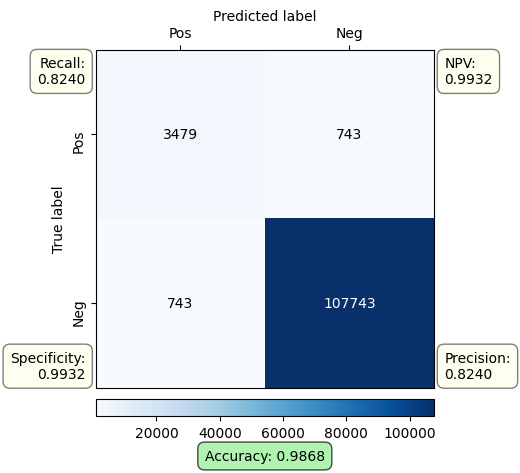


Confusion Matrix and Metrics:
TP: 3479, TN: 107743, FP: 743, FN: 743
Accuracy: 0.9868
Precision: 0.8240
Recall (Sensitivity): 0.8240
Specificity: 0.9932
NPV: 0.9932


Generating Embeddings for Evaluation: 100%|██████████| 5/5 [00:00<00:00,  9.04it/s]


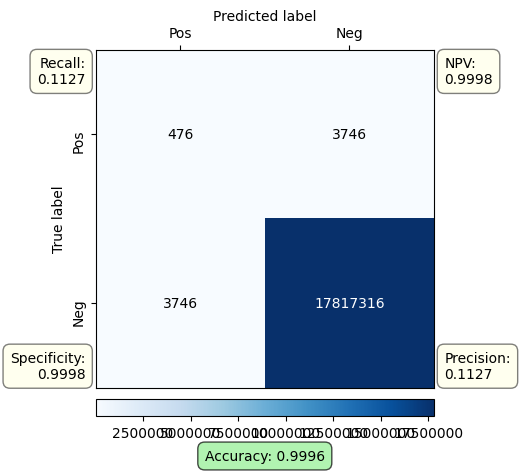


Confusion Matrix and Metrics (Unrestricted):
TP: 476, TN: 17817316, FP: 3746, FN: 3746
Accuracy: 0.9996
Precision: 0.1127
Recall (Sensitivity): 0.1127
Specificity: 0.9998
NPV: 0.9998


In [108]:
# Evaluate the best model on the test set
test_loss = evaluate_model(model, test_dataloader, device=DEVICE, gamma=GAMMA, hk_vae=None)
print(f"Test set loss: {test_loss:.4f}\n")

K = 1
T = None # 0.55

# Evaluate TopK per organism
results_restricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=True, hk_vae=None)
print("\nConfusion Matrix and Metrics:")
print(f"TP: {results_restricted['TP']}, TN: {results_restricted['TN']}, FP: {results_restricted['FP']}, FN: {results_restricted['FN']}")
print(f"Accuracy: {results_restricted['accuracy']:.4f}")
print(f"Precision: {results_restricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_restricted['recall']:.4f}")
print(f"Specificity: {results_restricted['specificity']:.4f}")
print(f"NPV: {results_restricted['npv']:.4f}")

# Evaluate TopK unrestricted
results_unrestricted = analyze_cognate_prediction_confusion_matrix(model, test_dataloader, device=DEVICE, k=K, threshold=T, restrict_organism=False, hk_vae=None)
print("\nConfusion Matrix and Metrics (Unrestricted):")
print(f"TP: {results_unrestricted['TP']}, TN: {results_unrestricted['TN']}, FP: {results_unrestricted['FP']}, FN: {results_unrestricted['FN']}")
print(f"Accuracy: {results_unrestricted['accuracy']:.4f}")
print(f"Precision: {results_unrestricted['precision']:.4f}")
print(f"Recall (Sensitivity): {results_unrestricted['recall']:.4f}")
print(f"Specificity: {results_unrestricted['specificity']:.4f}")
print(f"NPV: {results_unrestricted['npv']:.4f}")

In [111]:
evaluate_adversary_accuracy(adversary=adversary, main_model=model, dataloader=subsampled_train_dataloader, device=DEVICE)

Evaluating Adversary Accuracy: 100%|██████████| 1/1 [00:00<00:00, 36.83it/s]


(0.4906134374417015, np.float64(0.9896))

In [112]:
adversary_accuracy = evaluate_adversary_accuracy(adversary=adversary, main_model=model, dataloader=test_dataloader, device=DEVICE)
print(f"Adversary accuracy: {adversary_accuracy}")

Evaluating Adversary Accuracy: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]

Adversary accuracy: (0.4994174433910638, np.float64(0.9371940438829702))


### Plot by number of cognates

In [121]:
# add num_rr_cognates to test_df

groups_df = pd.read_pickle("/zdata/user-data/noam/data/p2cs/p2cs_filtered_groups.pkl")

hk_subset = groups_df[groups_df['class'] == 'HK']

# for all hk's in a proximity group, the number of rr cognates is the same
proximity_group_to_num_rr_cognates = hk_subset.set_index('proximity_group')['num_cognates'].groupby('proximity_group').first()

# in test_df, for each row, which has a pair of hk and rr, take the first 'num_cognates' value of the hk_subset for that proximity_group
test_df['num_rr_cognates'] = test_df['proximity_group'].map(proximity_group_to_num_rr_cognates)

In [122]:
# Evaluate accuracy per proximity group size

# Use the test_dataloader directly to get embeddings and other information
hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, rr_genes_test_all = [], [], [], [], [], []

model.eval()
if hk_vae is not None:
    hk_vae.eval()

with torch.no_grad():
    for (hk_batch_data, rr_batch_data, organism, hk_gene, rr_gene), indices in tqdm(test_dataloader, desc="Collecting Embeddings for Proximity Group Evaluation"):
        hk_batch_data, rr_batch_data = hk_batch_data.to(DEVICE), rr_batch_data.to(DEVICE)

        # Pass HK data through VAE encoder if VAE is provided
        if hk_vae is not None:
            mu, logvar = hk_vae.encode(hk_batch_data)
            hk_input_for_adapter = mu
        else:
            hk_input_for_adapter = hk_batch_data

        hk_emb, rr_emb, temp, gamma = model(hk_input_for_adapter, rr_batch_data)
        hk_emb_test_all.append(hk_emb) # Keep as tensors for now
        rr_emb_test_all.append(rr_emb) # Keep as tensors for now
        organisms_test_all.extend(organism)
        indices_test_all.extend(indices.tolist()) # Collect indices
        hk_genes_test_all.extend(hk_gene) # Collect hk_genes
        rr_genes_test_all.extend(rr_gene) # Collect rr_genes
# Concatenate embeddings into single tensors
hk_emb_test_all = torch.cat(hk_emb_test_all, dim=0)
rr_emb_test_all = torch.cat(rr_emb_test_all, dim=0)

Calculating proximity group size accuracy (GPU-optimized)...
Calculation completed in 0.05 seconds

Accuracy by Proximity Group Size:
Proximity Group Size 1: 0.8743
Proximity Group Size 2: 0.4561
Proximity Group Size 3: 0.3333
Proximity Group Size 4: 0.2500
Proximity Group Size 6: 0.1667


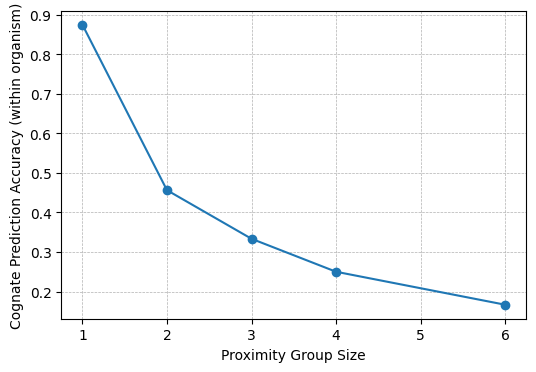

In [123]:
# Calculate proximity group size accuracy with timing
print("Calculating proximity group size accuracy (GPU-optimized)...")
start_time = time.time()

# Pass the collected embeddings, organisms, indices, hk_genes, rr_genes, and the original test_df
proximity_group_accuracy = calculate_cognate_accuracy_per_group(
    hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, rr_genes_test_all, test_df, group_by='proximity_group_size', device=DEVICE
)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

print("\nAccuracy by Proximity Group Size:")
for size, accuracy in sorted(proximity_group_accuracy.items()):
    print(f"Proximity Group Size {size}: {accuracy:.4f}")

# Convert dictionary to sorted lists for plotting
group_sizes = sorted(proximity_group_accuracy.keys())
accuracies = [proximity_group_accuracy[size] for size in group_sizes]

plt.figure(figsize=(6, 4))
plt.plot(group_sizes, accuracies, marker='o', linestyle='-')
# plt.xscale('log')
plt.xlabel('Proximity Group Size')
plt.ylabel('Cognate Prediction Accuracy (within organism)')
# plt.title('Cognate Prediction Accuracy vs. Proximity Group Size')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

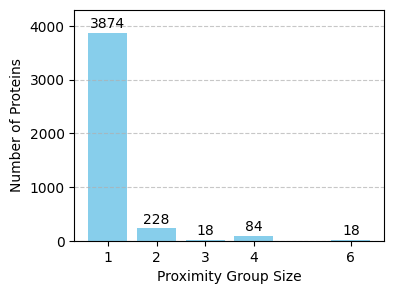

In [124]:
# Count the occurrences of each proximity group size
proximity_group_size_counts = test_df['proximity_group_size'].value_counts().sort_index()

# Extract data for plotting
sizes = proximity_group_size_counts.index
counts = proximity_group_size_counts.values

# Create the histogram
plt.figure(figsize=(4, 3))
plt.bar(sizes, counts, width=0.8, color='skyblue')
plt.xlabel('Proximity Group Size')
plt.ylabel('Number of Proteins')
# plt.title('Distribution of Proteins by Proximity Group Size in Test Set')
plt.xticks(sizes) # Ensure all group sizes are shown as ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 4300)
# Add a label above each bar for clarity
for i, count in enumerate(counts):
    plt.text(sizes[i], count + max(counts) * 0.01, str(count), ha='center', va='bottom')

plt.show()

Calculating number of RR cognates accuracy (GPU-optimized)...
Calculation completed in 0.05 seconds

Accuracy by Number of RR cognates:
Number of RR cognates 1.0: 0.8592
Number of RR cognates 2.0: 0.3935
Number of RR cognates 3.0: 0.2667


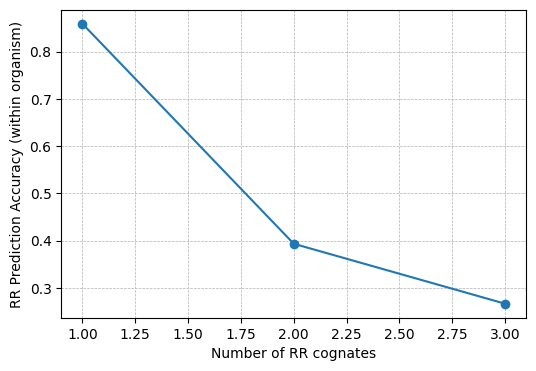

In [125]:
# Calculate number of RR cognates accuracy with timing
print("Calculating number of RR cognates accuracy (GPU-optimized)...")
start_time = time.time()

# Pass the collected embeddings, organisms, indices, hk_genes, rr_genes, and the original test_df
proximity_group_accuracy = calculate_cognate_accuracy_per_group(
    hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, rr_genes_test_all, test_df, group_by='num_rr_cognates', device=DEVICE
)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

print("\nAccuracy by Number of RR cognates:")
for size, accuracy in sorted(proximity_group_accuracy.items()):
    print(f"Number of RR cognates {size}: {accuracy:.4f}")

# Convert dictionary to sorted lists for plotting
group_sizes = sorted(proximity_group_accuracy.keys())
accuracies = [proximity_group_accuracy[size] for size in group_sizes]

plt.figure(figsize=(6, 4))
plt.plot(group_sizes, accuracies, marker='o', linestyle='-')
# plt.xscale('log')
plt.xlabel('Number of RR cognates')
plt.ylabel('RR Prediction Accuracy (within organism)')
# plt.title('Cognate Prediction Accuracy vs. Cognate Count')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [126]:
# Calculate number of RR cognates accuracy with timing
print("Calculating number of RR cognates accuracy (GPU-optimized)...")
start_time = time.time()

# Pass the collected embeddings, organisms, indices, hk_genes, rr_genes, and the original test_df
number_rr_cognates_accuracy = calculate_cognate_topk_accuracy_per_proximity_group_k(
    hk_emb_test_all, rr_emb_test_all, organisms_test_all, indices_test_all, hk_genes_test_all, test_df, device=DEVICE
)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

print("\nAccuracy by Number of RR cognates:")
for size, accuracy in sorted(number_rr_cognates_accuracy.items()):
    print(f"Number of RR cognates {size}: {accuracy:.4f}")

# Convert dictionary to sorted lists for plotting
number_rr_cognates_sizes = sorted(number_rr_cognates_accuracy.keys())
accuracies = [number_rr_cognates_accuracy[size] for size in number_rr_cognates_sizes]

plt.figure(figsize=(6, 4))
plt.plot(number_rr_cognates_sizes, accuracies, marker='o', linestyle='-')
# plt.xscale('log')
plt.xlabel('K (number of RR cognates)')
plt.ylabel('% Cognates in the top K predictions\n(within organism)')
# plt.title('Cognate Prediction Accuracy vs. Proximity Group Size')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

Calculating number of RR cognates accuracy (GPU-optimized)...


TypeError: calculate_cognate_topk_accuracy_per_proximity_group_k() missing 1 required positional argument: 'df_original'

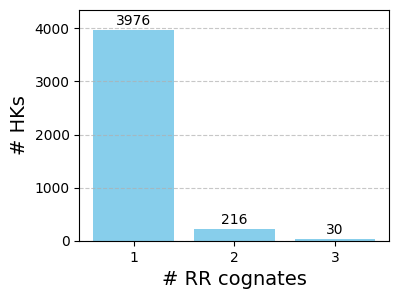

In [ ]:
# Count the occurrences of each number of RR cognates
number_rr_cognates_counts = test_df['num_rr_cognates'].value_counts().sort_index()

# Extract data for plotting
sizes = number_rr_cognates_counts.index
counts = number_rr_cognates_counts.values

# Create the histogram
plt.figure(figsize=(4, 3))
plt.bar(sizes, counts, width=0.8, color='skyblue')
plt.xlabel('# RR cognates', fontsize=14)
plt.ylabel('# HKs', fontsize=14)
# plt.title('Distribution of Proteins by Number of RR cognates in Test Set')
plt.xticks(sizes) # Ensure all group sizes are shown as ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 4350)
# Add a label above each bar for clarity
for i, count in enumerate(counts):
    plt.text(sizes[i], count + max(counts) * 0.01, str(count), ha='center', va='bottom')

plt.show()

### By organism

#### Calculate

In [37]:
# Evaluate accuracy per organism

# Generate embeddings for the entire test set by iterating through the dataloader
hk_emb_test_list, rr_emb_test_list = [], []
organisms_test_list = []
hk_genes_test_list = []
rr_genes_test_list = []
indices_test_list = [] # Collect indices to reconstruct dataframe if needed

model.eval()
if hk_vae is not None:
    hk_vae.eval()

with torch.no_grad():
    for (hk_batch_data, rr_batch_data, organism, hk_gene, rr_gene), indices in tqdm(test_dataloader, desc="Generating Embeddings for Per-Organism Evaluation"):
        hk_batch_data, rr_batch_data = hk_batch_data.to(DEVICE), rr_batch_data.to(DEVICE)

        # Pass HK data through VAE encoder if VAE is provided
        if hk_vae is not None:
            mu, logvar = hk_vae.encode(hk_batch_data)
            hk_input_for_adapter = mu
        else:
            hk_input_for_adapter = hk_batch_data

        hk_emb, rr_emb, temp, gamma = model(hk_input_for_adapter, rr_batch_data)

        hk_emb_test_list.append(hk_emb.cpu())
        rr_emb_test_list.append(rr_emb.cpu())
        organisms_test_list.extend(organism)
        hk_genes_test_list.extend(hk_gene)
        rr_genes_test_list.extend(rr_gene)
        indices_test_list.extend(indices.tolist())

# Concatenate embeddings into single tensors on CPU
hk_emb_test_all = torch.cat(hk_emb_test_list, dim=0)
rr_emb_test_all = torch.cat(rr_emb_test_list, dim=0)

# Create a new dataframe for evaluation results, including embeddings
# Use the collected indices to ensure alignment with original test_df if needed later
eval_df = pd.DataFrame({
    'organism': organisms_test_list,
    'hk_gene': hk_genes_test_list,
    'rr_gene': rr_genes_test_list,
    'hk_predicted_embedding': hk_emb_test_all.tolist(), # Convert tensor to list of lists
    'rr_predicted_embedding': rr_emb_test_all.tolist(), # Convert tensor to list of lists
}, index=indices_test_list) # Use collected indices
# Add proximity group size and number of RR cognates to eval_df
eval_df['proximity_group_size'] = test_df.loc[eval_df.index, 'proximity_group_size']
eval_df['num_rr_cognates'] = test_df.loc[eval_df.index, 'num_rr_cognates']

# Calculate per-organism accuracy
print("Calculating per-organism accuracy...")
start_time = time.time()

# Use the new eval_df which contains the generated embeddings
organism_accuracy = calculate_cognate_accuracy_per_organism(eval_df, device=DEVICE)

end_time = time.time()
print(f"Calculation completed in {end_time - start_time:.2f} seconds")

# Add original proximity group size from the test_df to eval_df for plotting later
# We need to load the original test_df for this
original_test_df = pd.read_pickle(TEST_FILE_PATH)
eval_df['proximity_group_size'] = original_test_df.loc[eval_df.index, 'proximity_group_size']
del original_test_df
gc.collect()


print(f"\nTotal organisms evaluated: {len(organism_accuracy)}")
print(f"Mean accuracy across organisms: {np.mean(list(organism_accuracy.values())):.4f}")
print(f"Median accuracy across organisms: {np.median(list(organism_accuracy.values())):.4f}")


# Sort organisms by accuracy
sorted_organisms = sorted(organism_accuracy.items(), key=lambda x: x[1], reverse=True)

# Show best and worst performing organisms
print("\nTop 10 Best Performing Organisms:")
for i, (organism, accuracy) in enumerate(sorted_organisms[:10]):
    organism_size = len(eval_df[eval_df['organism'] == organism])
    print(f"{i+1:2d}. {organism}: {accuracy:.4f} (n={organism_size})")

print("\nTop 10 Worst Performing Organisms:")
for i, (organism, accuracy) in enumerate(sorted_organisms[-10:]):
    organism_size = len(eval_df[eval_df['organism'] == organism])
    print(f"{i+1:2d}. {organism}: {accuracy:.4f} (n={organism_size})")


Generating Embeddings for Per-Organism Evaluation: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]


KeyError: 'num_rr_cognates'

#### Plot

/zdata/user-data/noam/.conda/envs/python310/lib/python3.10/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


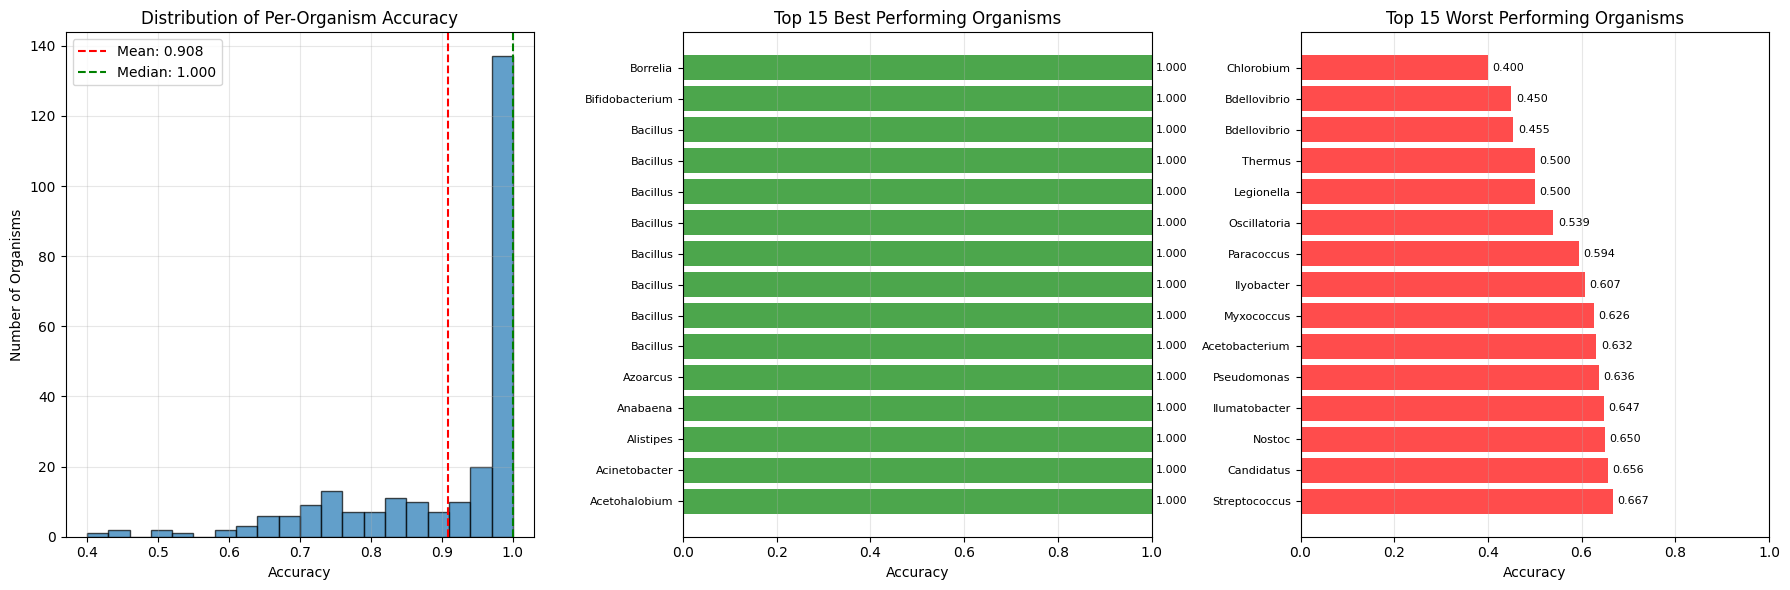

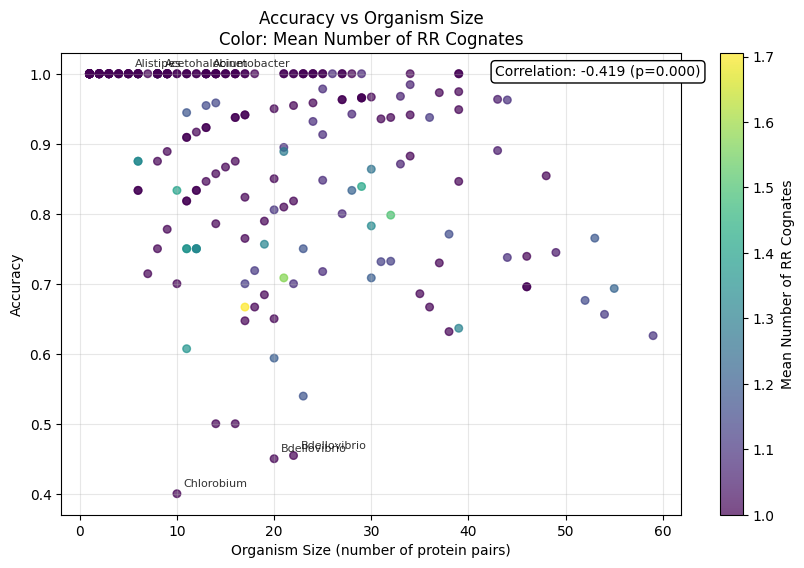


Correlation between organism size and accuracy: -0.419 (p-value: 0.000)


In [ ]:
# Create visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# 1. Histogram of accuracies
accuracies = list(organism_accuracy.values())
ax1.hist(accuracies, bins=20, alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(accuracies), color='red', linestyle='--', label=f'Mean: {np.mean(accuracies):.3f}')
ax1.axvline(np.median(accuracies), color='green', linestyle='--', label=f'Median: {np.median(accuracies):.3f}')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Number of Organisms')
ax1.set_title('Distribution of Per-Organism Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Best performing organisms
best_organisms = sorted_organisms[:15]  # Top 15
best_names = [org.split('_')[0] if '_' in org else org[:10] for org, _ in best_organisms]  # Shortened names
best_accuracies = [acc for _, acc in best_organisms]

ax2.barh(range(len(best_names)), best_accuracies, color='green', alpha=0.7)
ax2.set_yticks(range(len(best_names)))
ax2.set_yticklabels(best_names, fontsize=8)
ax2.set_xlabel('Accuracy')
ax2.set_title('Top 15 Best Performing Organisms')
ax2.set_xlim(0, 1)
ax2.grid(True, alpha=0.3, axis='x')

# Add accuracy values on bars
for i, acc in enumerate(best_accuracies):
    ax2.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=8)

# 3. Worst performing organisms
worst_organisms = sorted_organisms[-15:]  # Bottom 15
worst_names = [org.split('_')[0] if '_' in org else org[:10] for org, _ in worst_organisms]  # Shortened names
worst_accuracies = [acc for _, acc in worst_organisms]

ax3.barh(range(len(worst_names)), worst_accuracies, color='red', alpha=0.7)
ax3.set_yticks(range(len(worst_names)))
ax3.set_yticklabels(worst_names, fontsize=8)
ax3.set_xlabel('Accuracy')
ax3.set_title('Top 15 Worst Performing Organisms')
ax3.set_xlim(0, 1)
ax3.grid(True, alpha=0.3, axis='x')

# Add accuracy values on bars
for i, acc in enumerate(worst_accuracies):
    ax3.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# ----- Begin modified scatter plot coloring section -----

# Compute mean number of RR cognates for each organism - FIXED LOGIC
mean_num_rr_cognates = {}
for organism in organism_accuracy:
    org_df = eval_df[eval_df['organism'] == organism]
    num_rr_cognates = org_df['num_rr_cognates']
    # The mean number of RR cognates for this organism
    if len(num_rr_cognates) > 0:
        mean_rr = num_rr_cognates.mean()
    else:
        mean_rr = np.nan
    mean_num_rr_cognates[organism] = mean_rr

organism_sizes = []
organism_accs = []
organism_num_rr_cognates = []
for organism, accuracy in organism_accuracy.items():
    size = len(eval_df[eval_df['organism'] == organism])
    organism_sizes.append(size)
    organism_accs.append(accuracy)
    organism_num_rr_cognates.append(mean_num_rr_cognates[organism])

# Plot accuracy vs organism size, colored by mean number of RR cognates
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    organism_sizes, organism_accs,
    c=organism_num_rr_cognates,
    cmap='viridis', alpha=0.7, s=30
)
plt.xlabel('Organism Size (number of protein pairs)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Organism Size\nColor: Mean Number of RR Cognates')
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, label='Mean Number of RR Cognates')

# Add trend line
correlation, p_value = pearsonr(organism_sizes, organism_accs)
plt.text(0.7, 0.95, f'Correlation: {correlation:.3f} (p={p_value:.3f})',
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

# Add some organism labels for extreme cases
for i, (organism, accuracy) in enumerate(sorted_organisms[:3] + sorted_organisms[-3:]):
    size = len(eval_df[eval_df['organism'] == organism])
    plt.annotate(organism.split('_')[0] if '_' in organism else organism[:10],
                xy=(size, accuracy), xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

plt.show()

print(f"\nCorrelation between organism size and accuracy: {correlation:.3f} (p-value: {p_value:.3f})")

# # Clean up the evaluation dataframe
# del eval_df
# gc.collect()

#### Specific organisms

In [ ]:
def evaluate_organisms_by_prefix(eval_df, prefix, device='cuda', k=1, threshold=None):
    """
    Filters organisms in eval_df by a prefix and calculates accuracy and
    confusion matrix components for the filtered subset.

    Args:
        eval_df (DataFrame): DataFrame containing organism, hk_predicted_embedding,
                             and rr_predicted_embedding columns.
        prefix (str): The prefix to filter organism names by.
        device (str): Device to use for computation ('cuda' or 'cpu').
        k: The number of nearest neighbors to consider as cognates.
        threshold: The similarity threshold.

    Returns:
        dict: A dictionary where keys are organism names (filtered by prefix)
              and values are dictionaries containing 'accuracy' and
              confusion matrix components ('TP', 'TN', 'FP', 'FN').
    """
    results = {}

    # Filter the dataframe by organism prefix
    filtered_df = eval_df[eval_df['organism'].str.startswith(prefix)].copy()

    if filtered_df.empty:
        print(f"No organisms found with prefix '{prefix}'")
        return results

    # Get unique organisms in the filtered subset
    unique_organisms_filtered = filtered_df['organism'].unique().tolist()

    print(f"Evaluating {len(unique_organisms_filtered)} organisms starting with '{prefix}'...")

    for organism in tqdm(unique_organisms_filtered, desc=f"Evaluating organisms with prefix '{prefix}'"):
        organism_df = filtered_df[filtered_df['organism'] == organism].copy()

        total_pairs = len(organism_df)
        if total_pairs == 0:
            results[organism] = {'accuracy': 0, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
            continue

        # Extract embeddings and convert to GPU tensors
        hk_embeddings = torch.tensor(
            np.array(organism_df['hk_predicted_embedding'].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        rr_embeddings = torch.tensor(
            np.array(organism_df['rr_predicted_embedding'].tolist()),
            dtype=torch.float32,
            device=device
        )  # Shape: [N, embedding_dim]

        # Normalize for cosine similarity
        hk_norm = F.normalize(hk_embeddings, p=2, dim=1)
        rr_norm = F.normalize(rr_embeddings, p=2, dim=1)

        # Calculate similarity matrix within this organism: [N, N]
        similarity_matrix = torch.matmul(hk_norm, rr_norm.T)

        # Determine predictions based on k and/or threshold
        prediction_matrix = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)

        if threshold is not None:
            threshold_mask = (similarity_matrix >= threshold)
            if k is not None:
                _, top_k_indices = torch.topk(similarity_matrix, k=min(k, total_pairs), dim=1)
                top_k_mask = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)
                hk_indices_expand = torch.arange(total_pairs, device=device)[:, None].expand(-1, min(k, total_pairs))
                top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
                prediction_matrix = threshold_mask | top_k_mask
            else:
                prediction_matrix = threshold_mask
        elif k is not None:
            _, top_k_indices = torch.topk(similarity_matrix, k=min(k, total_pairs), dim=1)
            top_k_mask = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)
            hk_indices_expand = torch.arange(total_pairs, device=device)[:, None].expand(-1, min(k, total_pairs))
            top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
            prediction_matrix = top_k_mask
        else:
             # Default to k=1 if neither is specified
             _, top_k_indices = torch.topk(similarity_matrix, k=1, dim=1)
             top_k_mask = torch.zeros(total_pairs, total_pairs, dtype=torch.bool, device=device)
             hk_indices_expand = torch.arange(total_pairs, device=device)[:, None].expand(-1, 1)
             top_k_mask[hk_indices_expand.flatten(), top_k_indices.flatten()] = True
             prediction_matrix = top_k_mask


        # Ground truth matrix (diagonal for cognate pairs within the organism)
        ground_truth_matrix = torch.eye(total_pairs, dtype=torch.bool, device=device)

        # Calculate confusion matrix components
        TP = torch.sum(ground_truth_matrix & prediction_matrix).item()
        FN = torch.sum(ground_truth_matrix & ~prediction_matrix).item()
        FP = torch.sum(~ground_truth_matrix & prediction_matrix).item()
        TN = torch.sum(~ground_truth_matrix & ~prediction_matrix).item()

        # Calculate accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        results[organism] = {
            'accuracy': accuracy,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN
        }

    return results

# Example usage:
# Replace 'Escherichia' with the desired prefix
prefix_to_evaluate = 'Escherichia'
# Set k and/or threshold as needed
k_eval = 1
threshold_eval = None # Or a specific threshold like 0.5

evaluation_results = evaluate_organisms_by_prefix(
    eval_df,
    prefix_to_evaluate,
    device=DEVICE,
    k=k_eval,
    threshold=threshold_eval
)

# Print the results
print("\nEvaluation Results:")
for organism, metrics in evaluation_results.items():
    print(f"\nOrganism: {organism}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  TP: {metrics['TP']}, TN: {metrics['TN']}, FP: {metrics['FP']}, FN: {metrics['FN']}")

Evaluating 4 organisms starting with 'Escherichia'...


Evaluating organisms with prefix 'Escherichia': 100%|██████████| 4/4 [00:00<00:00, 622.55it/s]


Evaluation Results:

Organism: Escherichia_coli_Xuzhou21
  Accuracy: 1.0000
  TP: 23, TN: 506, FP: 0, FN: 0

Organism: Escherichia_coli_B_str._REL606
  Accuracy: 1.0000
  TP: 21, TN: 420, FP: 0, FN: 0

Organism: Escherichia_coli_ABU_83972
  Accuracy: 1.0000
  TP: 24, TN: 552, FP: 0, FN: 0

Organism: Escherichia_coli_O104:H4_str._2011C-3493
  Accuracy: 0.9965
  TP: 23, TN: 551, FP: 1, FN: 1


### Precision-Recall Curve

In [130]:
k_values = np.arange(1, 10, 1)  # k from 1 to 50
t_values = np.linspace(0, 1, 20) # 101 thresholds from 0.0 to 1.0
lst_restric_organism = [True]

In [131]:
# Generate ROC data with TP, FP, FN
pr_data_dict = generate_pr_data(model, test_dataloader, DEVICE, k_values, t_values, list_restrict_organism=lst_restric_organism, hk_vae=None)

# Unpack the data for plotting - now from the dictionary
# Assuming lst_restrict_organism has two values: True and False
if True in pr_data_dict:
    tp_topk_restricted, fp_topk_restricted, fn_topk_restricted, tp_threshold_restricted, fp_threshold_restricted, fn_threshold_restricted = pr_data_dict[True]
else:
    # Handle case where restricted data is not generated
    tp_topk_restricted, fp_topk_restricted, fn_topk_restricted = [], [], []
    tp_threshold_restricted, fp_threshold_restricted, fn_threshold_restricted = [], [], []


if False in pr_data_dict:
     tp_topk_unrestricted, fp_topk_unrestricted, fn_topk_unrestricted, tp_threshold_unrestricted, fp_threshold_unrestricted, fn_threshold_unrestricted = pr_data_dict[False]
else:
    # Handle case where unrestricted data is not generated
    tp_topk_unrestricted, fp_topk_unrestricted, fn_topk_unrestricted = [], [], []
    tp_threshold_unrestricted, fp_threshold_unrestricted, fn_threshold_unrestricted = [], [], []


print("PR data generated and unpacked successfully.")

Generating Threshold PR data (Restricted: True): 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]

PR data generated and unpacked successfully.


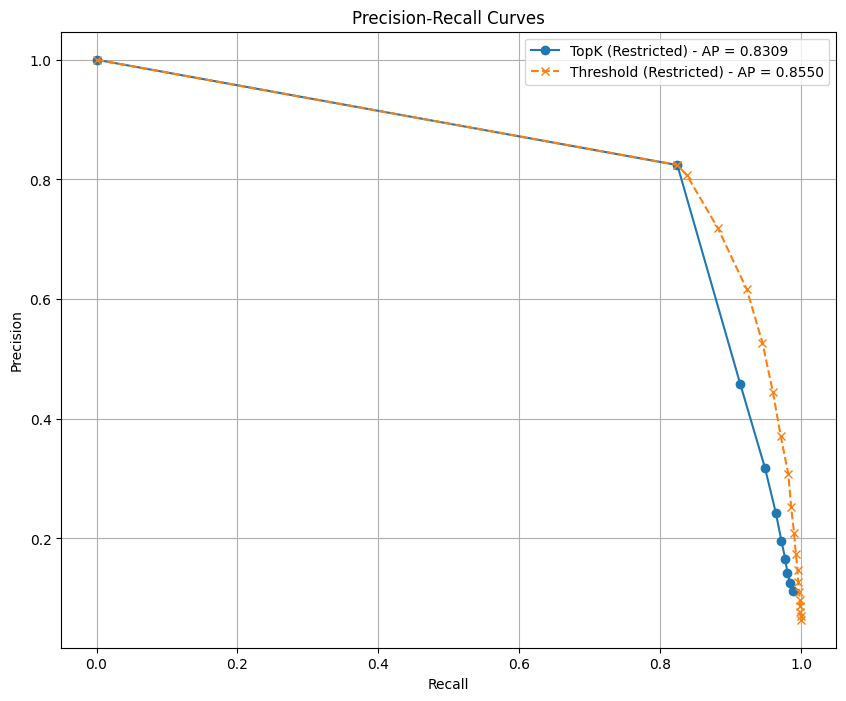

In [132]:
plot_pr_curves(pr_data_dict)

### Compare similarities

#### inter/intra-organism cognate/non-cognate

In [44]:
# Calculate and print mean similarities on the test set
print("Calculating mean inter- and intra-organism similarities on the test set...")

mean_cognate_sim, mean_promiscuous_sim, mean_intra_sim, mean_inter_sim = calculate_mean_similarities(model, test_dataloader, device=DEVICE, hk_vae=None)

print(f"Mean cognate similarity: {mean_cognate_sim:.4f}")
print(f"Mean promiscuous similarity: {mean_promiscuous_sim:.4f}")
print(f"Mean intra-organism non-cognate similarity: {mean_intra_sim:.4f}")
print(f"Mean inter-organism non-cognate similarity: {mean_inter_sim:.4f}")

Calculating mean inter- and intra-organism similarities on the test set...


Mean cognate similarity: 0.6656
Mean promiscuous similarity: 0.5899
Mean intra-organism non-cognate similarity: 0.1337
Mean inter-organism non-cognate similarity: 0.1208


#### Histogram

Calculating and plotting histograms of similarities for cognate, non-cognate, and in-organism non-cognate pairs...


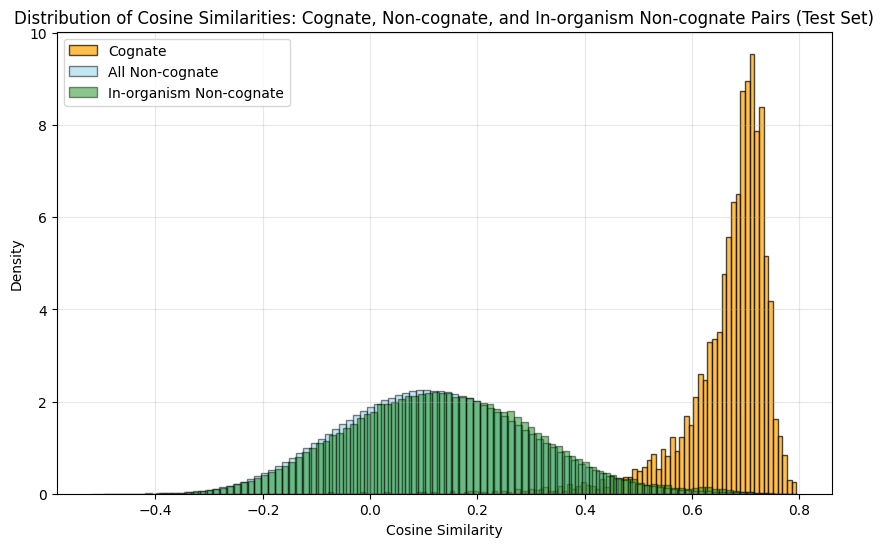

In [45]:
# Calculate and plot histograms of similarities for:
# - Cognate pairs (diagonal)
# - Non-cognate pairs (off-diagonal)
# - In organism non-cognate pairs (off-diagonal within organism)

print("Calculating and plotting histograms of similarities for cognate, non-cognate, and in-organism non-cognate pairs...")

# Convert embeddings from lists back to tensors
hk_emb_test_all_tensor = torch.tensor(np.array(eval_df['hk_predicted_embedding'].tolist()), dtype=torch.float32, device=DEVICE)
rr_emb_test_all_tensor = torch.tensor(np.array(eval_df['rr_predicted_embedding'].tolist()), dtype=torch.float32, device=DEVICE)

# Normalize for cosine similarity
hk_norm = F.normalize(hk_emb_test_all_tensor, p=2, dim=1)  # Shape: [N, embedding_dim]
rr_norm = F.normalize(rr_emb_test_all_tensor, p=2, dim=1)  # Shape: [N, embedding_dim]

# Calculate similarity matrix: [N, N]
similarity_matrix = torch.matmul(hk_norm, rr_norm.T)
similarity_matrix = similarity_matrix.cpu().numpy()
N = len(eval_df)

# Assume one-to-one ordering: i-th HK and i-th RR are the cognate pair
cognate_mask = np.eye(N, dtype=bool)
noncognate_mask = ~cognate_mask

# Compute in-organism non-cognate mask (off-diagonal within organism)
organism_series = eval_df['organism'].astype(str).to_numpy()
organism_matrix = np.equal.outer(organism_series, organism_series)    # [N,N] True where they're from same organism
in_organism_noncognate_mask = (organism_matrix) & (~cognate_mask)

cognate_similarities = similarity_matrix[cognate_mask]
noncognate_similarities = similarity_matrix[noncognate_mask]
in_organism_noncognate_similarities = similarity_matrix[in_organism_noncognate_mask]

# Plot combined histogram for all three categories
plt.figure(figsize=(10, 6))
plt.hist(cognate_similarities, bins=100, density=True, alpha=0.7, color='orange', edgecolor='black', label='Cognate')
plt.hist(noncognate_similarities, bins=100, density=True, alpha=0.5, color='skyblue', edgecolor='black', label='All Non-cognate')
plt.hist(in_organism_noncognate_similarities, bins=100, density=True, alpha=0.45, color='green', edgecolor='black', label='In-organism Non-cognate')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Distribution of Cosine Similarities: Cognate, Non-cognate, and In-organism Non-cognate Pairs (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Organism similarity Vs. Phylogeny

In [56]:
def run_organism_similarity_analysis(eval_df, test_df, distance_mat_df, device):
    """
    Main function to run the complete organism similarity analysis.
    
    Args:
        eval_df: DataFrame with evaluation data and embeddings
        test_df: DataFrame with test data including proximity groups
        distance_mat_df: DataFrame with phylogenetic distance matrix
        device: PyTorch device for tensor operations
    
    Returns:
        tuple: (non_cognate_similarity_distance_df, cognate_similarity_distance_df)
    """
    # Validate required data
    if distance_mat_df is None or eval_df is None:
        raise ValueError("Required data structures not available")
    print("Required data structures validated")
    
    # Prepare organism data
    eval_df['proximity_group'] = test_df['proximity_group']
    unique_organisms_eval = eval_df['organism'].unique().tolist()
    unique_organisms_eval_formatted = [org.replace(' ', '_') for org in unique_organisms_eval]
    organisms_in_common = list(set(unique_organisms_eval_formatted) & set(distance_mat_df.index))
    testset_distance_subset = distance_mat_df.loc[organisms_in_common, organisms_in_common].copy()
    print(f"Found {len(organisms_in_common)} organisms in common between datasets")
    
    # Compute similarity matrix
    hk_emb_all = torch.tensor(np.array(eval_df['hk_predicted_embedding'].tolist()), dtype=torch.float32, device=device)
    rr_emb_all = torch.tensor(np.array(eval_df['rr_predicted_embedding'].tolist()), dtype=torch.float32, device=device)
    hk_emb_all_norm = F.normalize(hk_emb_all, p=2, dim=1)
    rr_emb_all_norm = F.normalize(rr_emb_all, p=2, dim=1)
    all_similarity_matrix = torch.matmul(hk_emb_all_norm, rr_emb_all_norm.T)
    print(f"Computed similarity matrix of shape {all_similarity_matrix.shape}")
    
    # Prepare organism mappings
    organism_array_formatted = np.array([org.replace(' ', '_') for org in eval_df['organism'].tolist()])
    proximity_group_array = np.array(eval_df['proximity_group'].tolist())
    formatted_to_original = {f: o for f, o in zip(unique_organisms_eval_formatted, unique_organisms_eval)}
    organism_indices = {org_form: np.where(organism_array_formatted == org_form)[0] for org_form in organisms_in_common}
    print(f"Created organism mappings for {len(organism_indices)} organisms")
    
    # Analyze organism pairs
    org1, org2 = np.triu_indices(len(organisms_in_common))
    org1_formatted = np.array(organisms_in_common)[org1]
    org2_formatted = np.array(organisms_in_common)[org2]
    distance_mat = testset_distance_subset.values
    invalid_mask = (distance_mat == -1) | np.isinf(distance_mat) | np.isnan(distance_mat)
    invalid_triu_mask = invalid_mask[org1, org2]
    
    similarity_distance_data = []
    cognate_similarity_distance_data = []
    print(f"Analyzing {len(org1_formatted)} unique organism pairs...")
    
    for i, (of1, of2) in enumerate(zip(org1_formatted, org2_formatted)):
        if invalid_triu_mask[i]:
            continue
            
        distance = distance_mat[org1[i], org2[i]]
        org1_original = formatted_to_original[of1]
        org2_original = formatted_to_original[of2]
        idxs_org1 = organism_indices[of1]
        idxs_org2 = organism_indices[of2]
        
        if org1_original != org2_original:
            # Cross-organism: HK1-RR2 + RR1-HK2
            sim_hk1_rr2 = all_similarity_matrix[np.ix_(idxs_org1, idxs_org2)]
            sim_rr1_hk2 = all_similarity_matrix[np.ix_(idxs_org2, idxs_org1)]
            all_pairwise_similarities = torch.cat([sim_hk1_rr2.flatten().detach().clone(), sim_rr1_hk2.flatten().detach().clone()])
        else:
            # Within-organism: separate cognates from non-cognates
            sim_matrix = all_similarity_matrix[np.ix_(idxs_org1, idxs_org1)]
            org_pg = proximity_group_array[idxs_org1]
            cognate_mask = (org_pg[:, None] == org_pg[None, :])
            non_cognate_mask = ~cognate_mask
            
            non_cognate_similarities = sim_matrix[non_cognate_mask].flatten().detach().clone()
            cognate_similarities = sim_matrix[cognate_mask].flatten().detach().clone()
            all_pairwise_similarities = non_cognate_similarities
            
            if cognate_similarities.numel() > 0:
                cognate_similarity_distance_data.append({
                    'distance': distance, 'mean_similarity': cognate_similarities.mean().item(), 'organism': org1_original
                })
        
        if all_pairwise_similarities.numel() > 0:
            similarity_distance_data.append({
                'distance': distance, 'mean_similarity': torch.mean(all_pairwise_similarities.float()).item(),
                'organism1': org1_original, 'organism2': org2_original
            })
    
    print("Pairwise similarity calculations complete")
    
    # Convert to DataFrames and display results
    non_cognate_similarity_distance_df = pd.DataFrame(similarity_distance_data)
    cognate_similarity_distance_df = pd.DataFrame(cognate_similarity_distance_data)
    
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    print(f"Non-cognate pairs analyzed: {len(non_cognate_similarity_distance_df)}")
    print(f"Cognate pairs analyzed: {len(cognate_similarity_distance_df)}")
    
    return non_cognate_similarity_distance_df, cognate_similarity_distance_df

# Run the analysis and get the results
non_cognate_similarity_distance_df, cognate_similarity_distance_df = run_organism_similarity_analysis(
    eval_df, test_df, distance_mat_df, DEVICE)

# Optional: Save results
# non_cognate_similarity_distance_df.to_pickle(os.path.join(DATA_PATH, 'organism_pairwise_similarity_vs_distance.pkl'))
# cognate_similarity_distance_df.to_pickle(os.path.join(DATA_PATH, 'cognate_similarity_vs_distance.pkl'))


Required data structures validated
Found 198 organisms in common between datasets
Computed similarity matrix of shape torch.Size([4222, 4222])
Created organism mappings for 198 organisms
Analyzing 19701 unique organism pairs...
Pairwise similarity calculations complete

RESULTS SUMMARY
Non-cognate pairs analyzed: 19694
Cognate pairs analyzed: 198


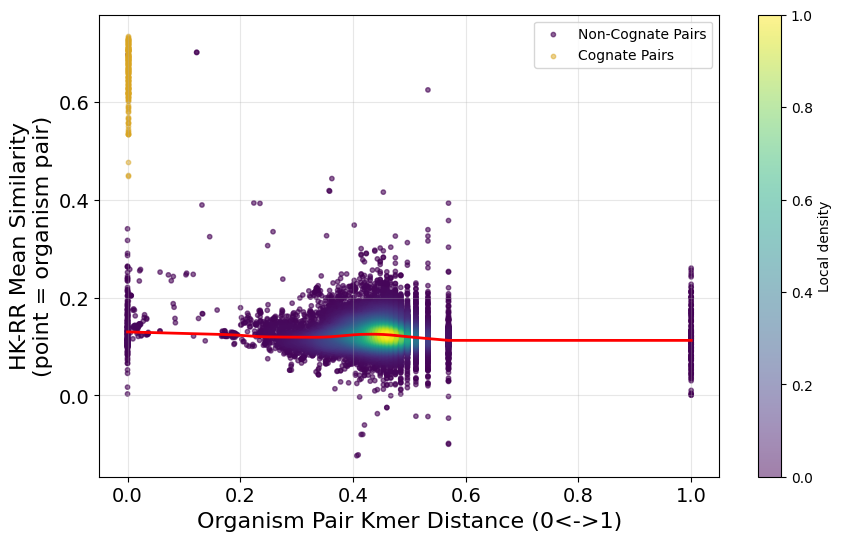

In [53]:
# Aggregate and Plot
if not non_cognate_similarity_distance_df.empty:
    plt.figure(figsize=(10, 6))

    # Extract data for density calculation
    x = non_cognate_similarity_distance_df['distance'].values
    y = non_cognate_similarity_distance_df['mean_similarity'].values
    
    # Compute density for each point
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # Sort points by density so densest are on top
    idx = z.argsort()
    x_sorted, y_sorted, z_sorted = x[idx], y[idx], z[idx]
    
    # Scatter with color encoding density
    plt.scatter(x_sorted, y_sorted, c=z_sorted, s=10, cmap='viridis', alpha=0.6, label='Non-Cognate Pairs')
    plt.scatter(x='distance', y='mean_similarity', data=cognate_similarity_distance_df, alpha=0.5, s=10, color='goldenrod', label='Cognate Pairs')

    # Add LOESS line for trend
    sns.regplot(x='distance', y='mean_similarity', data=non_cognate_similarity_distance_df,
                scatter=False, lowess=True, color='red', line_kws={'linewidth': 2})

    plt.legend()

    plt.xlabel('Organism Pair Kmer Distance (0<->1)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('HK-RR Mean Similarity\n(point = organism pair)', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Add colorbar for density
    plt.colorbar(label='Local density')

    plt.show()

In [54]:
# # Aggregate and Plot
# if not non_cognate_similarity_distance_df.empty:
#     plt.figure(figsize=(10, 6))

#     # Extract data for density calculation
#     x = non_cognate_similarity_distance_df['distance'].values
#     y = non_cognate_similarity_distance_df['mean_similarity'].values
    
#     # Compute density for each point
#     xy = np.vstack([x, y])
#     z = gaussian_kde(xy)(xy)
    
#     # Sort points by density so densest are on top
#     idx = z.argsort()
#     x_sorted, y_sorted, z_sorted = x[idx], y[idx], z[idx]
    
#     # Scatter with color encoding density
#     plt.scatter(x_sorted + 1e-4, y_sorted, c=z_sorted, s=10, cmap='viridis', alpha=0.6, label='Non-Cognate Pairs')
#     plt.scatter(x='distance', y='mean_similarity', data=cognate_similarity_distance_df, alpha=0.5, s=10, color='goldenrod', label='Cognate Pairs')

#     # Add LOESS line for trend
#     sns.regplot(x='distance', y='mean_similarity', data=non_cognate_similarity_distance_df,
#                 scatter=False, lowess=True, color='red', line_kws={'linewidth': 2})

#     plt.legend()

#     plt.xlabel('Organism Pair Kmer Distance (0<->1)', fontsize=16)
#     plt.xlim(1e-5, 1)
#     plt.ylim(0.0, .2)
#     plt.xscale('log')
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.ylabel('HK-RR Mean Similarity\n(point = organism pair)', fontsize=16)
#     plt.grid(True, alpha=0.3)
    
#     # Add colorbar for density
#     plt.colorbar(label='Local density')

#     plt.show()

#### Organism similarity Vs. Taxonomy

In [144]:
# group organism pairs by lowest common taxonomic level
def load_distance_matrix(file_path):
    """Load and clean a distance matrix from CSV."""
    df = pd.read_csv(file_path, index_col=0)
    
    # Clean the matrix (remove any NaN/inf values)
    df = df.fillna(1.0)  # Fill NaN with maximum distance
    df = df.replace([np.inf, -np.inf], 1.0)  # Replace infinite values
    
    # Ensure matrix is symmetric
    df = (df + df.T) / 2
    
    # Set diagonal to zero (distance from genome to itself)
    np.fill_diagonal(df.values, 0)
    
    return df


def find_lowest_common_ancestor(org1_tax, org2_tax, taxonomy_levels):
    """
    Find the lowest common ancestor (most specific shared taxonomic level) between two organisms.
    
    Parameters:
    -----------
    org1_tax : dict
        Taxonomy dictionary for organism 1
    org2_tax : dict
        Taxonomy dictionary for organism 2
    taxonomy_levels : list
        List of taxonomic levels from least to most specific
        
    Returns:
    --------
    str or None
        The lowest common ancestor taxonomic level, or None if no common ancestor found
    """
    # Start from most specific (strain) and go up to least specific (kingdom)
    for level in reversed(taxonomy_levels):
        val1 = org1_tax.get(level)
        val2 = org2_tax.get(level)
        
        # Check if both have values and they're not NaN and they match
        if (pd.notna(val1) and pd.notna(val2) and 
            str(val1) != '?' and str(val2) != '?' and
            str(val1) == str(val2)):
            return level
    return None


def get_organism_pairs_by_taxonomy(reference_k=15):
    """
    Identify organism pairs that share the same lowest common taxonomic level.
    This is invariant to distance matrix values - only depends on taxonomy.
    
    Parameters:
    -----------
    reference_k : int
        K value to use for loading a reference distance matrix (just to get organism names)
        
    Returns:
    --------
    pair_indices : list of tuples
        List of (i, j) indices for pairs that share at least the same family
    org_names : list
        List of organism names (in order matching distance matrix indices)
    """
    # Load a reference distance matrix (any k value works - we just need organism names)
    file_path = data_dir / f"distance_matrix_k{reference_k}.csv"
    if not file_path.exists():
        print(f"Reference file not found: {file_path}")
        return None, None
    
    print(f"Loading reference distance matrix (k={reference_k}) to get organism names...")
    distance_matrix = load_distance_matrix(file_path)
    
    # Load taxonomy data
    if 'organism_taxonomy_df' not in locals():
        print("Loading taxonomy data...")
        organism_taxonomy_df = pd.read_csv(taxonomy_dir / "organism_taxonomy.csv")
    
    # Define taxonomic levels (from least to most specific)
    taxonomy_levels = [
        'kingdom',
        'phylum',
        'class',
        'order',
        'family',
        'genus',
        'species',
        'subspecies',
        'strain'
    ]
    
    # Set up taxonomy lookup
    taxonomy_lookup = organism_taxonomy_df.set_index('organism_name')
    
    # Get all organism names from distance matrix
    org_names = list(distance_matrix.index)
    
    # Build taxonomy dictionaries for all organisms (pre-process for efficiency)
    org_taxonomies = {}
    taxonomy_fallback = {}  # For fallback matching
    
    # Pre-build fallback mapping
    for idx in taxonomy_lookup.index:
        normalized_key = str(idx).replace("_", " ")
        if normalized_key not in taxonomy_fallback:
            taxonomy_fallback[normalized_key] = idx
    
    print("Building taxonomy dictionaries...")
    for org in org_names:
        if org in taxonomy_lookup.index:
            row = taxonomy_lookup.loc[org]
            org_taxonomies[org] = {level: row.get(level, '?') for level in taxonomy_levels}
        else:
            # Try fallback matching
            org_normalized = org.replace("_", " ")
            if org_normalized in taxonomy_fallback:
                matching_org = taxonomy_fallback[org_normalized]
                row = taxonomy_lookup.loc[matching_org]
                org_taxonomies[org] = {level: row.get(level, '?') for level in taxonomy_levels}
            else:
                org_taxonomies[org] = {level: '?' for level in taxonomy_levels}
    
    # Collect pair indices and LCA levels for pairs that are at least in the same family
    # Format: list of tuples (i, j, lca_level)
    pair_data = []
    
    n_orgs = len(org_names)
    total_pairs = n_orgs * (n_orgs - 1) // 2
    
    print(f"Processing {total_pairs:,} organism pairs...")
    print("Collecting all unique organism pairs (upper triangle)...")
    
    for i in range(n_orgs):
        org1 = org_names[i]
        org1_tax = org_taxonomies[org1]
        
        for j in range(i + 1, n_orgs):  # Upper triangle only
            org2 = org_names[j]
            org2_tax = org_taxonomies[org2]
            
            # Find lowest common ancestor
            lca_level = find_lowest_common_ancestor(org1_tax, org2_tax, taxonomy_levels)
            
            # Include all pairs, regardless of LCA level
            pair_data.append((i, j, lca_level))
    
    print(f"\nFound {len(pair_data):,} pairs that share at least the same family")
    
    # Print breakdown by LCA level
    lca_counts = {}
    for _, _, lca_level in pair_data:
        lca_counts[lca_level] = lca_counts.get(lca_level, 0) + 1
    print("\nBreakdown by lowest common ancestor level:")
    for level in taxonomy_levels:
        if level in lca_counts:
            print(f"  {level}: {lca_counts[level]:,} pairs")
    
    return pair_data, org_names

# Step 1: Get organism pair data (indices + LCA levels, invariant to k)
pair_data, org_names = get_organism_pairs_by_taxonomy(reference_k=15)

Loading reference distance matrix (k=15) to get organism names...
Loading taxonomy data...
Building taxonomy dictionaries...
Processing 2,269,515 organism pairs...

Found 2,269,515 pairs that share at least the same family

Breakdown by lowest common ancestor level:
  kingdom: 546,630 pairs
  phylum: 229,633 pairs
  class: 154,915 pairs
  order: 46,680 pairs
  family: 13,064 pairs
  genus: 14,524 pairs
  species: 8,035 pairs
  subspecies: 529 pairs
  strain: 16 pairs


In [168]:
def run_organism_similarity_analysis(model, dataloaders, distance_mat_df, device, test_df=None, hk_vae=None):
    """
    Main function to run the complete organism similarity analysis using one or more dataloaders.

    Args:
        model: PyTorch model to generate embeddings
        dataloaders: List of DataLoaders, each containing batches of (hk_batch, rr_batch, organism, hk_genes, rr_genes)
        distance_mat_df: DataFrame with phylogenetic distance matrix
        device: PyTorch device for tensor operations
        test_df: Optional DataFrame with test data including proximity groups (for cognate/non-cognate separation)
        hk_vae: Optional VAE model to encode HK embeddings before passing to the adapter

    Returns:
        tuple: (non_cognate_similarity_distance_df, cognate_similarity_distance_df)
    """
    # Validate required data
    if distance_mat_df is None:
        raise ValueError("distance_mat_df must be provided")
    print("Required data structures validated")

    # Accept a single dataloader as well, for backward compatibility
    if not isinstance(dataloaders, (list, tuple)):
        dataloaders = [dataloaders]

    # Aggregate all embedding, organism, and index data from all dataloaders
    hk_emb_list = []
    rr_emb_list = []
    organism_list = []
    indices_list = []
    proximity_group_list = []

    # Combine data from all dataloaders before any similarity calculation
    for dataloader_i, dataloader in enumerate(dataloaders):
        print(f"\n=== Processing dataloader {dataloader_i+1}/{len(dataloaders)} ===")
        model.eval()
        if hk_vae is not None:
            hk_vae.eval()

        with torch.no_grad():
            for (hk_batch_data, rr_batch_data, organism_batch, hk_gene_batch, rr_gene_batch), batch_indices in tqdm(dataloader, desc="Processing batches"):
                hk_batch_data = hk_batch_data.to(device)
                rr_batch_data = rr_batch_data.to(device)

                # Pass HK data through VAE encoder if needed
                if hk_vae is not None:
                    mu, logvar = hk_vae.encode(hk_batch_data)
                    hk_input_for_adapter = mu
                else:
                    hk_input_for_adapter = hk_batch_data

                # Generate embeddings
                hk_emb, rr_emb, temp, gamma = model(hk_input_for_adapter, rr_batch_data)

                hk_emb_list.append(hk_emb.cpu())
                rr_emb_list.append(rr_emb.cpu())
                organism_list.extend(organism_batch)
                if batch_indices is not None:
                    indices_list.extend(batch_indices.tolist() if isinstance(batch_indices, torch.Tensor) else batch_indices)
                else:
                    indices_list.extend([None] * len(organism_batch))

    # Aggregate ALL embeddings for ALL dataloaders
    hk_emb_all = torch.cat(hk_emb_list, dim=0).to(device)
    rr_emb_all = torch.cat(rr_emb_list, dim=0).to(device)

    # Get proximity groups if test_df is provided
    if test_df is not None and len(indices_list) > 0 and indices_list[0] is not None:
        proximity_group_list = test_df.loc[indices_list, 'proximity_group'].tolist()
    else:
        proximity_group_list = [None] * len(organism_list)

    # Prepare organism data
    unique_organisms_eval = list(set(organism_list))
    unique_organisms_eval_formatted = [org.replace(' ', '_') for org in unique_organisms_eval]
    organisms_in_common = list(set(unique_organisms_eval_formatted) & set(distance_mat_df.index))
    testset_distance_subset = distance_mat_df.loc[organisms_in_common, organisms_in_common].copy()
    print(f"Found {len(organisms_in_common)} organisms in common between datasets")

    # Compute similarity matrix
    hk_emb_all_norm = F.normalize(hk_emb_all, p=2, dim=1)
    rr_emb_all_norm = F.normalize(rr_emb_all, p=2, dim=1)
    all_similarity_matrix = torch.matmul(hk_emb_all_norm, rr_emb_all_norm.T)
    print(f"Computed similarity matrix of shape {all_similarity_matrix.shape}")

    # Prepare organism mappings
    organism_array_formatted = np.array([org.replace(' ', '_') for org in organism_list])
    proximity_group_array = np.array(proximity_group_list)
    formatted_to_original = {f: o for f, o in zip(unique_organisms_eval_formatted, unique_organisms_eval)}
    organism_indices = {org_form: np.where(organism_array_formatted == org_form)[0] for org_form in organisms_in_common}
    print(f"Created organism mappings for {len(organism_indices)} organisms")

    # Analyze organism pairs
    # Fully vectorized version - process all pairs at once using advanced indexing
    org1, org2 = np.triu_indices(len(organisms_in_common))
    org1_formatted = np.array(organisms_in_common)[org1]
    org2_formatted = np.array(organisms_in_common)[org2]
    distance_mat = testset_distance_subset.values
    invalid_mask = (distance_mat == -1) | np.isinf(distance_mat) | np.isnan(distance_mat)
    invalid_triu_mask = invalid_mask[org1, org2]
    valid_indices = np.where(~invalid_triu_mask)[0]

    similarity_distance_data = []
    cognate_similarity_distance_data = []

    print(f"Analyzing {len(valid_indices)} unique organism pairs...")

    # Process cross-organism pairs
    cross_org_mask = org1_formatted[valid_indices] != org2_formatted[valid_indices]
    cross_org_valid = valid_indices[cross_org_mask]

    if len(cross_org_valid) > 0:
        # Build index mapping for vectorized extraction
        cross_org1_fmt = org1_formatted[cross_org_valid]
        cross_org2_fmt = org2_formatted[cross_org_valid]
        cross_distances = distance_mat[org1[cross_org_valid], org2[cross_org_valid]]
        
        # Process unique organism pairs (many triu indices map to same organism pair)
        unique_cross_pairs = {}
        for idx in cross_org_valid:
            of1, of2 = org1_formatted[idx], org2_formatted[idx]
            if of1 != of2:
                pair_key = (min(of1, of2), max(of1, of2))
                if pair_key not in unique_cross_pairs:
                    unique_cross_pairs[pair_key] = (
                        formatted_to_original[of1],
                        formatted_to_original[of2],
                        distance_mat[org1[idx], org2[idx]],
                        organism_indices[of1],
                        organism_indices[of2]
                    )
        
        # Vectorized computation for all cross-organism pairs
        for of1, of2, dist, idxs1, idxs2 in unique_cross_pairs.values():
            # Use np.ix_ for advanced indexing (works with torch tensors and numpy arrays)
            sim_hk1_rr2 = all_similarity_matrix[np.ix_(idxs1, idxs2)].flatten()
            sim_rr1_hk2 = all_similarity_matrix[np.ix_(idxs2, idxs1)].flatten()
            
            all_pairwise_similarities = torch.cat([
                sim_hk1_rr2.detach().clone(),
                sim_rr1_hk2.detach().clone()
            ])
            
            if all_pairwise_similarities.numel() > 0:
                similarity_distance_data.append({
                    'distance': dist,
                    'mean_similarity': torch.mean(all_pairwise_similarities.float()).item(),
                    'organism1': of1,
                    'organism2': of2
                })

    # Process within-organism pairs
    within_org_mask = org1_formatted[valid_indices] == org2_formatted[valid_indices]
    within_org_valid = valid_indices[within_org_mask]

    if len(within_org_valid) > 0:
        # Get unique organisms for within-organism analysis
        unique_within_orgs = {}
        for idx in within_org_valid:
            of1 = org1_formatted[idx]
            if of1 not in unique_within_orgs:
                unique_within_orgs[of1] = (
                    formatted_to_original[of1],
                    distance_mat[org1[idx], org2[idx]],
                    organism_indices[of1]
                )
        
        # Process each organism
        for of1_fmt, (org1_original, distance, idxs_org1) in unique_within_orgs.items():
            sim_matrix = all_similarity_matrix[np.ix_(idxs_org1, idxs_org1)]
            
            if proximity_group_list and proximity_group_list[0] is not None:
                org_pg = proximity_group_array[idxs_org1]
                cognate_mask = (org_pg[:, None] == org_pg[None, :])
                non_cognate_mask = ~cognate_mask
                
                non_cognate_similarities = sim_matrix[non_cognate_mask].flatten().detach().clone()
                cognate_similarities = sim_matrix[cognate_mask].flatten().detach().clone()
                
                if non_cognate_similarities.numel() > 0:
                    similarity_distance_data.append({
                        'distance': distance,
                        'mean_similarity': torch.mean(non_cognate_similarities.float()).item(),
                        'organism1': org1_original,
                        'organism2': org1_original
                    })
                
                if cognate_similarities.numel() > 0:
                    cognate_similarity_distance_data.append({
                        'distance': distance,
                        'mean_similarity': torch.mean(cognate_similarities.float()).item(),
                        'organism': org1_original
                    })
            else:
                # mask = ~torch.eye(len(idxs_org1), dtype=torch.bool, device=device)
                # all_pairwise_similarities = sim_matrix[mask].flatten().detach().clone()
                all_pairwise_similarities = sim_matrix.flatten().detach().clone()
                
                if all_pairwise_similarities.numel() > 0:
                    similarity_distance_data.append({
                        'distance': distance,
                        'mean_similarity': torch.mean(all_pairwise_similarities.float()).item(),
                        'organism1': org1_original,
                        'organism2': org1_original
                    })

    print("Pairwise similarity calculations complete for all dataloaders (pooled data)")

    non_cognate_similarity_distance_df = pd.DataFrame(similarity_distance_data)
    cognate_similarity_distance_df = pd.DataFrame(cognate_similarity_distance_data)

    print("\n" + "="*50)
    print("ALL DATASOURCE RESULTS SUMMARY (POOLED)")
    print("="*50)
    print(f"Total non-cognate pairs analyzed: {len(non_cognate_similarity_distance_df)}")
    print(f"Total cognate pairs analyzed: {len(cognate_similarity_distance_df)}")

    return non_cognate_similarity_distance_df, cognate_similarity_distance_df

# Run the analysis and get the results
non_cognate_similarity_distance_df, cognate_similarity_distance_df = run_organism_similarity_analysis(
    model, [train_dataloader, val_dataloader, test_dataloader], distance_mat_df, DEVICE, test_df=None, hk_vae=None)

# Optional: Save results
# non_cognate_similarity_distance_df.to_pickle(os.path.join(DATA_PATH, 'organism_pairwise_similarity_vs_distance.pkl'))


Required data structures validated

=== Processing dataloader 1/3 ===


Processing batches: 100%|██████████| 36/36 [00:03<00:00,  9.10it/s]



=== Processing dataloader 2/3 ===


Processing batches: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]



=== Processing dataloader 3/3 ===


Processing batches: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Found 2021 organisms in common between datasets
Computed similarity matrix of shape torch.Size([42167, 42167])
Created organism mappings for 2021 organisms
Analyzing 2043231 unique organism pairs...
Pairwise similarity calculations complete for all dataloaders (pooled data)

ALL DATASOURCE RESULTS SUMMARY (POOLED)
Total non-cognate pairs analyzed: 2043231
Total cognate pairs analyzed: 0


In [146]:
non_cognate_similarity_distance_df = pd.read_pickle(os.path.join(DATA_PATH, 'organism_pairwise_similarity_vs_distance.pkl'))

In [169]:
# calculate mean similarity for each group
pair_data_df = pd.DataFrame(pair_data, columns=['i', 'j', 'lca_level'])
pair_data_df['organism1'] = distance_mat_df.index[pair_data_df['i']]
pair_data_df['organism2'] = distance_mat_df.index[pair_data_df['j']]

# To avoid elementwise logical errors, iterate or use merge
# Prepare for merge
lookup_df = non_cognate_similarity_distance_df[["organism1", "organism2", "mean_similarity"]].copy()

# Some index types may be Index or MultiIndex, so ensure we have strings
pair_data_df["organism1"] = pair_data_df["organism1"].astype(str)
pair_data_df["organism2"] = pair_data_df["organism2"].astype(str)
lookup_df["organism1"] = lookup_df["organism1"].astype(str)
lookup_df["organism2"] = lookup_df["organism2"].astype(str)

pair_data_df = pair_data_df.merge(
    lookup_df,
    on=['organism1', 'organism2'],
    how='left'
)
pair_data_df = pair_data_df.rename(columns={'mean_similarity': 'similarity'})



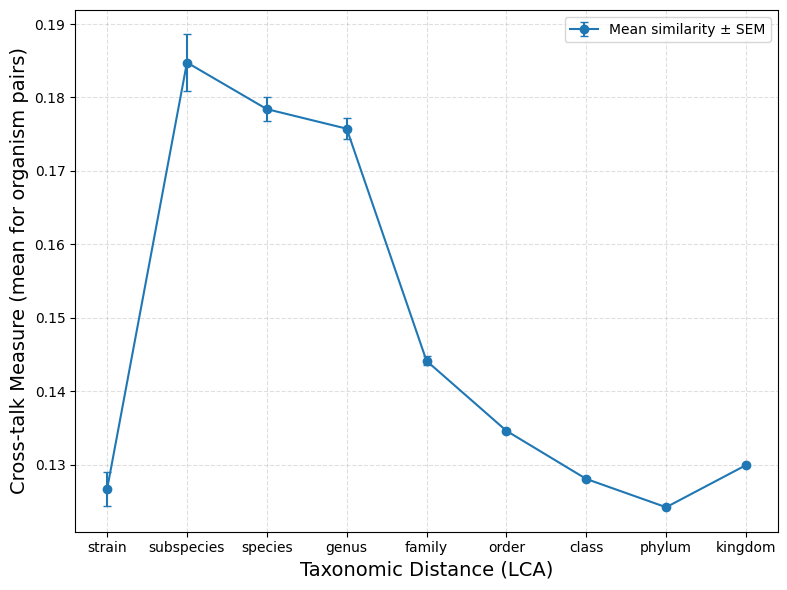

In [170]:
# plot mean similarity vs. taxonomic level

# Calculate mean and standard error of similarity for each taxonomic (lca) level
agg = pair_data_df.groupby('lca_level')['similarity'].agg(['mean', 'std', 'count']).reset_index()
agg['sem'] = agg['std'] / np.sqrt(agg['count'])

level_order = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'subspecies', 'strain'][::-1]

# Ensure only levels present in agg and maintain the order in level_order
present_levels = [l for l in level_order if l in agg['lca_level'].values]
agg_ordered = agg.set_index('lca_level').reindex(present_levels).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(
    agg_ordered['lca_level'],
    agg_ordered['mean'],
    yerr=agg_ordered['sem'],
    fmt='o-', capsize=3,
    label='Mean similarity ± SEM'
)
plt.xticks(present_levels)
plt.xlabel('Taxonomic Distance (LCA)', fontsize=14)
plt.ylabel('Cross-talk Measure (mean for organism pairs)', fontsize=14)
# plt.title('Mean HK-RR Embedding Similarity vs. Taxonomic Distance')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend()

plt.savefig('mean_similarity_vs_taxonomic_level.png')

plt.show()


### Visualize shared embedding space

#### HK vs RR embeddings

##### Before

In [150]:
# Prepare data for t-SNE
# Combine HK and RR embeddings
all_embeddings_before = np.concatenate([
    np.array(test_df['hk_embedding'].tolist()),
    np.array(test_df['rr_embedding'].tolist())
], axis=0)

# Create labels (0 for HK, 1 for RR)
labels = np.array([0] * len(test_df) + [1] * len(test_df))

# Perform t-SNE
# Reduce perplexity and max_iter for faster computation on potentially large datasets
tsne_before = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results_before = tsne_before.fit_transform(all_embeddings_before)

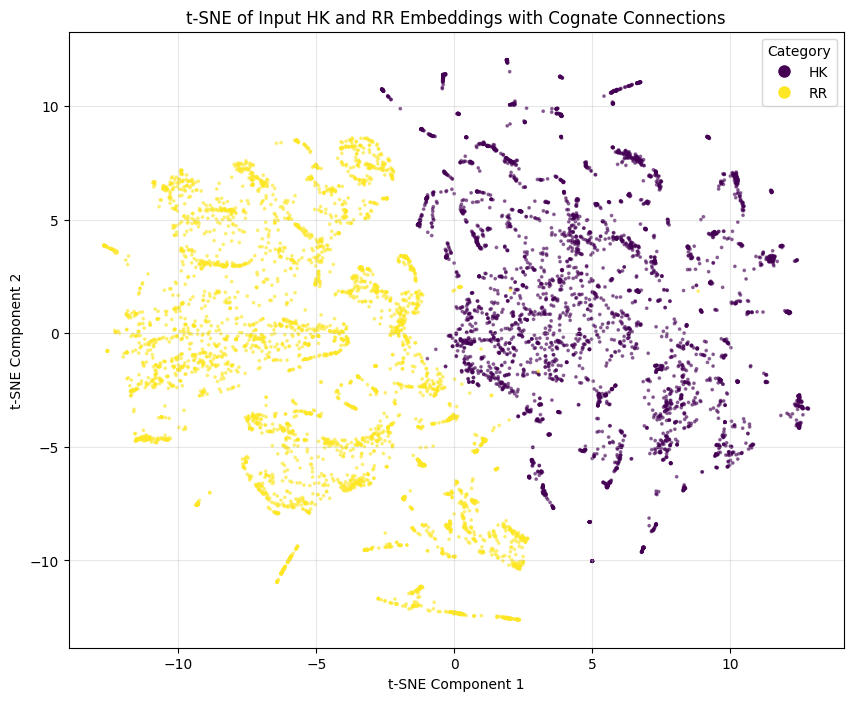

In [151]:
# Plot results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results_before[:, 0], tsne_results_before[:, 1], c=labels, cmap='viridis', alpha=0.5, s=3)

# Add lines connecting cognate HK and RR pairs
# Assuming the first half of tsne_results are HKs and the second half are RRs,
# and that the order corresponds to cognate pairs (HK at index i is cognate to RR at index i + len(test_df))
num_pairs = len(test_df)
for i in range(num_pairs):
    hk_coords = tsne_results_before[i]
    rr_coords = tsne_results_before[i + num_pairs]
    # plt.plot([hk_coords[0], rr_coords[0]], [hk_coords[1], rr_coords[1]], 'k-', linewidth=0.5, alpha=0.2) # Black thin line

# Add legend
legend_labels = ['HK', 'RR']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=scatter.get_cmap()(scatter.norm(i)), markersize=10)
           for i, label in enumerate(legend_labels)]
plt.legend(handles=handles, title="Category")

plt.title('t-SNE of Input HK and RR Embeddings with Cognate Connections')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.show()

##### After

In [67]:
# Prepare data for t-SNE
# Combine HK and RR embeddings
all_embeddings = np.concatenate([
    np.array(eval_df['hk_predicted_embedding'].tolist()),
    np.array(eval_df['rr_predicted_embedding'].tolist())
], axis=0)

# Create labels (0 for HK, 1 for RR)
labels = np.array([0] * len(eval_df) + [1] * len(eval_df))

# Perform t-SNE
# Reduce perplexity and max_iter for faster computation on potentially large datasets
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(all_embeddings)

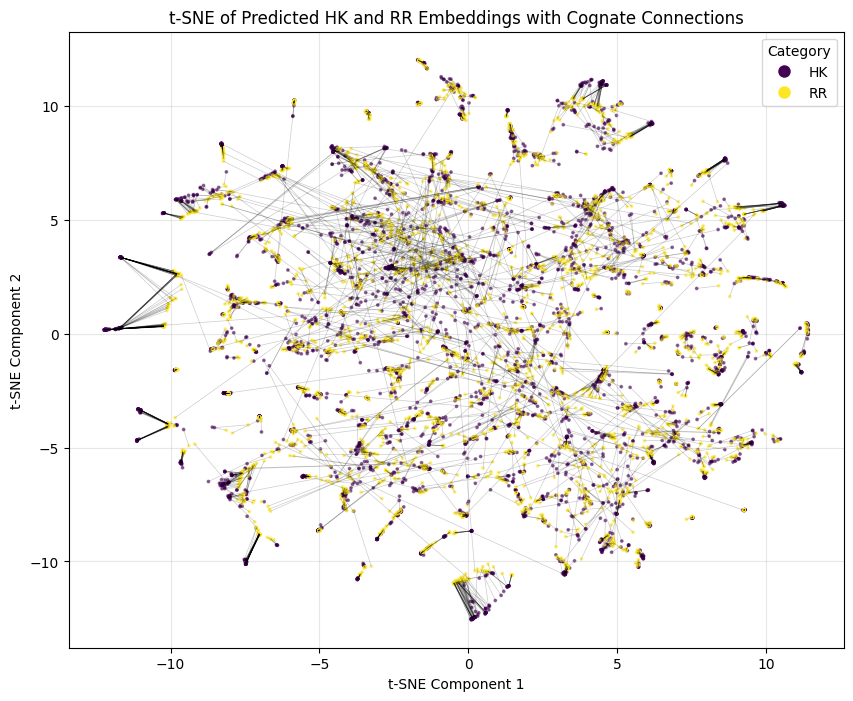

In [68]:
# Plot results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5, s=3)

# Add lines connecting cognate HK and RR pairs
# Assuming the first half of tsne_results are HKs and the second half are RRs,
# and that the order corresponds to cognate pairs (HK at index i is cognate to RR at index i + len(eval_df))
num_pairs = len(eval_df)
for i in range(num_pairs):
    hk_coords = tsne_results[i]
    rr_coords = tsne_results[i + num_pairs]
    plt.plot([hk_coords[0], rr_coords[0]], [hk_coords[1], rr_coords[1]], 'k-', linewidth=0.5, alpha=0.2) # Black thin line

# Add legend
legend_labels = ['HK', 'RR']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=scatter.get_cmap()(scatter.norm(i)), markersize=10)
           for i, label in enumerate(legend_labels)]
plt.legend(handles=handles, title="Category")

plt.title('t-SNE of Predicted HK and RR Embeddings with Cognate Connections')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.show()

#### HK+RR pair embeddings

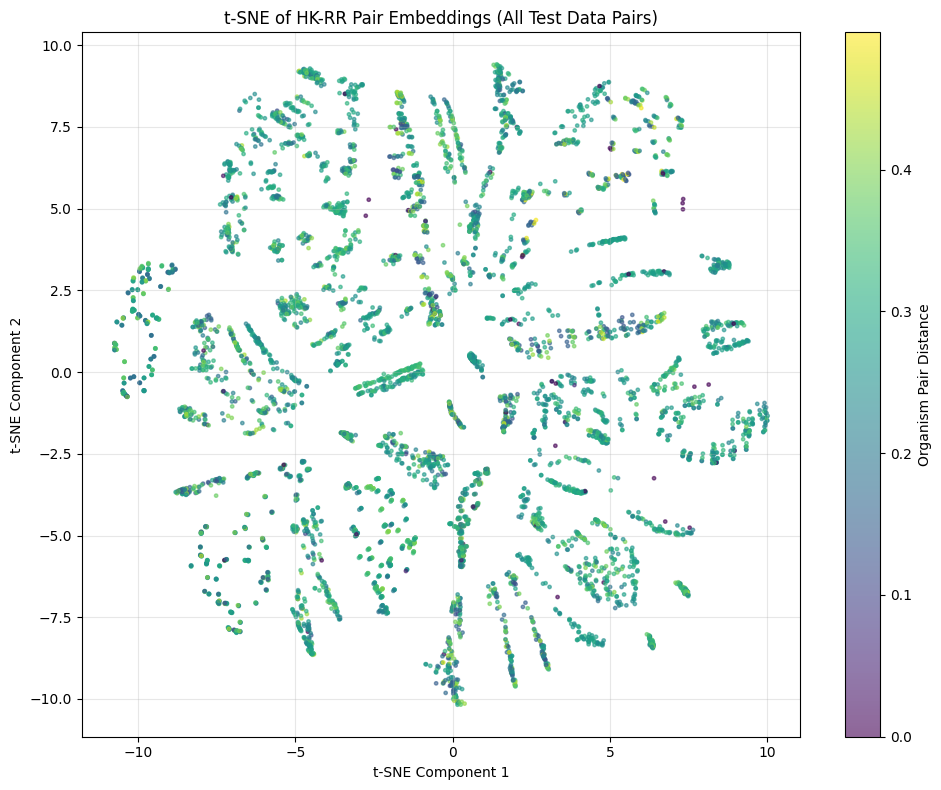

In [82]:
# Assuming eval_df has columns: 'hk_predicted_embedding', 'rr_predicted_embedding', 'organism'
# and there is a distance matrix DataFrame: distance_mat_df with organism names as index and columns

# Parameters for sampling and pairing
num_hk_samples = 100   # number of HKs to sample
num_rr_samples = 100   # number of RRs to sample

# Sample random HKs and RRs with their organism names
hk_samples = eval_df.sample(n=num_hk_samples, random_state=42)
rr_samples = eval_df.sample(n=num_rr_samples, random_state=43)

# Get embeddings and corresponding organism names
# Each row provides: hk_embedding, hk_organism, rr_embedding, rr_organism
hk_emb_list = hk_samples['hk_predicted_embedding'].tolist()
hk_org_list = hk_samples['organism'].tolist()
hk_gene_list = hk_samples['hk_gene'].tolist() if 'hk_gene' in hk_samples.columns else [""]*num_hk_samples

rr_emb_list = rr_samples['rr_predicted_embedding'].tolist()
rr_org_list = rr_samples['organism'].tolist()
rr_gene_list = rr_samples['rr_gene'].tolist() if 'rr_gene' in rr_samples.columns else [""]*num_rr_samples

# Form all possible pairs: (i, j) - hk i with rr j
all_pairs = []
all_distances = []
all_pair_labels = []
for i, (hk_emb, hk_org, hk_gene) in enumerate(zip(hk_emb_list, hk_org_list, hk_gene_list)):
    for j, (rr_emb, rr_org, rr_gene) in enumerate(zip(rr_emb_list, rr_org_list, rr_gene_list)):
        pair_emb = np.concatenate([hk_emb, rr_emb])
        all_pairs.append(pair_emb)
        # Use distance_mat_df to lookup distance between hk_org and rr_org
        try:
            if hk_org == rr_org:
                dist = 0.0
            else:
                dist = distance_mat_df.loc[hk_org, rr_org]
        except Exception:
            dist = np.nan
        all_distances.append(dist)
        all_pair_labels.append(f'HK:{hk_org} ({hk_gene}) | RR:{rr_org} ({rr_gene})')

# Convert to numpy arrays
all_pairs_np = np.vstack(all_pairs)
all_distances_np = np.array(all_distances)

# tSNE
tsne_pairs = TSNE(n_components=2, random_state=123, perplexity=30, max_iter=300)
tsne_pair_results = tsne_pairs.fit_transform(all_pairs_np)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_pair_results[:, 0], tsne_pair_results[:, 1],
    c=all_distances_np, cmap='viridis', alpha=0.6, s=6
)
cbar = plt.colorbar(scatter)
cbar.set_label('Organism Pair Distance')
plt.title('t-SNE of HK-RR Pair Embeddings (All Test Data Pairs)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Misc.

In [ ]:
# Check if gamma is in the model's parameters and requires gradients
print("Checking gamma parameter:")
found_gamma = False
for name, param in model.named_parameters():
    if 'gamma' in name:
        print(f"Parameter name: {name}")
        print(f"Requires grad: {param.requires_grad}")
        print(f"Initial value: {param.item():.4f}")
        found_gamma = True
        break
if not found_gamma:
    print("Gamma parameter not found in model.named_parameters()")

# Temporarily modify the train loop to inspect gradients after a few steps
def train_with_grad_check(model, train_dataloader, optimizer, scheduler, epochs=1, device='cuda', gamma=0.5, hk_vae=None):
    model.to(device)
    if hk_vae is not None:
        hk_vae.to(device)

    model.train()
    if hk_vae is not None:
        hk_vae.train()

    total_train_loss = 0
    batch_count = 0

    print("\nStarting gradient check...")
    for (hk_batch_data, rr_batch_data, organism, hk_genes, rr_genes), indices in tqdm(train_dataloader, desc="Gradient Check"):
        hk_batch_data, rr_batch_data = hk_batch_data.to(device), rr_batch_data.to(device)
        optimizer.zero_grad()

        if hk_vae is not None:
            mu, logvar = hk_vae.encode(hk_batch_data)
            hk_input_for_adapter = mu
        else:
            hk_input_for_adapter = hk_batch_data

        hk_emb, rr_emb, temperature, current_gamma = model(hk_input_for_adapter, rr_batch_data)
        loss = organism_aware_clip_loss(hk_emb, rr_emb, organism, hk_genes, rr_genes, temperature, current_gamma)

        loss.backward()

        # Check gradient of gamma
        gamma_param = None
        for name, param in model.named_parameters():
            if 'gamma' in name:
                gamma_param = param
                break

        if gamma_param is not None and gamma_param.grad is not None:
            print(f"Batch {batch_count+1}: Gamma gradient = {gamma_param.grad.item():.6f}")
        elif gamma_param is not None and gamma_param.grad is None:
             print(f"Batch {batch_count+1}: Gamma gradient is None")
        else:
             print(f"Batch {batch_count+1}: Gamma parameter not found or has no gradient")


        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        batch_count += 1

        if batch_count >= 5: # Check gradients for the first 5 batches
            break

    print("Gradient check finished.")

# Run the gradient check for a few batches of the training data
train_with_grad_check(model, train_dataloader, optimizer, scheduler, epochs=1, device=DEVICE, gamma=model.gamma, hk_vae=None)

Checking gamma parameter:
Gamma parameter not found in model.named_parameters()

Starting gradient check...


Gradient Check:   1%|▏         | 1/71 [00:00<01:03,  1.10it/s]

Batch 1: Gamma parameter not found or has no gradient


Gradient Check:   3%|▎         | 2/71 [00:01<00:37,  1.85it/s]

Batch 2: Gamma parameter not found or has no gradient


Gradient Check:   4%|▍         | 3/71 [00:01<00:26,  2.60it/s]

Batch 3: Gamma parameter not found or has no gradient


Gradient Check:   6%|▌         | 4/71 [00:01<00:21,  3.15it/s]

Batch 4: Gamma parameter not found or has no gradient


Gradient Check:   6%|▌         | 4/71 [00:01<00:32,  2.04it/s]

Batch 5: Gamma parameter not found or has no gradient
Gradient check finished.


## Gaussian Smoothing of Similarity vs. Phylogenetic Distance

/tmp/ipython-input-346815471.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = different_organism_df.groupby('bin')['mean_similarity'].mean().reset_index()


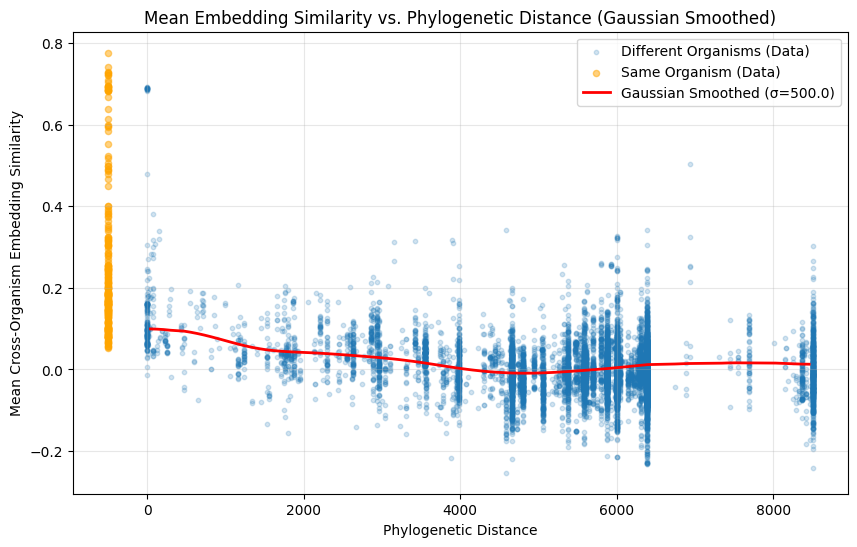

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Ensure the dataframe is sorted by distance for smoothing
similarity_distance_df_sorted = similarity_distance_df.sort_values(by='distance').copy()

# Separate same-organism pairs (-500 distance) as they are a special case
same_organism_df = similarity_distance_df_sorted[similarity_distance_df_sorted['distance'] == -500].copy()
different_organism_df = similarity_distance_df_sorted[similarity_distance_df_sorted['distance'] != -500].copy()

# Define a sigma for the Gaussian kernel - adjust this value to control smoothing
# This value will depend on the scale of your distance values.
# You might need to experiment to find a suitable value.
sigma = 500.0 # Example sigma value, adjust as needed
num_bins = 100 # Number of bins for smoothing


# Bin the data by distance
# Use only different_organism_df for binning the distance range
distance_min = different_organism_df['distance'].min() if not different_organism_df.empty else 0
distance_max = different_organism_df['distance'].max() if not different_organism_df.empty else 1
bins = np.linspace(distance_min, distance_max, num_bins)

# Group data points into bins and calculate the mean similarity for each bin
# Use pd.cut to assign each data point to a bin
different_organism_df['bin'] = pd.cut(different_organism_df['distance'], bins)

# Calculate the mean similarity per bin
# Use the center of the bin as the representative distance for plotting
binned_data = different_organism_df.groupby('bin')['mean_similarity'].mean().reset_index()
binned_data['distance'] = binned_data['bin'].apply(lambda x: x.mid)

# Drop rows with NaN mean_similarity (bins with no data)
binned_data = binned_data.dropna(subset=['mean_similarity'])

# Sort by the center of the bin (distance)
binned_data = binned_data.sort_values(by='distance')


# Apply Gaussian smoothing to the mean similarity values of the bins
# Need to ensure there's data to smooth
if not binned_data.empty:
    # Align the binned distances and mean similarities
    binned_distances = binned_data['distance'].values
    binned_mean_similarities = binned_data['mean_similarity'].values

    # Apply Gaussian filter
    # The sigma here is in terms of bin indices, need to adjust based on distance scale
    # A rough conversion: sigma_indices = sigma_distance / (distance_max - distance_min) * num_bins
    sigma_indices = sigma / (distance_max - distance_min) * num_bins if (distance_max - distance_min) > 0 else 1.0

    smoothed_similarities = gaussian_filter1d(binned_mean_similarities, sigma=sigma_indices)
    smoothed_distances = binned_distances # Use the bin centers as the x-values for the smoothed line
else:
    smoothed_similarities = []
    smoothed_distances = []


# Plot the original scatter points and the smoothed line
plt.figure(figsize=(10, 6))

# Plot different-organism scatter points
plt.scatter(different_organism_df['distance'], different_organism_df['mean_similarity'],
            alpha=0.2, s=10, label='Different Organisms (Data)')

# Plot same-organism scatter points as a separate category
if not same_organism_df.empty:
    plt.scatter(same_organism_df['distance'], same_organism_df['mean_similarity'],
                alpha=0.5, s=20, color='orange', label='Same Organism (Data)')

# Plot the Gaussian smoothed line (only for different organisms)
if smoothed_distances.size > 0: # Check if smoothed_distances is not empty
    plt.plot(smoothed_distances, smoothed_similarities,
             color='red', linewidth=2, label=f'Gaussian Smoothed (σ={sigma})')


plt.xlabel('Phylogenetic Distance')
plt.ylabel('Mean Cross-Organism Embedding Similarity')
plt.title('Mean Embedding Similarity vs. Phylogenetic Distance (Gaussian Smoothed)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()